Advances in imaging equipment and automation have led to an overabundance of data on the functioning of the brain. Technologies today can sample brain activity from a large number of neurons in a large region while organisms are actively behaving. For example, by simultaneously recording the electrical activity of every neuron of the mouse brain over an extended period of time, the amount of data generated will create completely new paradigms for biology, that will require the development of tools to extract value from such unprecedented amount of information.

In this Notebook, we use PySpark and the [Thunder project](https://github.com/thunder-project/thunder), which is developed on top of PySpark, for processing large amounts of time series data in general, and neuroimaging data in particular. We will use these tools for the task of understanding some of the structure of Zebrafish brains, which is a typical (and simple) example used in Neuroimaging. Using Thunder, we will cluster different regions of the brain (representing groups of neurons) to discover patterns of activity as the zebrafish behaves over time.

**Note**: Please, use the documentation for the [Thunder API](http://docs.thunder-project.org/) to learn the details of function calls!


# Goals

The main goals of this notebook are:

1. Learn about Thunder and how to use it
2. Revisit the K-Means algorithm and the method for choosing K
3. Learn alternative approaches to improve the results


# Steps
1. In section 1, we go though some background concepts that are used in this notebook.
2. Next, in section 2, we will get familiar with Thunder, its methods and its data types, by working on some simple tasks.
3. Finally, in section 3, we will build a model to cluster the neurons of a zebrafish based on their behavior. In this step, we will learn about how to use K-Means when the value of K is unknown. Finally, some tricks to improve the results are introduced.

In [1]:
import seaborn as sns
import os
import datetime
import time
import pandas as pd
from IPython.display import display
import statsmodels.api as sm
import thunder as td
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as pyplot


# import two function to draw images easier
from showit import image as draw_image
from showit import tile as draw_tile


# 1. Background concepts

In this section, we cover the terminology and the concepts that constitute the domain knowledge for this notebook.

As it should be well-known, a `pixel` is a combination of "**pic**ture **el**ement": digital images can be modeled as simple 2-dimensional (2D) matrices of intensity values, and each element in the matrix is a pixel. In color images, a pixel contains values of red, green, and blue channels. In a grayscale image, the three channels have the same value, such that each pixel is reduced to be a single value.

A single 2D image is not nearly enough to express 3D objects, which use a **voxel**, representing a value of the 3D image on a regular grid in a three-dimensional space.  A possible technique to work on 3D images is to acquire multiple 2D images of different slices (or `planes`, or `layers`) of a 3D object, and stack them one on top of each other (a z-stack). This ultimately produces a 3D matrix of intensity values, where each value represents a `volume element` or `voxel`.

![](https://upload.wikimedia.org/wikipedia/commons/b/b4/Voxelgitter.png)
<div style="text-align:center;">This z-stack image has 4 layers. A point is a voxel. It can be determined by the layer's index and the position in that layer.</div>

In the context of the Thunder package, we use term `image` for `3D-image` or `stack image`. Thunder uses `Image` type to  represent 3D-image. Each `Image` object is a collection of either 2D images or 3D volumes. In practice, it wraps an n-dimensional array, and supports either distributed operations via Spark or local operations via  numpy , with an identical API.

Stack-images can represent 3D objects, but it can be difficult to take the temporal relationship of the images into account. To do that, we need another data structure that shows the changes of voxels over time. In the Thunder package, the internal `Series` type can be used exactly for this purpose. Each `Series` is a 1D array such that each element is a value of the voxel at a timestamp.

The most common series data is time series data, in which case the index is time and each record is a different signal, like a channel or pixel.

We now have sufficient material to start playing with Thunder !!!

# 2. Let's play

Well, wait a second before we play... Remember, we're going to use Spark to perform some of the computations related to this Notebook. Now, when you spin a Zoe Notebook application (this comment is valid for students at Eurecom), you'll gain access to an individual, small Spark cluster that is dedicated to your Notebook. This cluster has two worker machines, each with 6 cores. As such, a good idea to obtain smooth performance and a balanced load on the workers, is to ```repartition``` your data (i.e., the RDDs you use to represent images or time series).

In this Notebook we **expect** students to take care of repartitioning, and such care will be compensated by bonus points.

## 2.1. Play with Image objects

### a. Loading image data

Both `images` and `series` can be loaded from a variety of data types and locations. You need to specify whether data should be loaded in 'local' mode, which is backed by a numpy array, or in 'spark' mode, which is backed by an RDD by using the optional argument `engine`. The argument `engine` can be either `None` for local use or a SparkContext for` distributed use with Spark.

```python
import thunder as td

# load data from tif images
data = td.images.fromtif('/path/to/tifs')

# load data from numpy-arrays
data = td.series.fromarray(somearray)
data_distributed = ts.series.fromarray(somearray, engine=sc)
```

We can load some example image data by:

In [43]:
# load some example image data
image_data = td.images.fromexample('fish', engine=sc)
#image_data = td.images.fromexample('fish')

# print the number of images
print(image_data.count())

20


### b. Inspecting image data

Shape of the data: (20, 2, 76, 87)
Shape of the data of the first image: (2, 76, 87)
Data of the first image: [[[26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 27 27 26]
  ..., 
  [26 26 26 ..., 27 27 26]
  [26 26 26 ..., 27 26 26]
  [25 25 25 ..., 26 26 26]]

 [[25 25 25 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  ..., 
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]]]


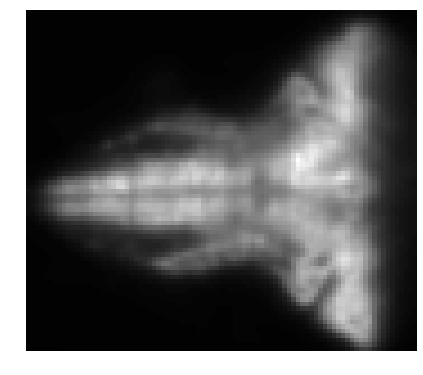

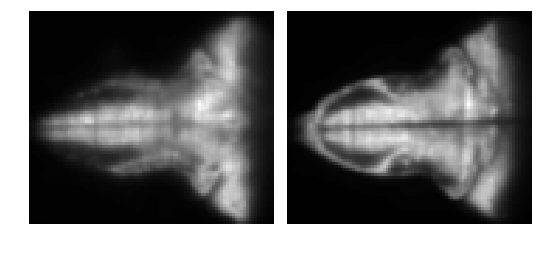

In [23]:
print("Shape of the data:", image_data.shape)

first_image = image_data.first() # get the values of Image object
# or first_image = image_data[0] # get the Image object

print("Shape of the data of the first image:", first_image.shape)

print("Data of the first image:", first_image)


# draw the first layer of the first image
draw_image(first_image[0])

# draw all layers of the first image
draw_tile(first_image)

# we can use index slices to take images
samples = image_data[0:6]



From the result above, the shape of the loaded data is (20, 2, 76, 87). It means we have total 20  3D images objects. Each image has 2 layers, each layer has size 76x87. 

Note that, although  data  is not itself an array (it can be a kind of RDD), we can index into it using bracket notation, and pass it as input to plotting methods that expect arrays. In these cases, the data will be automatically converted.

One of the advantages of working in Python is that we can easily visualize our data stored into Spark RDDs using the Matplotlib library. Function `draw_image` and `draw_tile` that take advantages of Matplotlib are examples.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 1

<div class="alert alert-info">  
a) Use the function `imgshow` from matplotlib to plot each layer of the first image in `image_data`.  

b) Discuss the choice of parameters you use for the method `imgshow`  

</div>

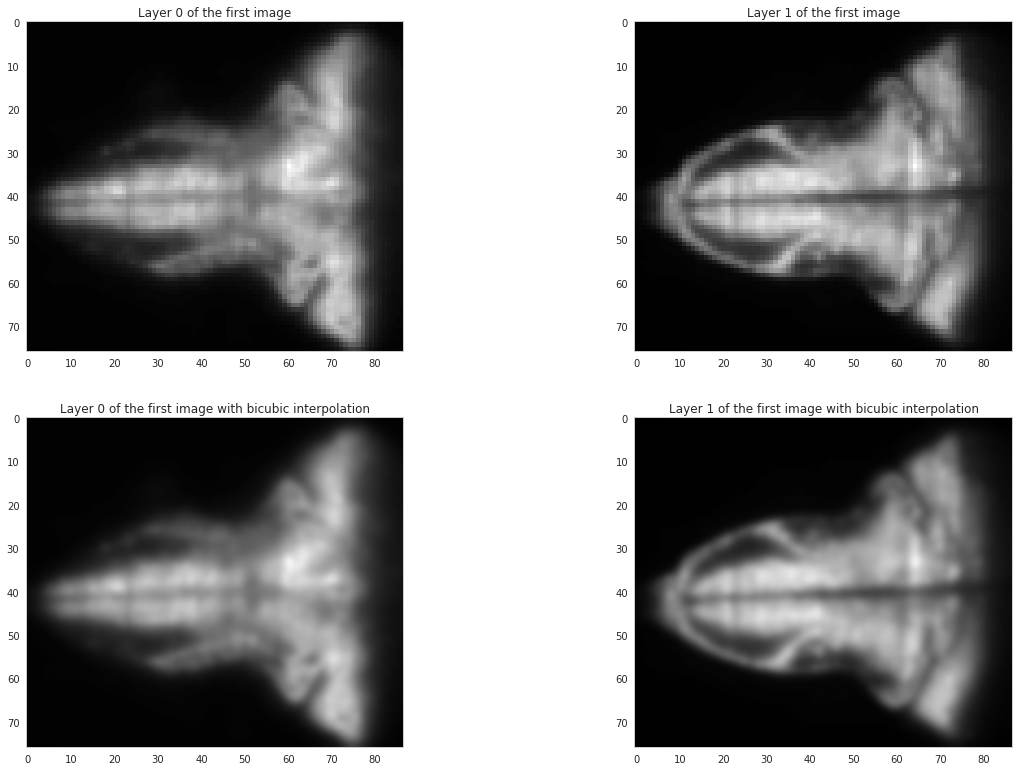

In [24]:
image_data.repartition(12)
sns.set_style("whitegrid", {'axes.grid' : False})
img = image_data.first()
# or:
# img = image_data[1]
oFig1 = plt.figure(figsize=(20,13))
# show the first layer
oFig1.add_subplot(2,2,1)
plt.imshow(img[0], interpolation='nearest', aspect='equal', cmap='gray')
plt.title("Layer 0 of the first image")

# show the second layer
oFig1.add_subplot(2,2,2)
plt.imshow(img[1], interpolation='nearest', aspect='equal', cmap='gray')
plt.title("Layer 1 of the first image")

# show the layer bicubic interpolation
oFig1.add_subplot(2,2,3)
plt.imshow(img[0], interpolation='bicubic', aspect='equal', cmap='gray')
plt.title("Layer 0 of the first image with bicubic interpolation")


oFig1.add_subplot(2,2,4)
plt.imshow(img[1], interpolation='bicubic', aspect='equal', cmap='gray')
plt.title("Layer 1 of the first image with bicubic interpolation")
plt.show()

<div class="alert alert-success">
As you can see in the code below, we have decided to use a 12 level of repartition because we have 12 Spark workers. In this way, we should take more computional advantages dividing the work between our workers; however the fish data sample contains a small quantityu of data: in fact we'll discover than there are not advantages to divide the work for this dataset because the network delay seems to affect the performance for this small data quantity.
However usually the image data are heavy and if the number of images is major, it's probaly better to parellize the job.
<br>
<br>
In addition by default the bilinear interpolation is setted but we are using the nearest interpolation, that is the simpler and the faster one. When the image is rescaled, it basically sets as gray value for the new pixel, the nearest of the orginal one. The bicubic interpolation does actually produce more smooth images (as you can see from the last one) but actually we are not very interested to this aspect, at least for now. In fact, in every case, the interpolation introduces new information, not derived from the reality.
</div>

Then, we can perform operations that aggregate information across images.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Calculate the standard deviation across all images you have in `image_data` (that is, our dataset). To clarify, let's focus on an individual layer (say the first layer of each image). For every `voxel`, compute the standard deviation of its values across different images for the same layer. Visualize the standard deviation you obtain, for example concerning a single layer (as before, say the first layer).

</div>

<div class="label label-success">HINT 1</div> to avoid wasting time and energy, make sure you lookup for methods that could help answer the question from the Thunder documentation.  

<div class="label label-success">HINT 2</div> We can also use function `draw_image(<data>)` to plot an image in a simple way instead of using many statements with matplotlib as before.

<div class="label label-danger">NOTE</div> Comment the image you obtain. What does it mean to display the standard deviation across all images in a single layer?

<div class="alert alert-success">
We know abou the possibily to fastly use `draw_image(<data>)` but we decided to create a general funtion to draw also sublots and use it for all Notebook. We define it now.
</div>

In [20]:
def plot_image(images,titles=[],cmap='gray',intepolation='nearest'): 
    number_of_images = len(images)
    if number_of_images > 1:
        if number_of_images % 2 == 0:
            rows = int(number_of_images / 2)
        else:
            rows = int(number_of_images / 2) + 1

        oFig1 = plt.figure(figsize=(20,5*rows+3))
        
        i = 0
        for img in images:
            oFig1.add_subplot(rows,2,i+1)
            plt.imshow(img, interpolation=intepolation, aspect='equal', cmap=cmap)
            if len(titles) != 0:
                plt.title(titles[i])
            i += 1
    else:
        plt.figure(figsize=(25,10))
        plt.imshow(imgages[0], interpolation=intepolation, aspect='equal', cmap=cmap)
        plt.title(titles[0])
    plt.show()


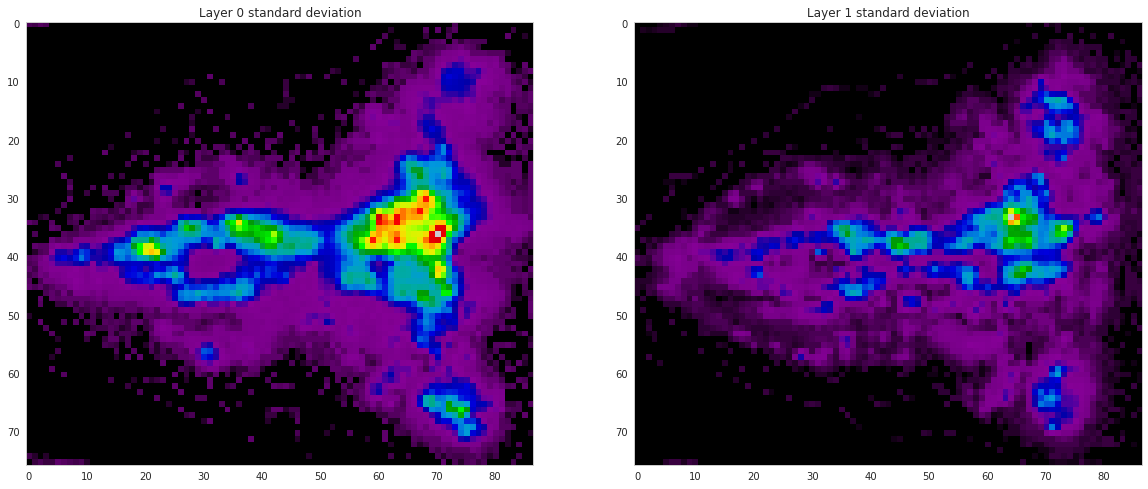

In [26]:
titles = ["Layer 0 standard deviation","Layer 1 standard deviation"]
std_imgs = [image_data.std().map(lambda img: img[j]) for j in range(0,2)]
plot_image(std_imgs,titles,cmap='nipy_spectral')

<div class="alert alert-success">
The standard deviation indicates the amount of variation of a set of data values, a layer of images. So high values (the white ones in the picture) indicate that the value of the considered pixel changes a lot between different images at different time; at the opposite the low values indicate that the pixel value is pretty constant.In fact `std()` is a function that computes the standard deviation across images that is really different that to compute the standard deviation inside a single image; this is more useful to reveal outliers. Instead, we are interested to how the brain activities change along the time.
<br>
<br>
Considering this specific cases, considering both layers and x axis as symmetric axis, the variations seems symmetric;
it could mean that the fishes use the upper part and the lower part of the brain in equal measure. To be very precise, in the upper part there is a little bit more variation than in the lower part.
</div>

### c. Selecting samples of image data

The Images API offers useful methods for working with large image data. For example, in some cases it is necessary to subsample each image, to make sure we can analyze it efficiently.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3

<div class="alert alert-info">  
The source code below subsamples image data with different ratios on different dimensions.   

a) Complete the source code to plot the first layer of the first image.   

b) What is the shape of `image_data` before and after subsampling?  

</div>

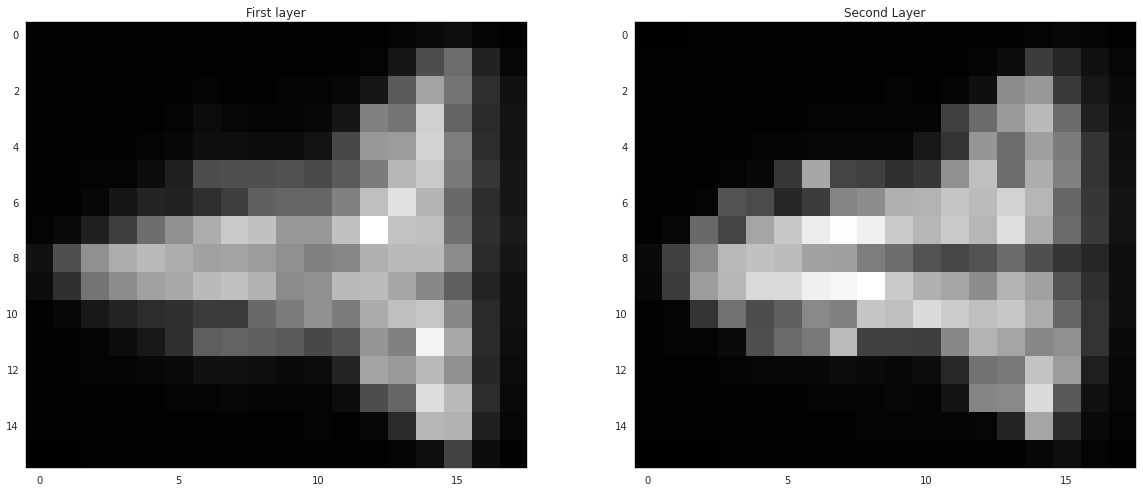

Before subsampling: (2, 76, 87)
After subsampling: (2, 16, 18)


In [27]:
subsampled = image_data.subsample((1, 5, 5))
# Stride to use in subsampling. If a single int is passed, each dimension of the image
# will be downsampled by this same factor. If a tuple is passed, it must have the same
# dimensionality of the image. The strides given in a passed tuple will be applied to
# each image dimension76
titles_subsampled = ["First layer","Second Layer"]
layers_subsampled = [subsampled.first()[0],subsampled.first()[1]]
plot_image(layers_subsampled,titles_subsampled)

print("Before subsampling:", image_data.first().shape)
print("After subsampling:", subsampled.first().shape)

<div class="alert alert-success">
We have subsampled both component by a 5 factor. Our initial resolution was 76 by 87, so dividing by 5 we obtain a new resolution of 16 by 18.
<br>
<br>
As you can see, the subsampling clearly affects the image quality; this actually means to loose a lot of information about the shapes. In fact now it is really difficut to understand the image content for an human viewer. However the fact tha the number of data is decreased could be useful to  process faster a big number of images. So it is necessary to think and reason about this trade-off depending on the application. As we have said before our input data is small, so we don't need to subsample.
</div>

Note that `subsample` is an RDD operation, so it returns immediately. Indeed, we know that in Spark you must apply a RDD action to trigger the actual computation.

### d. Converting image data
We can also convert an RDD of images to a RDD of series by:

In [28]:
seriesRDD = image_data.toseries()
seriesRDD.cache()

Series
mode: spark
dtype: uint8
shape: (2, 76, 87, 20)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">
According to your understanding about `Series` objects which was introduced in section 1, what is the shape of `seriesRDD` and its elments ?  

Comment your results, don't just display numbers.
</div>

<div class="alert alert-success">
Below we define a function to get a specific element of an image array or a series, not only the first. 
</div>

In [2]:
def takeElement(obj,n=0):
    return obj.values[n].toarray()


In [30]:
print(image_data)
print(takeElement(image_data,3)[1][5][80])
#print(image_data.first())
print(seriesRDD)
print(takeElement(seriesRDD,1)[5][4])
print(takeElement(seriesRDD,1)[5][80][3])

Images
mode: spark
dtype: uint8
shape: (20, 2, 76, 87)
33
Series
mode: spark
dtype: uint8
shape: (2, 76, 87, 20)
[26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26]
33


<div class="alert alert-success">
As we can see above the image and series objects rapresent the same content in a different way. In fact we can think our `image_data` variable as an array of images; we have 20 neuron images, so we can specify indexes from 0 to 19 to get a specific image. 
<br>
Instead, using the time series, we have to think about the concept of voxel: every pixel is rapresented by the x and y coordinates and by a third component that is the time. Using this rapresentation, it's easy to observe how a pixel luminance changes during the time. In this case the first indexing level is referred to the layer. So typing `takeElement(seriesRDD,1)` we obtain the second level. So on, typing `takeElement(seriesRDD,1)[5][4]` we obtain all temporal lunimance values referred to the pixel at coordinates (5,4) for the second layer. We can also use the `first()` method to obtain the first time series. 
 </div>

For a large data set that will be analyzed repeatedly as a `Series`, it will ultimately be faster and more convienient to save `Images` data to a collection of flat binary files on a distributed file system, which can in turn be read back in directly as a `Series`, rather than repeatedly converting the images to a `Series` object. This can be performed either through a ThunderContext method, `convertImagesToSeries`, or directly on an Images object, as done below:

In [31]:
local_series = image_data.toseries().tolocal()
local_series.tobinary('series_trials' ,overwrite=True)
ts = td.series.frombinary('series_trials', engine=sc)

We will study about `Series` object in the next section.

## 2.2. Play with Serises objects

### a. Loading Series data

In this section, we use a sample data to explore `Series` objects.

In [6]:
# series_data = td.series.fromexample('fish', engine=sc)
# series_data = td.series.frombinary(path='s3n://thunder-sample-data/series/fish', engine=sc)
series_data = image_data.toseries()


### b. Inspecting Series data

`Series_data` is a distributed collection of key-value records, each containing a coordinate identifier and the time series of a single `voxel`. We can look at the first record by using `first()`. It’s a key-value pair, where the key is a tuple of `int` (representing a spatial coordinate within the imaging volume) and the value is an one-dimensional array.

In [7]:
first_series = series_data.first() # get the values of Series object
#first_series = series_data[0] # get a Series object

print("Shape of series:", series_data.shape)
print("The first series:", first_series)
print("Each element in series has", len(first_series), "values")

# print the 10th value of voxel (0,0,0)
# layer = 0
# coordinator = (0,0) in that layer
print("value 10th of voxel (0,0,0):", np.array(series_data[0,0,0,10]))

Shape of series: (2, 76, 87, 20)
The first series: [26 26 26 26 26 26 26 25 26 25 25 25 26 26 26 26 26 26 26 26]
Each element in series has 20 values
value 10th of voxel (0,0,0): 25


The loaded series data is a multi-dimensional array. We can access the values of a voxel in time series by using a tuple as above. In our data, each voxel has 20 values corresponding to 20 states at 20 different times.

### c. Selecting Series data
Series objects have a 1D index, which can be used to subselect values.

In [34]:
print("shape of index:", series_data.index.shape)
print("the first element of a subset", series_data.between(0,8).first())

shape of index: (20,)
the first element of a subset [26 26 26 26 26 26 26 25]


Values can be selected based on their index:

In [35]:
print(series_data.select(lambda x: x > 3 and x < 8).index)
print(series_data.select(lambda x: x > 3 and x < 8).first())


[4, 5, 6, 7]
[26 26 26 25]


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 5
<div class="alert alert-info">

Plot the first 20 values of **all** series objects (that is the values of a voxel) in the series data. This means, on the same plot, you should visualize the values each voxel takes in the first 20 time intervals.

</div>

```python
import numpy as np

# only select the first 20 states of each object
samples = series_data.between(...).tordd().values().collect()

plt.plot(np.array(samples).T)
plt.show()

```

In [36]:
import numpy as np

# only select the first 20 states of each object
samples = series_data.between(0, 20).tordd().values().collect()
np_samples = np.array(samples)

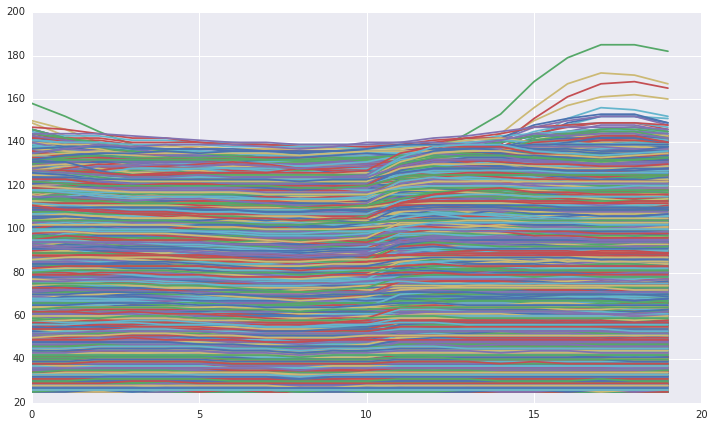

In [37]:
sns.set_style("darkgrid", {'axes.grid' : True})
plt.figure(figsize=(12,7))
plt.plot(np_samples.T)
plt.show()

<div class="alert alert-success">
The graph shows how the pixels's luminance values change throught the time. However we are considering 13224 pixels, so it's diffult to analyze the plot. Below we'll try to analyze it by bands based on the voxel luminance standard deviation.
</div>

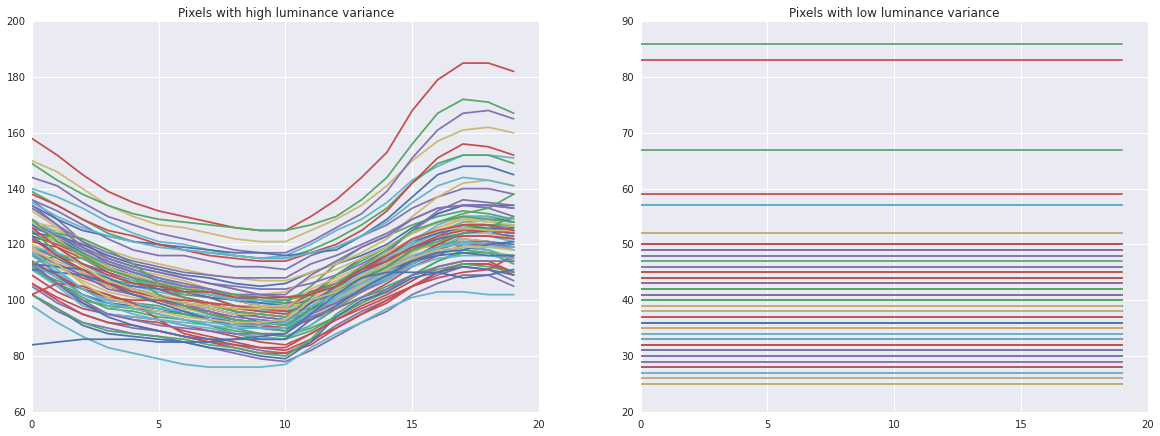

Number of pixels with high luminance variance: 73
Number of pixels with low luminance variance: 5609


In [38]:
avg_var = np.mean([np.std(x) for x in np_samples])
np_samples_high_variance = np.array([x for x in np_samples if np.std(x) > avg_var*10])
np_samples_low_variance = np.array([x for x in np_samples if np.std(x) <= avg_var/10])
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(np_samples_high_variance.T)
plt.title("Pixels with high luminance variance")
plt.subplot(122)
plt.plot(np_samples_low_variance.T)
plt.title("Pixels with low luminance variance")
plt.show()

print ("Number of pixels with high luminance variance: "+str(len(np_samples_high_variance)))
print ("Number of pixels with low luminance variance: "+str(len(np_samples_low_variance)))


#variances = sorted([np.var(x) for x in np_samples])

<div class="alert alert-success">
Looking at the graph above, we can see that the number of pixel for which the luminance standard deviation is high is lower than the number of pixels for which the luminance is low. This means that many regions of the image are not part of the brainfish or they rapresent zones that don't change durint the time.
</div>

Now, another objective we can have is to select specific series objects within the same series data. For example, we can select objects randomly by using function `sample`.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6

<div class="alert alert-info">

Let's plot a random subset of the data using the method `sample`.  

Complete the source code below to plot the first 20 values of 30 objects that are selected randomly among those that pass the condition on the standard deviation, using function `sample`.

</div>

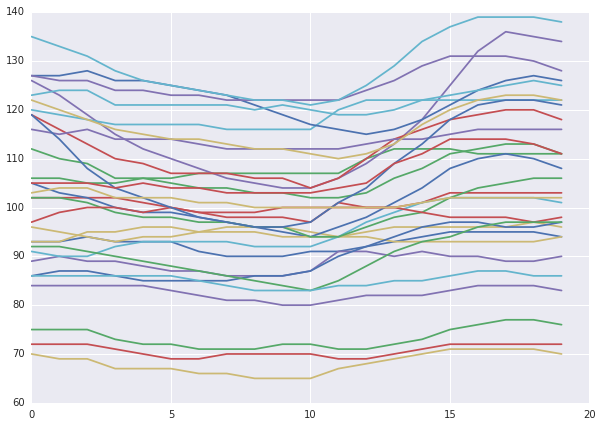

In [39]:
# select 30 objects randomly which have standard deviation > threshold
# Extract random subset of records, filtering on a summary statistic.
examples = series_data.filter(lambda x: x.std() > 1.0).sample(30)
# only plot first 20 states of each object
plt.figure(figsize=(10,7))
plt.plot(np.array(examples).T)
plt.show()

<div class="alert alert-success">
This is actually what we have done before, plotting the high and the low bands, but in this case we are considering only samples of data. However, the information showed in the plot above is note very interesting. In fact we should normalize our data before showing the standard deviation, as explained below.
</div>

### d. Preprocessing Series data
A `Series` objects has some methods which can be useful in an eventual preprocessing phase.

For example,`center` subtracts the mean, `normalize` subtracts and divides by a baseline (either the mean, or a percentile).

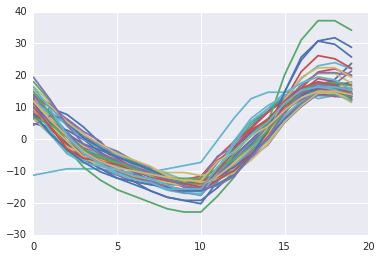

In [40]:
examples = series_data.center().filter(lambda x: x.std() >= 10).sample(50)
plt.plot(np.array(examples).T)
plt.show()

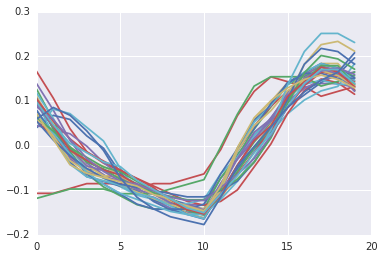

In [41]:
normalizedRDD = series_data.normalize(method='mean').filter(lambda x: x.std() >= 0.1).sample(50)
plt.plot(np.array(normalizedRDD).T)
plt.show()

### e. Computing statistics about Series data
A `Series` can be summarized with statistics both within and across images. To summarize **across records** (the statistic of all voxels at each timestamp), we can do the following:

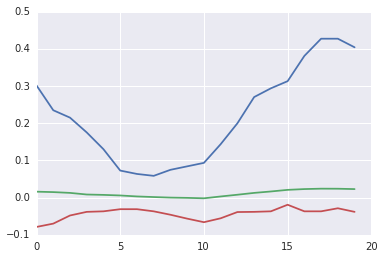

In [42]:
plt.plot(series_data.normalize().max());
plt.plot(series_data.normalize().mean());
plt.plot(series_data.normalize().min());

To summarize **within records**, we can use the `map` method:

In [43]:
means = series_data.map(lambda x: x.mean())
flat_means = means.flatten().toarray()
flat_stdevs = stdevs = series_data.map(lambda x: x.std()).flatten().toarray()
print("means:", flat_means)
print("length of means:", len(flat_means))
print("mean of the first series:", flat_means[0])
print("standard deviation of the first series:", flat_stdevs[0])

means: [ 25.8   25.85  25.7  ...,  26.    26.    26.  ]
length of means: 13224
mean of the first series: 25.8
standard deviation of the first series: 0.4


`means` is now a `Series` object, where the value of each record is the mean across the time series for that voxel.

Note that in the source code above, we use function `toarray` to return all records to the driver as a numpy array.

For this `Series`, since the keys correspond to spatial coordinates, we can `pack` the results back into a local array in **driver node**.


To look at this array as an image, we can use function `draw_image` as before.

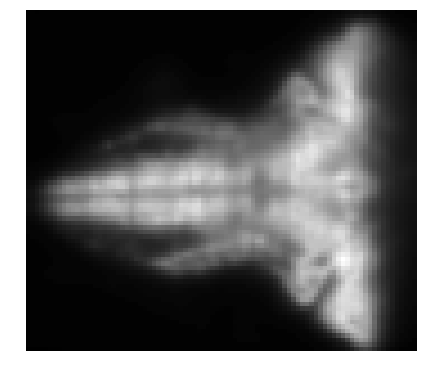

In [44]:
# we should recover the shape of means before plotting
# draw the stdandard deviations of series that belong to the first layer
draw_image(flat_means.reshape((2, 76, 87)) [0,:,:])

Note that `toarray` is an example of a local operation, meaning that all the data involved will be sent to the Spark driver node. In this case, packing the mean is no problem because its size is quite small. But for larger data sets, this can be **very problematic**. So, it's a good idea to downsample, subselect, or otherwise reduce the size of your data before attempting to pack large image data sets! 

### f. Identifying correlations

In several problem domains, it may also be beneficial to assess the similarity between a designated signal (time series) and another signal of interest by measuring their correlation. For example, say we have two time series corresponding to the consumption of Coca Cola and Pepsi, it would perhaps be interesting to verify whether behavioural patterns are similar for both brands over time.<br>

Simply as a proof of concept, we shall compare our data to a random signal and we expect that, for a random signal, the correlation should be low. The signal can be stored as a numpy array or a MAT file containing the signal as a variable. Note that the size of the signal must be equal to the size of each `Series` element.

In [6]:
from numpy import random
signal = random.randn(len(first_series))
print("The correlation of the first element with random signal:" , series_data.correlate(signal).first())

first_element = series_data.first()
corr = series_data.correlate(np.array(first_element))
print("The correlation of the first element with itselft:", corr.first())

The correlation of the first element with random signal: [-0.02058272]
The correlation of the first element with itselft: [ 1.]


# 3. Usecase

## 3.1. Context
Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

In this notebook,  we use K-Means, a well known clustering algorithm which is also familiar to you, as it was introduced during the last lecture on anomaly detection.

## 3.2 Data
The dataset we will use is the time series data which we played with in the previous section. Refer to section 2 if you want to duplicate the code to load such data.

## 3.3.  Building model
### a. Importing required modules

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import KMeans, KMeansModel
from matplotlib.colors import ListedColormap

### b. Loading & inspecting the data

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Load example series data from `fish`, then normalize and cache it to speed up repeated queries. Print the dimensional information of the loaded data.

</div>

In [4]:
####!@SOLUTION@!####
# we must normalize it to get best clustering
data = td.images.fromexample('fish', engine=sc).toseries().normalize()

data.repartition(12)

# cache it to speed up related queries
data.cache()

# check the dimensions of data
print (data.shape)

(2, 76, 87, 20)


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">
When studying the properties of large data set, we often take a small fraction of it. We have many strategies to select this subset, such as selecting randomly, selecting elements that has the standard deviation bigger than a threshold, or mixing the conditions.  

In this notebook, we will use the second method as a small demonstration.

<ul></ul>

In order to choose a good value for the threshold of standard deviation, we should compute the stddev of each series and plot a histogram of a 10% sample of the values.

<ul></ul>

Complete the source code below to compute the standard deviation of series in data. Plot the histogram of it and discuss it in details. In your opinion, what should be the best value for the threshold ?

</div>

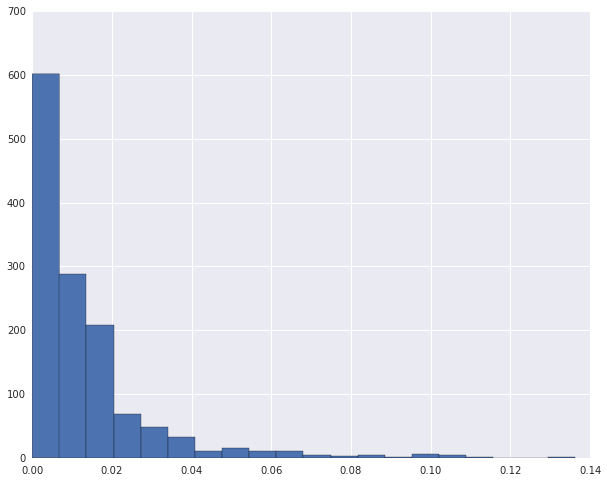

In [4]:
# calculate the standard deviation of each series
# then select randomly 10% of value to plot the histogram
sample_size = int(data.count()/10)
stddevs = (data.map(lambda x: x.std()).
            sample(sample_size).
           flatten().
           toarray()
          )

# plot the histogram of 20 bins
plt.figure(figsize=(10,8))
plt.hist(stddevs, bins=20)
plt.show()

<div class="alert alert-success">
Looking at the histogram we can deduce that the majority of the voxels have a very low standard deviation; reasoning about it, we consider this normal because in the images there are many black pixels that don't rapresent the fish; in addition we don't know which pixels rapresent the most relevant zones of the brain because we are not animals's experts. So what can we do? Not knowing which are the most significant zones we have at least to delete the voxels that don't rapresent the fish (the black ones) and more generally the ones for which the standard deviation is really low. 
<br>
To understand which is the best standard deviation threshold we can analyze more in deepth the cumulative distribution and the percentiles.
</div>

In [8]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        count = 0
        for row in self:
            html.append("<tr>")
            
            for col in row:
                if count == 0:
                    html.append("<td><b>{0}</b></td>".format(col))
                else:
                    html.append("<td>{0}</td>".format(col))
            count += 1
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [9]:
stddevs_np = np.sort(stddevs)
percentiles_tuples = []
percentiles_tuples.append(("Percentile","Std_value"))
for x in range(0,101,5):
    p = np.percentile(stddevs_np, x)
    percentiles_tuples.append((x,p))
table = ListTable()
for t in percentiles_tuples:
    table.append(t)

table

[('Percentile', 'Std_value'),
 (0, 0.0),
 (5, 0.0),
 (10, 0.0),
 (15, 0.0),
 (20, 0.0),
 (25, 0.0),
 (30, 0.0),
 (35, 0.0),
 (40, 0.0),
 (45, 0.0071087953442365483),
 (50, 0.008350381117894011),
 (55, 0.0098914094773512665),
 (60, 0.011293044562317927),
 (65, 0.012455943206966073),
 (70, 0.013798740493500439),
 (75, 0.015558698508384743),
 (80, 0.01851599641588289),
 (85, 0.023479216652580428),
 (90, 0.032097088936829291),
 (95, 0.051124352874230276),
 (100, 0.1163797105517877)]

<div class="alert alert-success">
Above the table shows the percentiles. We can see that the 40% of pixels have standard deviation null. Setting a threshold of 0.01 we'll remove more than the 55% of voxels but it's probable that in the remaining ones there will be some voxels for which the variance is not really high, so not very useful; setting a thereshold of 0.02 we'll delete more than the 80% of the pixels and this is too much. So we have to find a good value between 0.01 and 0.02.
</div>

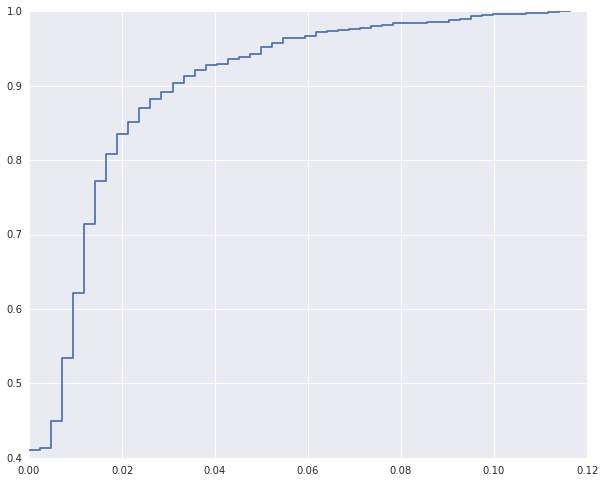

In [10]:
sample = stddevs_np
ecdf = sm.distributions.ECDF(sample)
plt.figure(figsize=(10,8))
x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.step(x, y)
plt.show()

<div class="alert alert-success">
Here the ECDF of the standard deviation. We can confirm what we have said before: the majority of voxels have a very low variance.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9

<div class="alert alert-info">

Extract some samples just to look at the typical structure of the time series data.
The objects are selected randomly, and has the standard deviation bigger than the threshold which you picked in question 8.
Plot the samples and discuss your obtained figure.

</div>

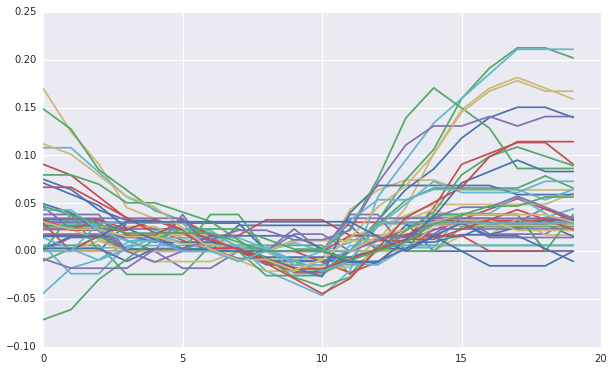

In [7]:
# sample 50 objects of the data randomly base on the standard deviation
threshold = 0.011
plt.figure(figsize=(10,6))
examples = data.filter(lambda x: x.std() > threshold).sample(50, 0)

# plot the sample data
plt.plot(np.array(examples).T)
plt.show()

<div class="alert alert-success">
The graph clearly shows that the chosen voxels have pretty high standard deviation. This is similar to what we have seen in question 5.  
</div>

### c. Clustering series
In this section, we will use K-means to cluster the series. In other words, we cluster the voxels based on the their behavior. Currently, we have no clue about how many groups `K` of neural behavior. To this end, instead of choosing a single value K, we use multiple values, build model with each `K` and compare the resulting error values. After that, we can choose the best value of `K`. 

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Complete the source below to build multiple models coresponding to multiple values of `K` using algorithm KMeans of Thunder.  

a) Comment the structure of the code. Precisely, focus on the `for` loop, and state what is parallel and what is not.  

b) Can you modify the structure of the code such that you use the most of the parallelization capabilities of Spark?  

</div>

In [4]:
from pyspark.mllib.clustering import KMeans
import time
ks = [5, 10, 15, 20, 30, 50, 100, 200]

# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1]) ).cache()
    
def buildModels_1(data):
    # declare the collection of models
    models = [] 

    # build model for each K and append to models
    for k in ks:    
        models.append(KMeans.train(data, k)) 
    return models

time0 = time.time()
models = buildModels_1(training_data)
print(time.time() - time0, "seconds")

35.78012156486511 seconds


<div class="alert alert-success">
In this first model the data are repartitioned and the KMeans is computed using the PySpark clustering module, so it's parallelized. The ks vector is not broadcasted.
</div>

In [5]:

# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1]) ).cache()
    
def buildModels_2(data):
    # declare the collection of models
    models = [] 

    # build model for each K and append to models
    for k in ks_broadcast.value:    
        models.append(KMeans.train(data, k)) 
    return models

time0 = time.time()
ks_broadcast = sc.broadcast([5, 10, 15, 20, 30, 50, 100, 200])
models = buildModels_2(training_data)
print(time.time() - time0, "seconds")

25.203007698059082 seconds


<div class="alert alert-success">
The difference respect to the first model is that in this case we are broadcasting the centroids: it seems to take advantage; however we are considering the specific case in which the repartition level of our data is set to 12; it makes sense because if we are using more cores, the array has to be sent more times; this could cause a bigger delay than to broadcast it, so saving it on each machine. However we run the 2 model only one time, so it's not possible to affirm that this is always the case.
<br>
So to understand which is the best repartition level and if to broadcast the array of ks is convenient, we'll change the repartition level between 1 and 12 and we'll examine both models for each repartition number. To be sure to not consider isolated cases, we'll perform 10 trials, averaging the results at the end.
</div>

In [ ]:
repartion_range = range(1,13)
training_data = data.tordd().map(lambda x: np.array(x[1]) )
df = pd.DataFrame([], columns=['repartition','k_broadcast','elapsed_time'])

for i in range(0,10):
    print(i)
    for r in repartion_range:
        training_data.repartition(r)
        ks = [5, 10, 15, 20, 30, 50, 100, 200]
        time0 = time.time()
        models = buildModels_1(training_data)
        elapsed_time = time.time() - time0
        df = df.append({'repartition':r, 'k_broadcast':0,'elapsed_time':elapsed_time }, ignore_index=True)
        ks = sc.broadcast([5, 10, 15, 20, 30, 50, 100, 200])
        time0 = time.time()
        models = buildModels_2(training_data)
        elapsed_time = time.time() - time0
        df = df.append({'repartition':r, 'k_broadcast':1,'elapsed_time':elapsed_time }, ignore_index=True)
        
df.to_csv("results_trial.csv",index=False)
    

In [ ]:
#'optimizer','learning_rate','activation_function','batch_size','test_accuracy','training_accuracy','elapsed_time'

<div class="alert alert-success">
Let's save the result of our computation on a file.
</div>

In [3]:
df = pd.read_csv("results_trial.csv")
df = df.groupby(['repartition', "k_broadcast"]).elapsed_time.mean().reset_index()
df.columns = ["repartition","k_broadcast","avg_elapsed_time"]
df_no_broadcasted=df[(df.k_broadcast == 0)]
df_broadcasted=df[(df.k_broadcast == 1)]

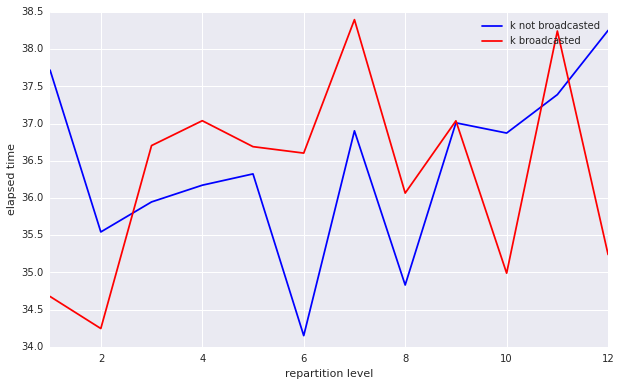

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df_no_broadcasted["repartition"],df_no_broadcasted["avg_elapsed_time"] , '-', c="b")
plt.plot(df_broadcasted["repartition"],df_broadcasted["avg_elapsed_time"] , '-', c="r")
plt.legend(["k not broadcasted", "k broadcasted"])
plt.xlabel('repartition level')
plt.ylabel('elapsed time')
plt.xlim(xmin=1)
plt.show()

<div class="alert alert-success">
Plotting the results we can not observe a significant trend; so it seems that there is not the necessity to big necessity to use an high repartion level. The model seems to be faster when the repartion level is 1 and ks are broadcasted or when ks are not broadcasted and the repartition level is set to 6. However we can not a consistent trend. To be sure that there are not outliers in our trials, we'll compute also the median values between trials, plotting the result.
</div>

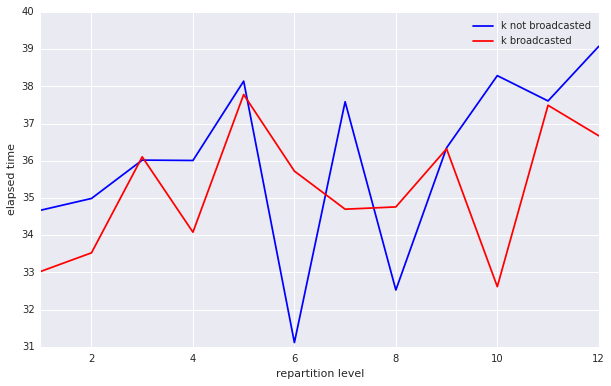

In [5]:
df = pd.read_csv("results_trial.csv")
df = df.groupby(['repartition', "k_broadcast"]).elapsed_time.median().reset_index()
df.columns = ["repartition","k_broadcast","median_elapsed_time"]
df_no_broadcasted=df[(df.k_broadcast == 0)]
df_broadcasted=df[(df.k_broadcast == 1)]
plt.figure(figsize=(10, 6))
plt.plot(df_no_broadcasted["repartition"],df_no_broadcasted["median_elapsed_time"] , '-', c="b")
plt.plot(df_broadcasted["repartition"],df_broadcasted["median_elapsed_time"] , '-', c="r")
plt.legend(["k not broadcasted", "k broadcasted"])
plt.xlabel('repartition level')
plt.ylabel('elapsed time')
plt.xlim(xmin=1)
plt.show()

<div class="alert alert-success">
The results that we have seen looking at the mean seem to be generically confirmed; actually also here it's not possible to see an intersting trend.
<br>
So we can try to compute the kmeans locally using sklearn library KMeans.
</div>

In [4]:
# declare the possible values of K
# declare the possible values of K
from sklearn.cluster import KMeans

ks = [5, 10, 15, 20, 30, 50, 100, 200]

# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1])).cache()
    
def buildModels2(data):
    # declare the collection of models
    Data = data.collect()
    for k in ks:
        models.append(KMeans(k).fit(Data))

    return models
#     return models

time0 = time.time()
for i in range(10):
    models = buildModels2(training_data)
print((time.time() - time0)/10, "seconds")

25.351724457740783 seconds


<div class="alert alert-success">
Computing the KMeans locally, the algorithm takes 25 seconds that is better than the other ways seen until now.
<br>
In conclusion we'll propose an hybrid solution; we'll parallelize the ks vector, and we'll bradcast the data.
</div>

In [5]:
ks = [5, 10, 15, 20, 30, 50, 100, 200]
ks_parallelized = sc.parallelize([5, 10, 15, 20, 30, 50, 100, 200])
df = pd.DataFrame([], columns=['repartition','elapsed_time'])
from sklearn.cluster import KMeans


# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1])).cache()
    
def buildModels2(data):
    # declare the collection of models
    bData = sc.broadcast(data.collect())
    
    models = ks_parallelized.map(lambda k: KMeans(k).fit(bData.value))

    return models.collect()
#     return models
time0 = time.time()
models = buildModels2(training_data)
print((time.time() - time0), "seconds")


15.602588891983032 seconds


<div class="alert alert-success">
This solution seems to be the best one; looking at the plot we can see that . Parallelize our ks, the idea is that for example core A computes the KMeans model for a value of ks, while another core computes the KMeans model for another value of ks. So when we'll have select the best k we can also compute locally the model.
<br>
So below we'll use this last model becuse it is the faster one; let's remember that it uses sklearn KMeans library; if the amount of our data was more, probably it would be better to use Pyspark Kmean model because we'll necessitate different parallelization costraints.

</div>

### d. Testing models & choosing the best one

Next, we evaluate the quality of each model. We use two different error metrics on each of the clusterings. 

* The first is the sum across all time series of the Euclidean distance from the time series to their cluster centroids. 

* The second is a built-in metric of the `KMeansModel` object.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11

<div class="alert alert-info">  

a) Write function `model_error_1` to calculate the sum of Squared Euclidean Distance from the Series objects to their clusters centroids.  

b) Comment the choice of the error function we use here. Is it a good error definition?

</div>

In [3]:
def squared_euclidean_distance(a, b):
    c = a-b
    return c.T.dot(c)


In [7]:
ex_1 = np.array([-4, -3, -2, -1,  0,  1,  2,  3,  4])
ex_2 = np.array([6, -7, -2, -1,  9,  1,  3,  3,  4])

In [8]:
time0 = time.time()
for j in range(1000000):
    np.linalg.norm(ex_1-ex_2)**2
print(time.time() - time0, " seconds (using np method)")

time0 = time.time()
for j in range(1000000):
    squared_euclidean_distance(ex_1, ex_2)
print(time.time() - time0, " seconds (using the other function)")

6.620790719985962  seconds (using np method)
2.141525983810425  seconds (using the other function)


<div class="alert alert-success">
We have reasoned about how to define the function. Based on what we have discovered in the previous lab, the fastest way to compute the squared euclidean distance is `squared_euclidean_distance` function that we have definded above. To be sure about this we have computed it we have tried it also this time for 2 generical arrays, like is showhed in the code above.
<br>
So having decided to use the `squared_euclidean_distance` function, we tried to understand if to broadcast some variable is a good choice. In the code below we defined 3 different possible implementantion  of the function `model_error_1`:
<ol type="A">
  <li> We don't broadcast nothing</li>
  <li> We broadcast the model</li>
  <li> We broadcast the centroids</li>
</ol> 
Below you can see the implementation of these three different options; at the end there are some considerations.
</div>


In [4]:
from operator import add
from scipy.spatial.distance import cdist


def model_error_1_a(data, model):
    centers = model.cluster_centers_
    return data.map(lambda x: squared_euclidean_distance(x, centers[np.argmin(cdist(centers, np.array([x])))])).reduce(add)



In [41]:
time0 = time.time()
model_error_1_a(training_data, models[4])
print(time.time() - time0, "seconds")

0.42150044441223145 seconds


In [95]:
def model_error_1_b(data, model):
    bModel = sc.broadcast(model)
    centers = bModel.value.cluster_centers_
    return data.map(lambda x: squared_euclidean_distance(x, centers[np.argmin(cdist(centers, np.array([x])))])).reduce(add)


In [39]:
time0 = time.time()
model_error_1_b(training_data, models[4])
print(time.time() - time0, "seconds")

0.42005014419555664 seconds


In [96]:
def model_error_1_c(data, model):
    bCenters = sc.broadcast(model.cluster_centers_)
    centers = bCenters.value
    return data.map(lambda x: squared_euclidean_distance(x, centers[np.argmin(cdist(centers, np.array([x])))])).reduce(add)


In [40]:
time0 = time.time()
model_error_1_c(training_data, models[4])
print(time.time() - time0, "seconds")

0.44019389152526855 seconds


<div class="alert alert-success">
It does't seem that to broadcast the centroids is better.
<br>
However, we have noted this, only using the model with 30 centoids. Let's see if using models with a different centroid number changes, the behaviour changes.
</div>

In [43]:

ks = [5, 10, 15, 20, 30, 50, 100, 200]
df = pd.DataFrame([], columns=['option','centroids_number','elapsed_time'])
for j in range(10):
    #print (j)
    for i in range(len(models)):
        model = models[i]
        centroids_number = ks[i]
        time0 = time.time()
        model_error_1_a(training_data, model)
        elapsed_time = time.time() - time0
        df = df.append({'option':"a", 'centroids_number':centroids_number,'elapsed_time':elapsed_time }, ignore_index=True)
        time0 = time.time()
        model_error_1_b(training_data, model)
        elapsed_time = time.time() - time0
        df = df.append({'option':"b", 'centroids_number':centroids_number,'elapsed_time':elapsed_time }, ignore_index=True)
        time0 = time.time()
        model_error_1_c(training_data, model)
        elapsed_time = time.time() - time0
        df = df.append({'option':"c", 'centroids_number':centroids_number,'elapsed_time':elapsed_time }, ignore_index=True)
   
    

In [44]:
df = df.groupby(['option', "centroids_number"]).elapsed_time.mean().reset_index()
df.columns = ["option","centroids_number","avg_elapsed_time"]
df_A=df[(df.option == "a")]
df_B=df[(df.option == "b")]
df_C=df[(df.option == "c")]

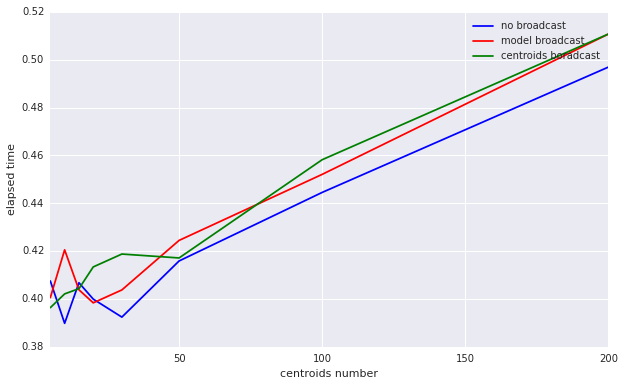

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(df_A["centroids_number"],df_A["avg_elapsed_time"] , '-', c="b")
plt.plot(df_B["centroids_number"],df_B["avg_elapsed_time"] , '-', c="r")
plt.plot(df_C["centroids_number"],df_C["avg_elapsed_time"] , '-', c="g")
plt.legend(["no broadcast", "model broadcast","centroids boradcast"])
plt.xlabel('centroids number')
plt.ylabel('elapsed time')
plt.xlim(xmin=5)
plt.show()

<div class="alert alert-success">
We can confirm what we have noted before: actually it seems that it's bettter to not broadcast the centroids also when they are more. For all three methods the computation time logically increases when the number of centroids is bigger.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

a) Write function `model_error_2` to calculate the total of similarity of `Series` objects based on how well they match the cluster they belong to, and then calculate the error by inverse the total similarity.  

b) Similarly to the previous question, comment the choice of the similarity function.  

</div>

In [24]:
# calculate the total of similarity of the model on timeseries objects
# and calculate the error by inverse the total similarity

# Estimate similarity between a data point and the cluster it belongs to.
def similarity(centers, p):
    if np.std(p) == 0:
        return 0
    return np.corrcoef(centers[np.argmin(cdist(centers, np.array([p])))], p)[0, 1]


def model_error_2(data, model):
    bCenters = sc.broadcast(model.cluster_centers_)
    return 1. / data.map(lambda x: similarity(bCenters.value, x)).reduce(add)


<div class="alert alert-success">
The numpy `corrcoef` funciton uses Pearson product-moment correlation coefficients that has the variance at the 
denominator. If variance is equal to 0 this means that also std is equal to 0; for this reason, the similarity of voxels with null standard deviation is considered to be 0.
However this could be a drawback. In fact this means that our error (that is the inverse of the similarity sum) will increase for every voxel with null standard deviation. This doesn't seem good because supposing to have 2 identical voxels with standard deviation null, they will be put in the same cluster because they have the same behaviour. So also if they are in the same cluster, we consider the similarity to be 0 and we assign them an high error. If we don't want to keep into account this voxels with null standard deviation is better to delete them from the data before training the model rather than to affect our error estimation. This will be done in the second part of the notebook.
</div>

In [45]:
training_data_filtered = training_data.filter(lambda x: x.std() > 0)
print("Error estimation using the second metric: "+str(model_error_2(training_data_filtered, models[4])))
print("Error estimation using the second metric not considering voxels with null: "+str(model_error_2(training_data, models[4])))

Error estimation using the second metric: 0.000175439595051
Error estimation using the second metric not considering voxels with null: 0.000175439595051


<div class="alert alert-success">
To fix this problem we research about better similarities metrics we discovered the Dynamic time warping and we have red that one of the best similarity metrics used for time series images. We have found an implementation of the Dynamic time warping using numpy [here](http://docs.thunder-project.org/). Below an example.
</div>

In [ ]:
!pip install dtaidistance


In [6]:
from dtaidistance import dtw
s1 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
s2 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
s3 = [3, 0, 0, 3, 0, 0, 4, 0, 0]
distance = dtw.distance(s1, s2)
print(distance)
distance = dtw.distance(s1, s3)
print(distance)


0.0
5.830951894845301


<div class="alert alert-success">
As we can see the method does't offer a measure similarity, but directly of dissimiarity so we don't need to invert the total similarity. In this case the null std is not a problem. Below we have copied the library code that is useful for us because we have not the permission to install it(the function `dissimilarity_DTW`).
</div>

In [7]:

def dissimilarity_DTW(s1, s2, window=None, max_dist=None,
             max_step=None, max_length_diff=None, penalty=None,
             use_nogil=False):
    """
    Dynamic Time Warping (keep compact matrix)
    :param s1: First sequence
    :param s2: Second sequence
    :param window: Only allow for shifts up to this amount away from the two diagonals
    :param max_dist: Stop if the returned values will be larger than this value
    :param max_step: Do not allow steps larger than this value
    :param max_length_diff: Return infinity if length of two series is larger
    :param penalty: Penalty to add if compression or expansion is applied
    :param use_nogil: Use fast pure c compiled functions
    Returns: DTW distance
    """
    if use_nogil:
        return distance_fast(s1, s2, window,
                             max_dist=max_dist,
                             max_step=max_step,
                             max_length_diff=max_length_diff,
                             penalty=penalty)
    r, c = len(s1), len(s2)
    if max_length_diff is not None and abs(r - c) > max_length_diff:
        return np.inf
    if window is None:
        window = max(r, c)
    if not max_step:
        max_step = np.inf
    else:
        max_step *= max_step
    if not max_dist:
        max_dist = np.inf
    else:
        max_dist *= max_dist
    if not penalty:
        penalty = 0
    else:
        penalty *= penalty
    length = min(c + 1, abs(r - c) + 2 * (window - 1) + 1 + 1 + 1)
    # print("length (py) = {}".format(length))
    dtw = np.full((2, length), np.inf)
    dtw[0, 0] = 0
    last_under_max_dist = 0
    skip = 0
    i0 = 1
    i1 = 0
    for i in range(r):
        # print("i={}".format(i))
        # print(dtw)
        if last_under_max_dist == -1:
            prev_last_under_max_dist = np.inf
        else:
            prev_last_under_max_dist = last_under_max_dist
        last_under_max_dist = -1
        skipp = skip
        skip = max(0, i - max(0, r - c) - window + 1)
        i0 = 1 - i0
        i1 = 1 - i1
        dtw[i1, :] = np.inf
        if dtw.shape[1] == c + 1:
            skip = 0
        for j in range(max(0, i - max(0, r - c) - window + 1), min(c, i + max(0, c - r) + window)):
            d = (s1[i] - s2[j])**2
            if d > max_step:
                continue
            assert j + 1 - skip >= 0
            assert j - skipp >= 0
            assert j + 1 - skipp >= 0
            assert j - skip >= 0
            dtw[i1, j + 1 - skip] = d + min(dtw[i0, j - skipp],
                                            dtw[i0, j + 1 - skipp] + penalty,
                                            dtw[i1, j - skip] + penalty)
            # print('({},{}), ({},{}), ({},{})'.format(i0, j - skipp, i0, j + 1 - skipp, i1, j - skip))
            # print('{}, {}, {}'.format(dtw[i0, j - skipp], dtw[i0, j + 1 - skipp], dtw[i1, j - skip]))
            # print('i={}, j={}, d={}, skip={}, skipp={}'.format(i,j,d,skip,skipp))
            # print(dtw)
            if dtw[i1, j + 1 - skip] <= max_dist:
                last_under_max_dist = j
            else:
                # print('above max_dist', dtw[i1, j + 1 - skip], i1, j + 1 - skip)
                dtw[i1, j + 1 - skip] = np.inf
                if prev_last_under_max_dist + 1 - skipp < j + 1 - skip:
                    # print("break")
                    break
        if last_under_max_dist == -1:
            # print('early stop')
            # print(dtw)
            return np.inf
    return math.sqrt(dtw[i1, min(c, c + window - 1) - skip])

In [105]:
def model_error_3(data, model):
    bCenters = sc.broadcast(model.cluster_centers_)
    centers = bCenters.value
    return data.map(lambda x: dissimilarity_DTW(centers[np.argmin(cdist(centers, np.array([x])))], x)).reduce(add)


In [46]:

ks = [5, 10, 15, 20, 30, 50, 100, 200]
df = pd.DataFrame([], columns=['centroids_number','elapsed_time'])
for j in range(10):
    for i in range(len(models)):
        model = models[i]
        centroids_number = ks[i]
        time0 = time.time()
        error = model_error_3(training_data,model)
        elapsed_time = time.time() - time0
        df = df.append({ 'centroids_number':centroids_number,'error':error,'elapsed_time':elapsed_time }, ignore_index=True)
    
df = df.groupby(['centroids_number', "error"]).elapsed_time.mean().reset_index()

df.to_csv("new_method_evaluation.csv",index=False)

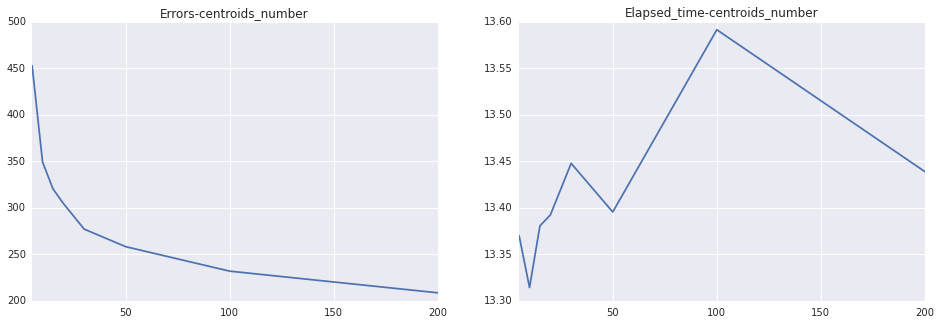

In [47]:
df = pd.read_csv("new_method_evaluation.csv")
df.columns = ['centroids_number','error','elapsed_time_avg']

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(df["centroids_number"],df["error"] , '-')
plt.title("Errors-centroids_number")
plt.xlim(xmin=5)
plt.subplot(122)
plt.plot(df["centroids_number"],df["elapsed_time_avg"] , '-')
plt.title("Elapsed_time-centroids_number")
plt.xlim(xmin=5)
plt.show()

<div class="alert alert-success">
Here we can see that also using the new error metric the error decreases when the centroid number increases; this make sense thinking how the kmeans works, so the metric seems correct.  A big drawback is that it takes a lot of time to compute the error respect to the other methods.  
</div>

#### Question 13
<div class="alert alert-info">

Plot the error of the models along with the different values of K in term of different error metrics above. From the figure, in your opinion, what is the best value for `K` ? Why ?

</div>

In [101]:
def testAndPlotTheResult(data, models):
    # compute the error metrics for the different resulting clusterings
    
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray([model_error_1_a(data, model) for model in models])
    
    # error of models when using similarity
    errors_2 = np.asarray([model_error_2(data, model) for model in models])
    
    # error of models when using dissimilarity_DTW
    errors_3 = np.asarray([model_error_3(data, model) for model in models])

    # plot the errors with each value of K
    plt.figure(figsize=(10, 6))
    plt.plot(
        ks, errors_1 / errors_1.sum(), 'k-o',
        ks, errors_2 / errors_2.sum(), 'b:v',
        ks, errors_3 / errors_3.sum(), 'r:v' )
    plt.legend(["model error 1", "model error 2","model error 3"])
    plt.xlabel('clusters number')
    plt.ylabel('error')
    plt.show()


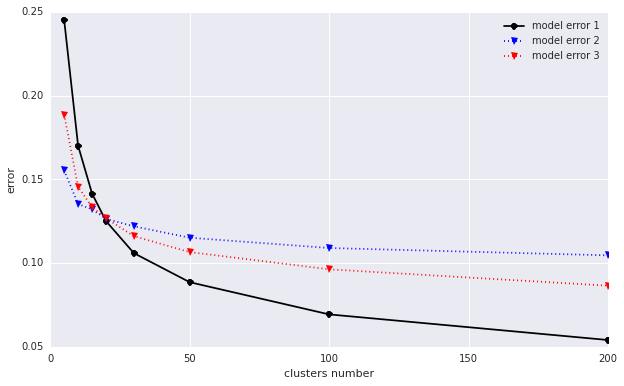

In [60]:
ks = [5, 10, 15, 20, 30, 50, 100, 200]
testAndPlotTheResult(training_data, models)

<div class="alert alert-success">
It's also important to note that the correlation works well when there are a  lot of samples; however our voxels are composed only by 20 temporal pixel values so his potetial is reduced. Instead the mean square error metric is less precise but more generalizable also when we have less samples.
The error computed by the second metric seems to remain pretty constant when we pass from 100 to 200 clusters and also using the first metric and the third one the improvement seems to be low. In this case it's difficult to see an "elbow", there is one smooth near 20. The error computed using the dissimilarity metric that we have introduced seems to be in the middle between the others.
For sure one good criteria to evaluate the clusterization is to compute the silhouette. We'll do this in the code below to understand which is the best k.
</div>

For n_clusters = 5 The average silhouette_score is : 0.52604394358


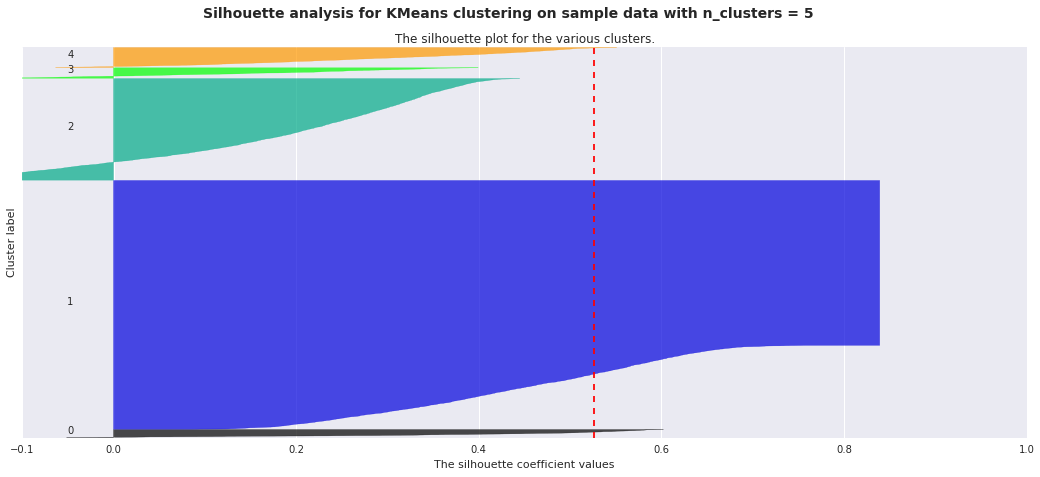

For n_clusters = 10 The average silhouette_score is : 0.479667350936


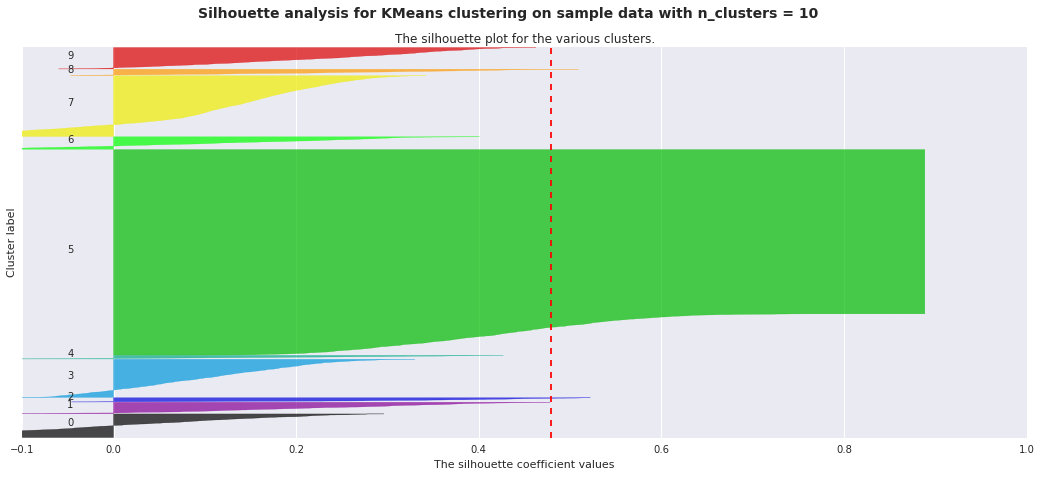

For n_clusters = 15 The average silhouette_score is : 0.467342254561


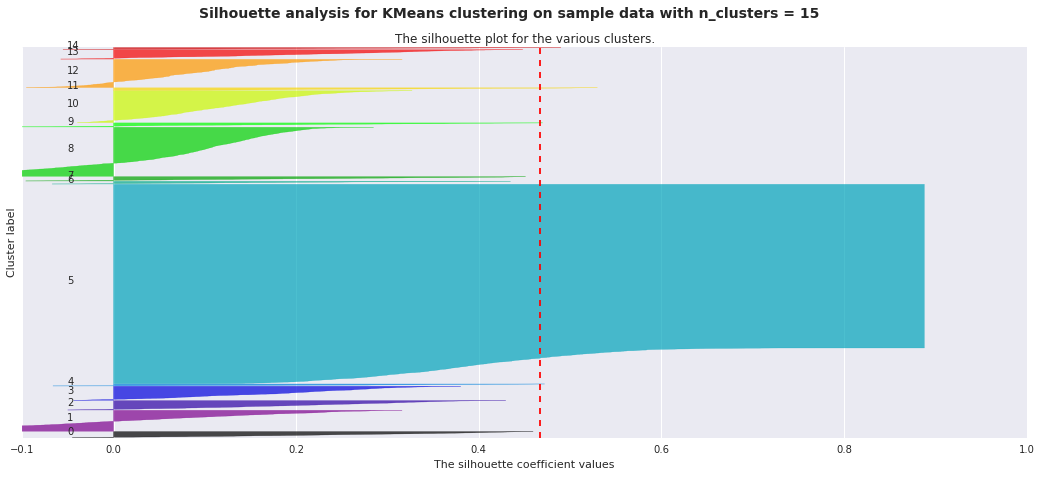

For n_clusters = 20 The average silhouette_score is : 0.469859022345


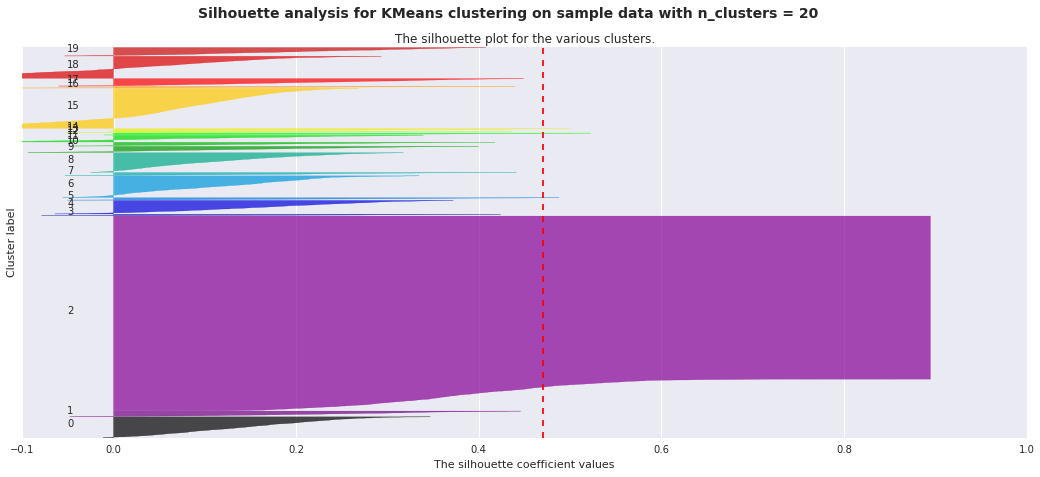

For n_clusters = 30 The average silhouette_score is : 0.463076078677


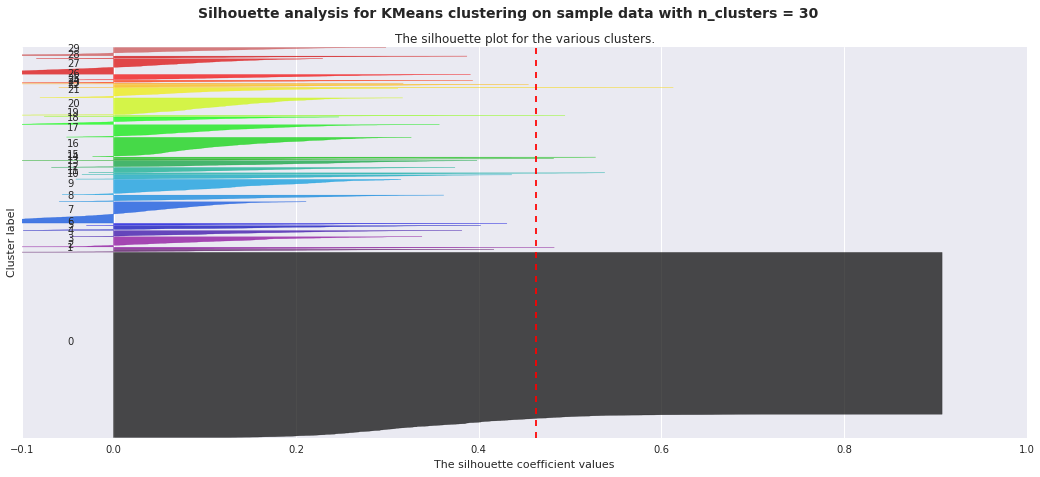

For n_clusters = 50 The average silhouette_score is : 0.467478663913


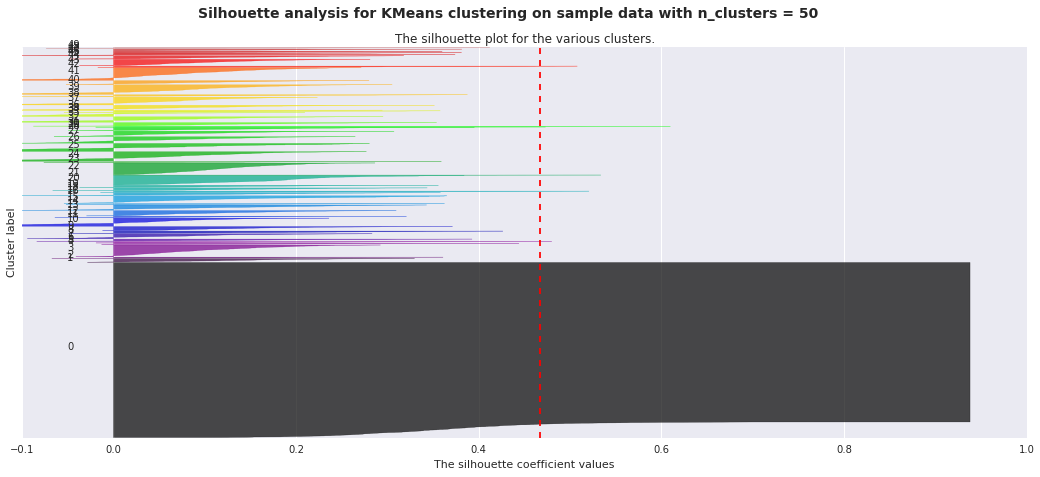

For n_clusters = 100 The average silhouette_score is : 0.468034427051


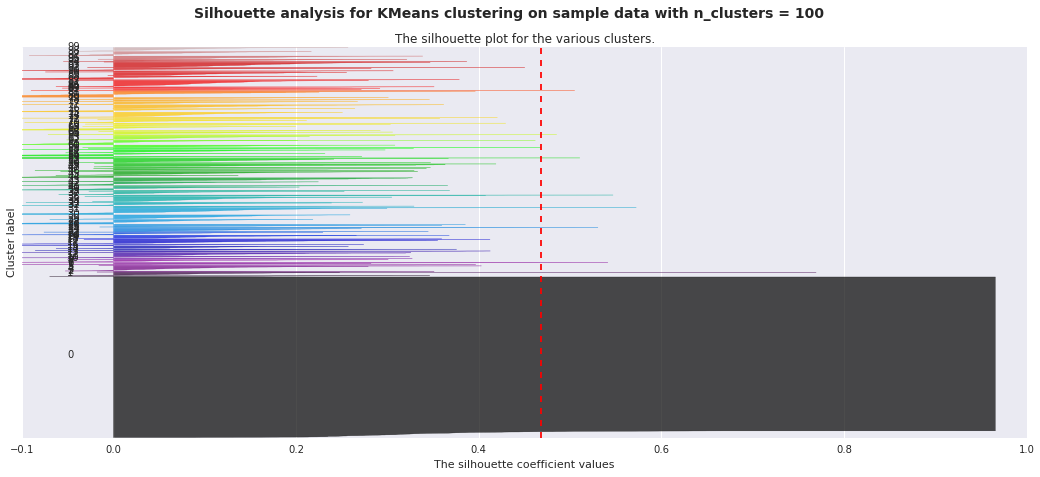

For n_clusters = 200 The average silhouette_score is : 0.480466527731


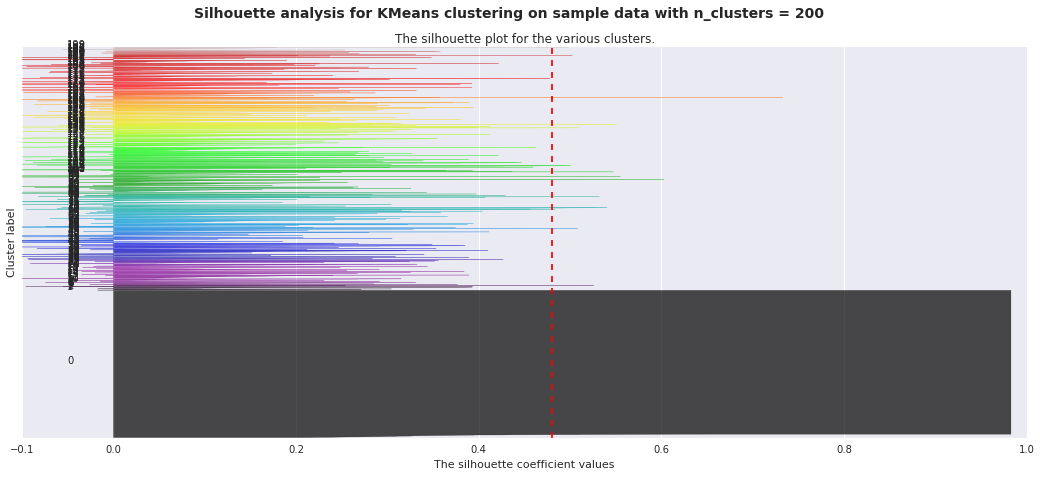

In [6]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


#print(__doc__)


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = np.array(training_data.collect())

range_n_clusters = [5, 10, 15, 20, 30, 50, 100, 200]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    
    

    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

<div class="alert alert-success">
We can note that one cluster seems to be weel seaparted by the others but the others are similar. This cluster is probably the black one. In fact when we'll filter out the voxels with null standard deviation, it will disappear. Actually also looking at the silhouette it's not clear which is the best number of clusters.
However we have chosen for the moment 20 because until 20 the improvement is big and the number of wrong clusterizations is not too hight, and because we have noted a small 'elbow' in the error plot.
</div>

Determining the optimal $k$ is particularly troublesome for the $k$-Means algorithm because error measures based on distance decrease monotonically as $k$ increases. This arises because when $k$ is increased, each cluster is decomposed into more and more clusters, such that each point becomes closer to its cluster mean. In fact, in the extreme case where $k=N$, each point will be assigned to its own cluster, and all distances are reduced to nil. Cross-validation or using holdout data is also unlikely to be particularly effective in this case.<br>

To this end, it is often worth assessing a model by measuring its impact on the overall aim of carrying out the clustering. For example, if we are carrying out $k$-means for grouping customers having similar taste and purchase history with the ultimate intent of making recommendations to customers, our objective function should measure how effective the recommendations are (perhaps using holdout data). An appealing aspect of using such a metric is that it is no longer guaranteed to behave monotonically with respect to $k$. We shall investigate this further in Question 20.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Plot the centroids of the best model. Do you think that the result is good ?

</div>

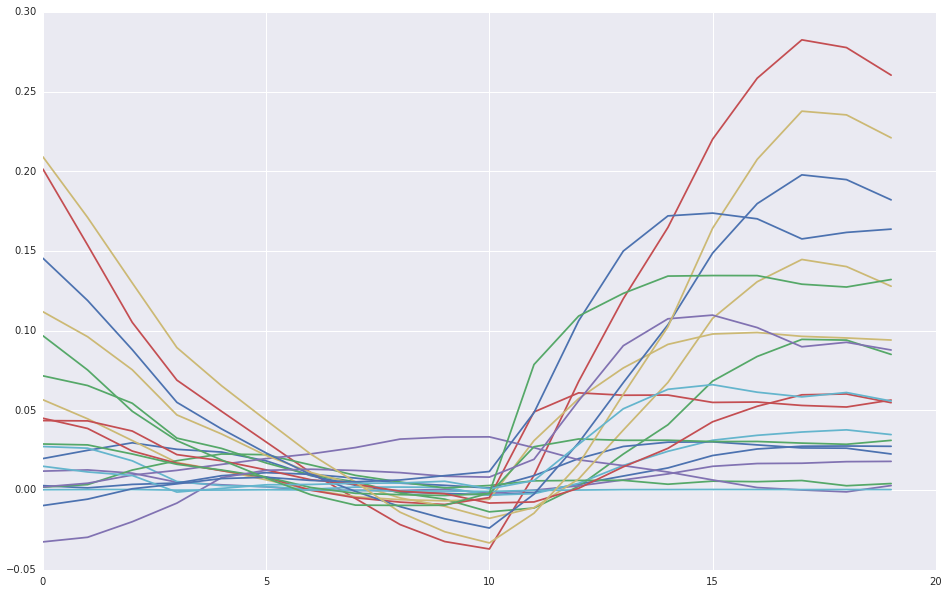

In [24]:
bestModel = models[3]
centroids = bestModel.cluster_centers_
plt.figure(figsize=(16, 10))
for i in range(len(centroids)):
    plt.plot(centroids[i])
plt.show()

<div class="alert alert-success">
Looking at the graph we can note that there are are some centroids with a similar behaviour, so they are probably near. To understand which are the most similar centroids will use the euclidean distance.
</div>

In [25]:
#squared_euclidean_distance(x, centers[np.argmin(cdist(centers, np.array([x])))])

def choose_iter(elements, length):
    for i in range(len(elements)):
        if length == 1:
            yield (elements[i],)
        else:
            for next in choose_iter(elements[i+1:len(elements)], length-1):
                yield (elements[i],) + next



In [26]:
df = pd.DataFrame([], columns=['centroid_1','centroid_2','distance'])
for p in choose_iter(range(len(centroids)), 2):
    c1,c2 = p
    distance = squared_euclidean_distance(centroids[c1],centroids[c2])
    df = df.append({'centroid_1':str(c1), 'centroid_2':str(c2),'distance':distance }, ignore_index=True)

  
df = df.sort(['distance'], ascending=[1])
df.to_csv("centroids_distance.csv",index=False)


In [ ]:
df = pd.read_csv("centroids_distance.csv")
table = ListTable()
df_tuples = [tuple(x) for x in df.to_records(index=False)]
table = ListTable()
table.append(['centroid_1','centroid_2','distance'])
for t in df_tuples:
    table.append(t)


<div class="alert alert-success">
As we can see looking at the table, there are some centroids that seem  near. So let's plot the nearest ones centroids pairs.
</div>

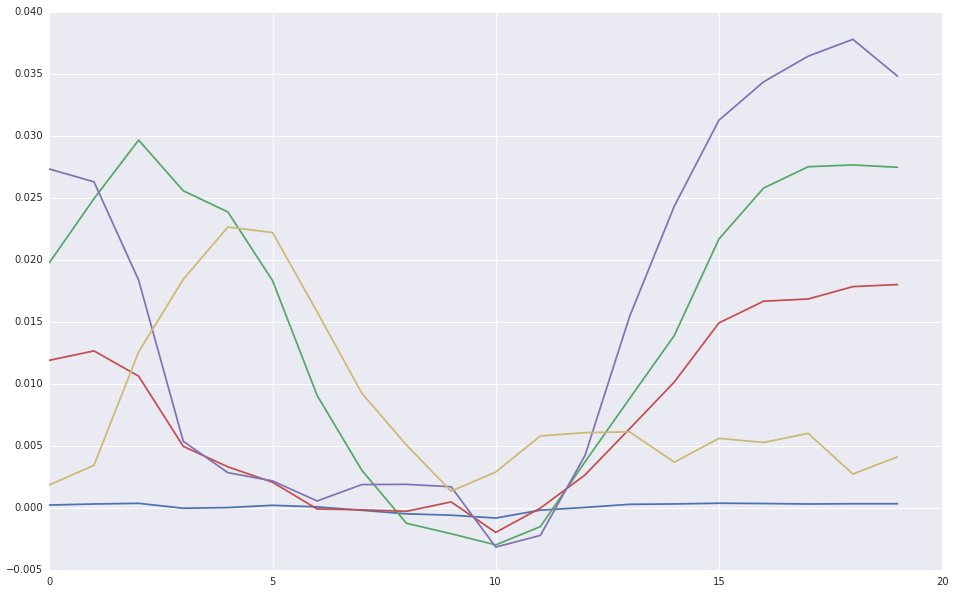

In [28]:
near_centroids_indexes = []
for i in range(3):
    near_centroids_indexes.append(df['centroid_1'][i])
    near_centroids_indexes.append(df['centroid_2'][i])
    
near_centroids_indexes = list(set(near_centroids_indexes))
plt.figure(figsize=(16, 10))
for x in near_centroids_indexes:
    plt.plot(centroids[x])
plt.show()

<div class="alert alert-success">
Looking at the nearest centroids, we can see that there are some centroids with a similar trend, especially in some parts of trend.
As example, the green and the red trends are similar from 10 to 15, and the green and the yellow trends between 5 and 10.
</div>

### e. Visualizing the result
We can also plot an image of labels of neurons, such that we can visualize the group of each neuron.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 15

<div class="alert alert-info">

Complete the source code below to visualize the result of clustering.

</div>

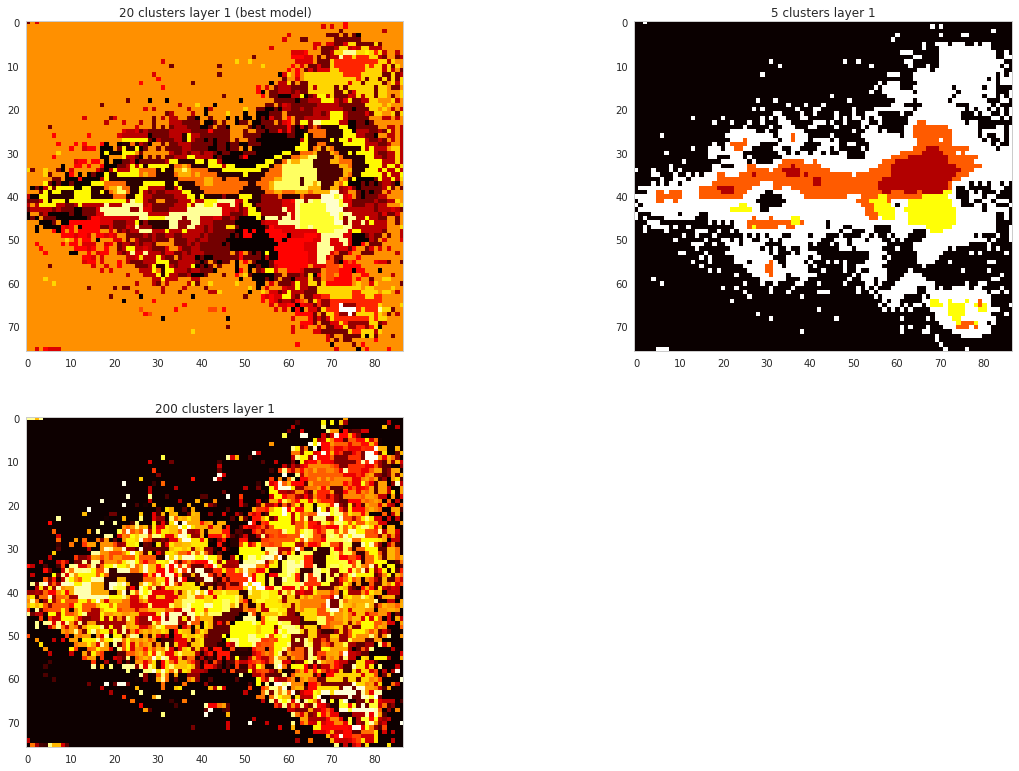

In [32]:
# predict the nearest cluster id for each voxel in Series
bestModel = models[3]
firstModel = models[0]
lastModel = models[7]

models_to_plot = [bestModel,firstModel,lastModel]
titles = ["20 clusters layer 1 (best model)","5 clusters layer 1","200 clusters layer 1"]
images_to_plot = []
for m in models_to_plot:
    labels = data.map(lambda x: m.predict(x))

    # collect data to the driver
    imgLabels = labels.toarray().reshape(2, 76, 87)
    
    # consider the voxels of the first layer
    images_to_plot.append(imgLabels[0, :, :])

sns.set_style("whitegrid", {'axes.grid' : False})
plot_image(images_to_plot,titles,cmap = "hot")

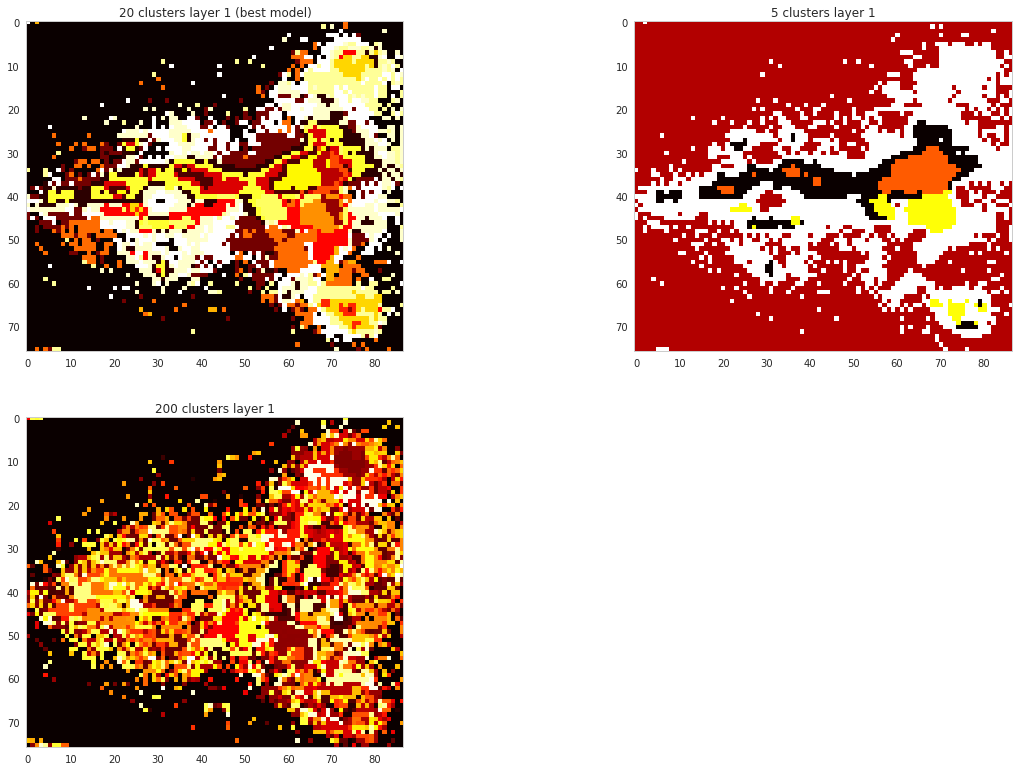

In [21]:
# predict the nearest cluster id for each voxel in Series
bestModel = models[3]
firstModel = models[0]
lastModel = models[7]

models_to_plot = [bestModel,firstModel,lastModel]
titles = ["20 clusters layer 1 (best model)","5 clusters layer 1","200 clusters layer 1"]
images_to_plot = []
for m in models_to_plot:
    labels = data.map(lambda x: m.predict(x))

    # collect data to the driver
    imgLabels = labels.toarray().reshape(2, 76, 87)
    
    # consider the voxels of the first layer
    images_to_plot.append(imgLabels[0, :, :])

sns.set_style("whitegrid", {'axes.grid' : False})
plot_image(images_to_plot,titles,cmap = "hot")

<div class="alert alert-success">
Here some plots changing the number of clusters. The top left image shows the case that we considered the best, in which the number of clusters is 20. In this graph it seems that some internavl pixels has the same color of the background ones, that rapresent the noise. This is the princial reason why we'll filter the noise.
<br>
The other 2 images show the exterme cases in which we select K=5 or K=200; it seems clear that in the first case the number of labels is too low (not enough discriminace) and in the second case is too high (it's like not clustering).
</div>

With the default color scheme, this figure is quite difficult to understand and to distinguish the groups according to their similar colors. So, we should have a smater color selection. The fact is, when we do clustering, it is often the case that some centers are more similar to one another, and it can be easier to interpret the results if the colors are choosen based on these relative similarities. The method `optimize` tries to find a set of colors such that similaries among colors match similarities among an input array (in this case, the cluster centers). The optimization is non-unique, so you can run multiple times to generate different color schemes.

In [114]:
from numpy import arctan2, sqrt, pi, abs, dstack, clip, transpose, inf, \
    random, zeros, ones, asarray, corrcoef, allclose, maximum, add, multiply, \
    nan_to_num, copy, ndarray, around, ceil, rollaxis

# these functions below are inspired mainly from Thunder-Project source code, v.0.6
# url: https://raw.githubusercontent.com/thunder-project/thunder/branch-0.6/thunder/viz/colorize.py

# Optimal colors based on array data similarity.
def optimize_color(mat):
        mat = np.asarray(mat)

        if mat.ndim < 2:
            raise Exception('Input array must be two-dimensional')

        nclrs = mat.shape[0]

        from scipy.spatial.distance import pdist, squareform
        from scipy.optimize import minimize

        distMat = squareform(pdist(mat, metric='cosine')).flatten()

        optFunc = lambda x: 1 - np.corrcoef(distMat, squareform(pdist(x.reshape(nclrs, 3), 'cosine')).flatten())[0, 1]
        init = random.rand(nclrs*3)
        bounds = [(0, 1) for _ in range(0, nclrs * 3)]
        res = minimize(optFunc, init, bounds=bounds, method='L-BFGS-B')
        newClrs = res.x.reshape(nclrs, 3).tolist()

        from matplotlib.colors import ListedColormap

        newClrs = ListedColormap(newClrs, name='from_list')

        return newClrs

# Blend two images together using the specified operator.
def blend(img, mask, op=add):
        if mask.ndim == 3:
            for i in range(0, 3):
                img[:, :, :, i] = op(img[:, :, :, i], mask)
        else:
            for i in range(0, 3):
                img[:, :, i] = op(img[:, :, i], mask)
        return img

def _prepareMask(mask):
        mask = asarray(mask)
        mask = clip(mask, 0, inf)

        return mask / mask.max()
    
# Colorize numerical image data.
def transform(cmap, img, mask=None, mixing=1.0):
        from matplotlib.cm import get_cmap
        from matplotlib.colors import ListedColormap, LinearSegmentedColormap, hsv_to_rgb, Normalize

        img = asarray(img)
        dims = img.shape

        if cmap not in ['polar', 'angle']:

            if cmap in ['rgb', 'hv', 'hsv', 'indexed']:
                img = copy(img)
                for i, im in enumerate(img):
                    norm = Normalize(vmin=None, vmax=None, clip=True)
                    img[i] = norm(im)

            if isinstance(cmap, ListedColormap) or isinstance(cmap, str):
                norm = Normalize(vmin=None, vmax=None, clip=True)
                img = norm(copy(img))

        if mask is not None:
            mask = _prepareMask(mask)

        if isinstance(cmap, ListedColormap):
            if img.ndim == 3:
                out = cmap(img)
                out = out[:, :, :, 0:3]
            if img.ndim == 2:
                out = cmap(img)
                out = out[:, :, 0:3]
        else:
            raise Exception('Colorization method not understood')

        out = clip(out, 0, 1)

        if mask is not None:
            out = blend(out, mask, multiply)

        return clip(out, 0, 1)


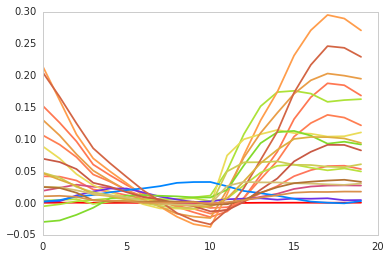

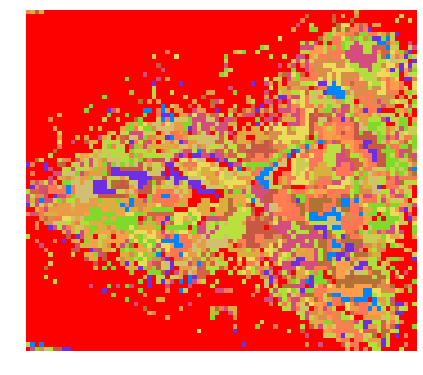

In [28]:

# generate the better color scheme
newClrs = optimize_color(bestModel.cluster_centers_)
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(np.array(bestModel.cluster_centers_).T);

# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0,:,:])
draw_image(brainmap)

### f. Improving the result by removing noise
One problem with what we've done so far is that clustering was performed on all time-series without data pre-processing. Many of  time-series objects were purely noise (e.g. those outside the brain), and some of the resulting clusters capture these noise signals. A simple trick is to perform clustering after subselecting pixels based on the standard deviation of their time series. First, let's look at a map of the standard deviation, to find a reasonable threshold that preserves most of the relavant signal, but ignores the noise.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 16

<div class="alert alert-info">

Try with different threshold of standard deviation to filter the noise. What is the "best value" that preserves most of the relavant signal, but ignores the noise ? Why ?

</div>

<div class="alert alert-success">
Based on what we have seen before, we know that a good value should be comprised between 0.01 and 0.02; so we'll try different values between these quantities.
</div>

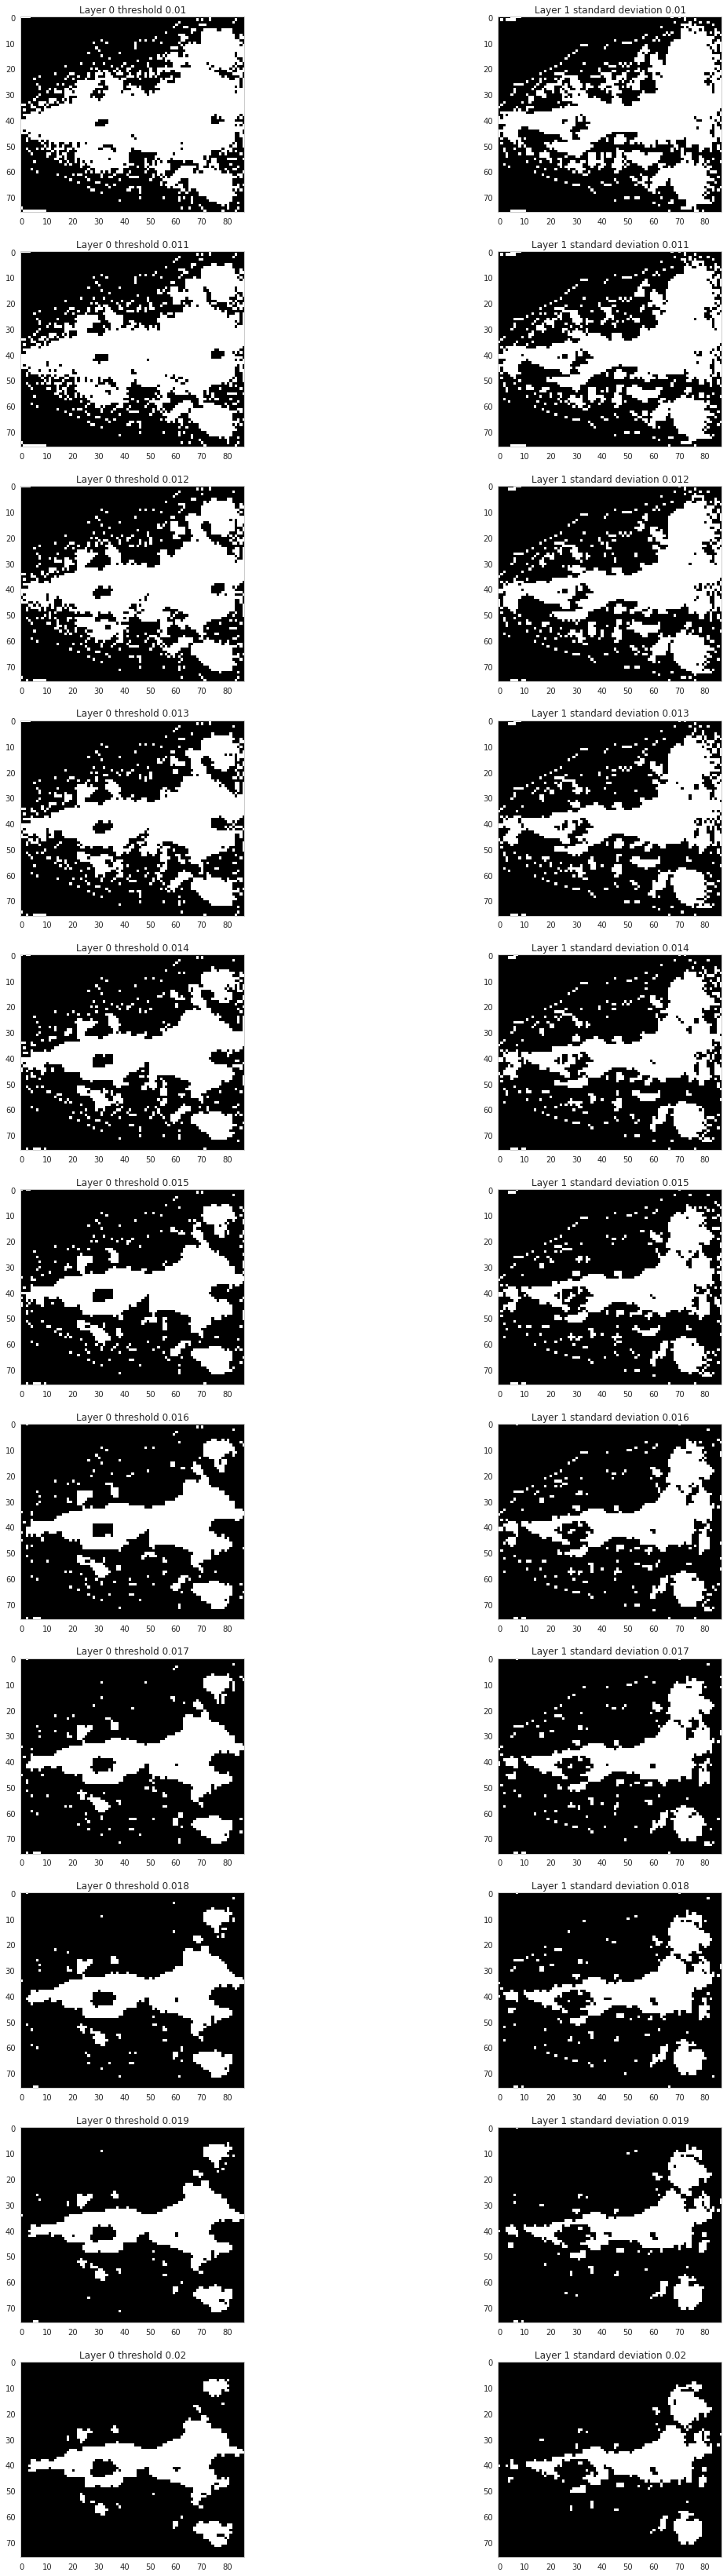

In [33]:
thresholds = [0.01,0.011,0.012,0.013,0.014,0.015,0.016,0.017,0.018,0.019,0.02]
sns.set_style("whitegrid", {'axes.grid' : False})

stdMap = data.map(lambda x: x.std()).toarray().reshape(2, 76, 87)

std_imgs = []
titles = []

for threshold in thresholds:
    titles.append("Layer 0 threshold "+str(threshold))
    titles.append("Layer 1 standard deviation "+str(threshold))
    std_imgs.append(stdMap[0,:,:] > threshold)
    std_imgs.append(stdMap[1,:,:] > threshold)


plot_image(std_imgs,titles)



<div class="alert alert-success">
We know that the Zebrafish brain should be like this:
<br>
<img src="https://i.ytimg.com/vi/YLVdRPVj-XM/maxresdefault.jpg" alt="Brain fish" style="height:228px;">
<br>
Actually we don't have the left part of the image in our image. However we should try to preserve this shape. Comparing it with the images that we have printed above, we have set a threshold between 0.013-0.014 because it is the one that seems better removing the noise, preserving the brain information.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 17

<div class="alert alert-info">

Filter your data such that we only keep the voxels that have the standard deviation bigger than the threshold in question 16.

</div>

In [15]:
from numpy import std
threshold = 0.0135
# remove series object that has the standard deviation bigger than a threshold
filtered = data.filter(lambda x: x.std() > threshold).cache()
print(filtered.shape)

(4197, 20)


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 18

<div class="alert alert-info">

Re-train and choose the best models with different values of `K` on the new data.

</div>

In [16]:
training_data = filtered.tordd().map(lambda x: np.array(x[1])).cache()
models = buildModels2(training_data)

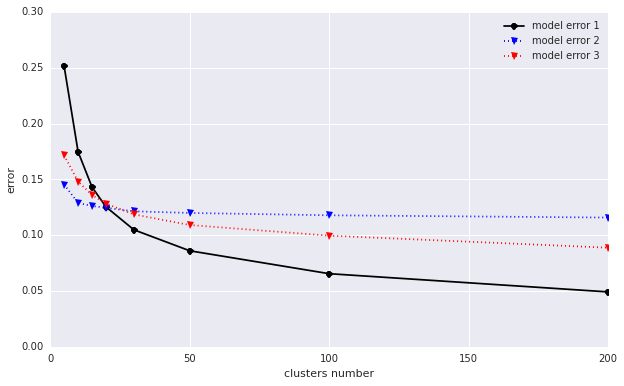

In [33]:
ks = [5, 10, 15, 20, 30, 50, 100, 200]
sns.set_style("darkgrid", {'axes.grid' : True})
testAndPlotTheResult(training_data, models)

<div class="alert alert-success">
Also after filtering, it seems very difficult to choose the right number of clusters. We have the same same impression as before: there is a small "elbow" between 20-25. However we'll try to compute the silhouette also now, trying to be more focused in the zone in whcih the cluster numbers is between 20 and 25.
</div>

For n_clusters = 3 The average silhouette_score is : 0.426755895435


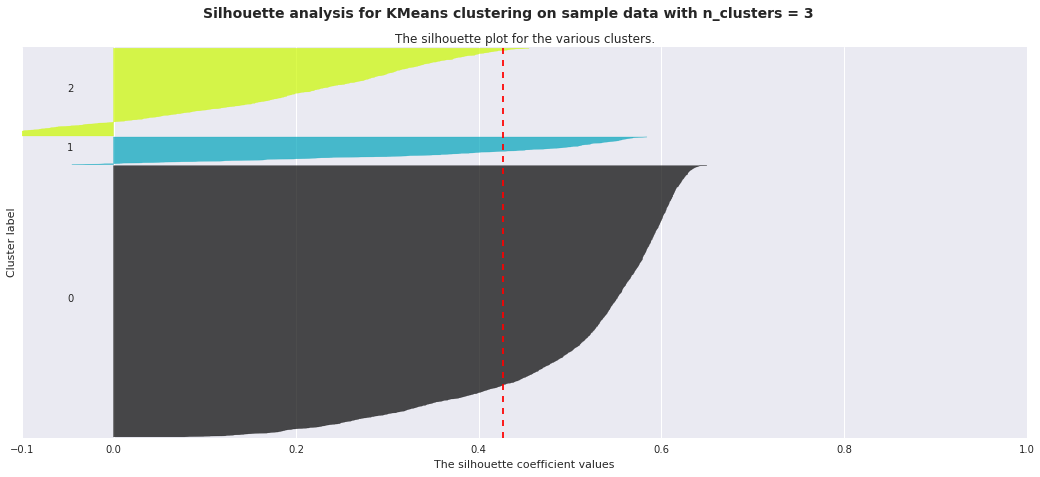

For n_clusters = 4 The average silhouette_score is : 0.419265982158


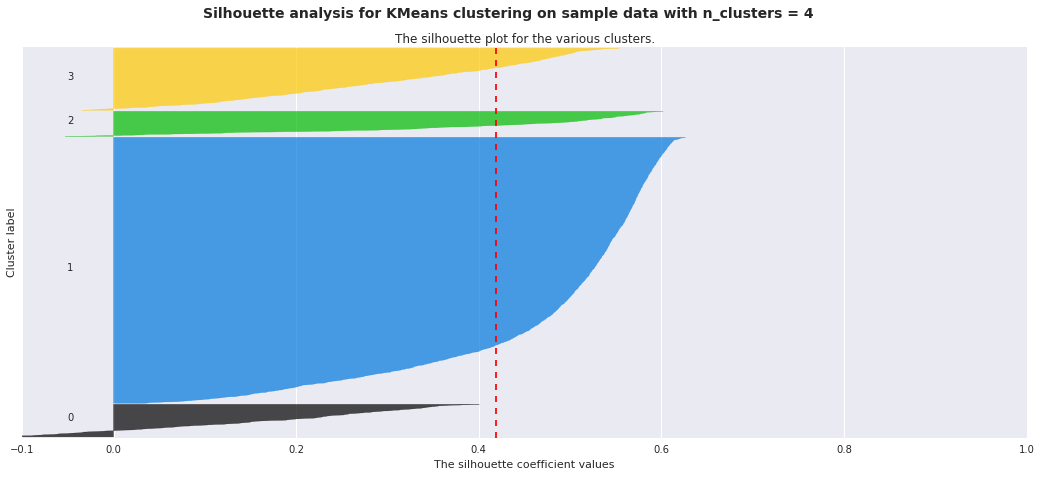

For n_clusters = 5 The average silhouette_score is : 0.276862299552


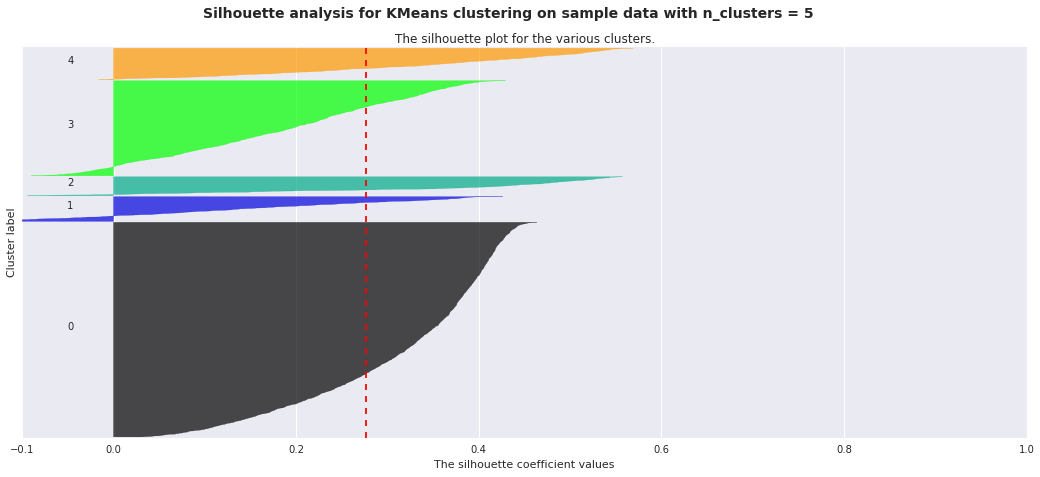

For n_clusters = 10 The average silhouette_score is : 0.211529726863


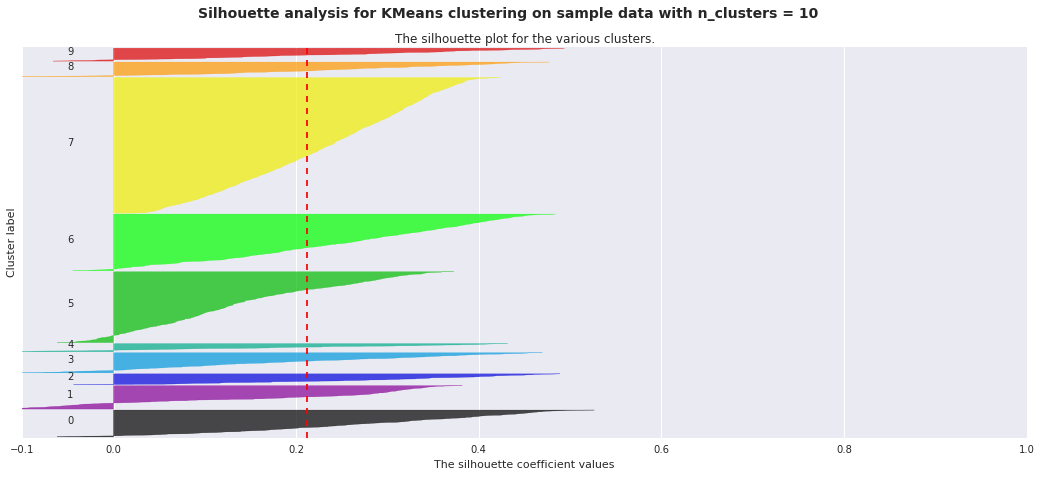

For n_clusters = 15 The average silhouette_score is : 0.166749126859


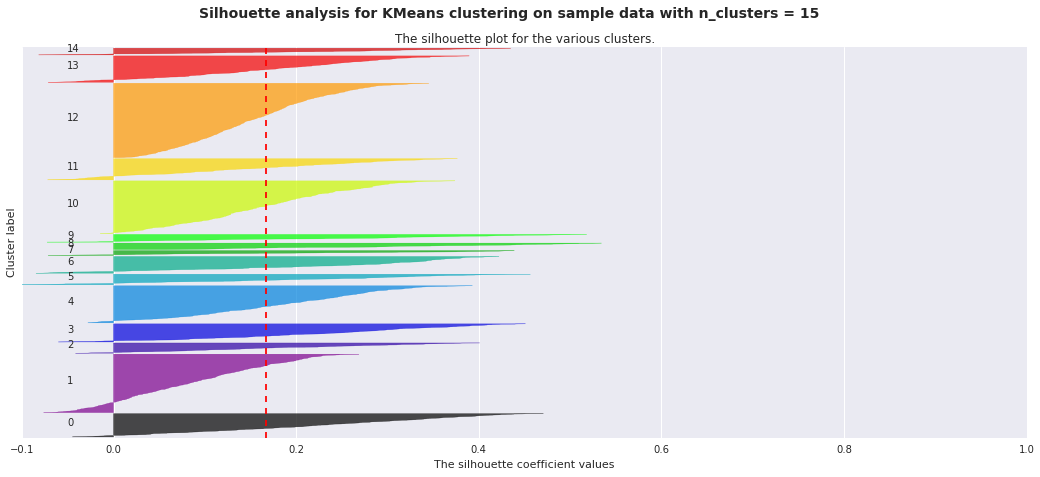

For n_clusters = 20 The average silhouette_score is : 0.16680160991


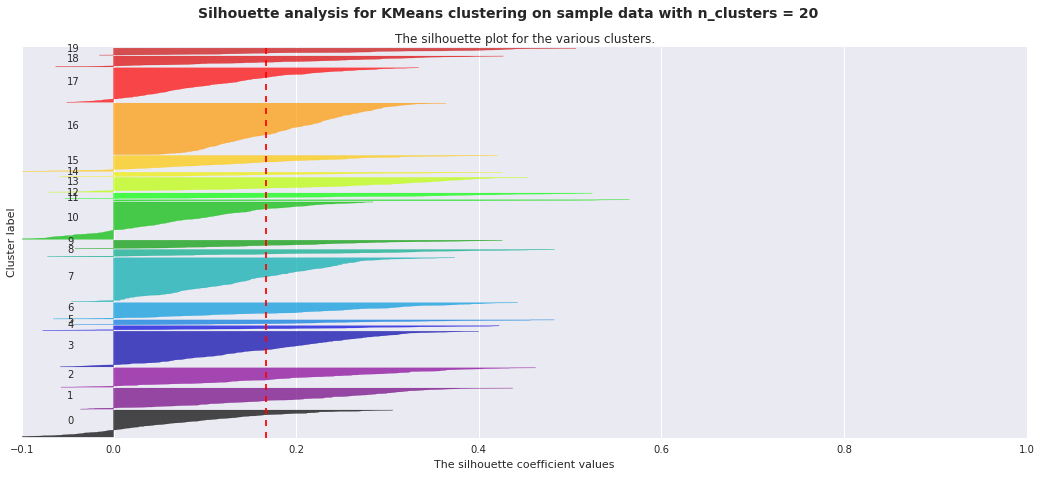

For n_clusters = 21 The average silhouette_score is : 0.164651236863


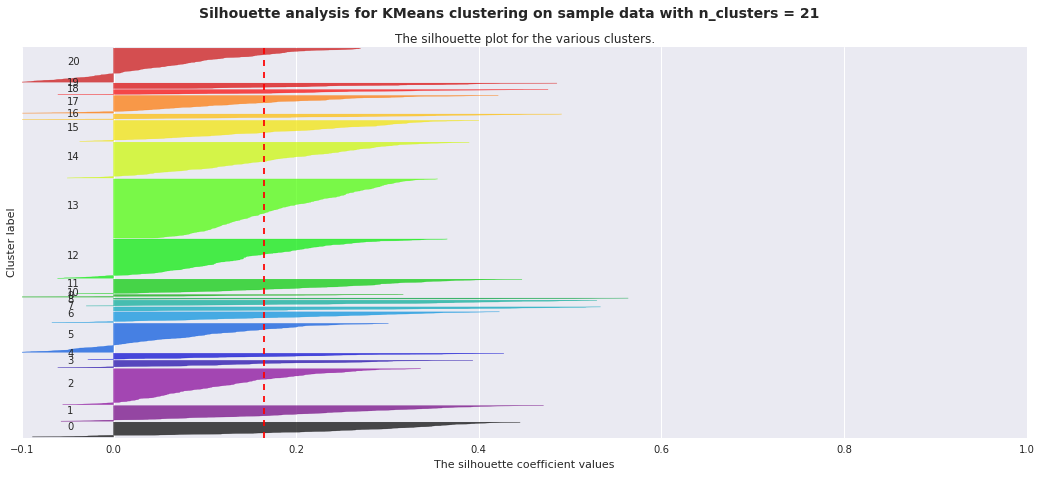

For n_clusters = 22 The average silhouette_score is : 0.1592390101


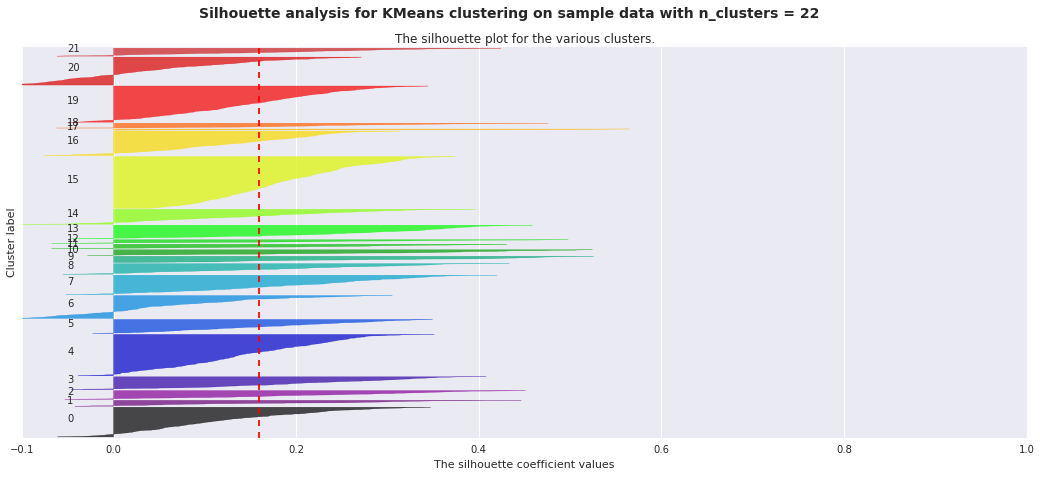

For n_clusters = 23 The average silhouette_score is : 0.158987460281


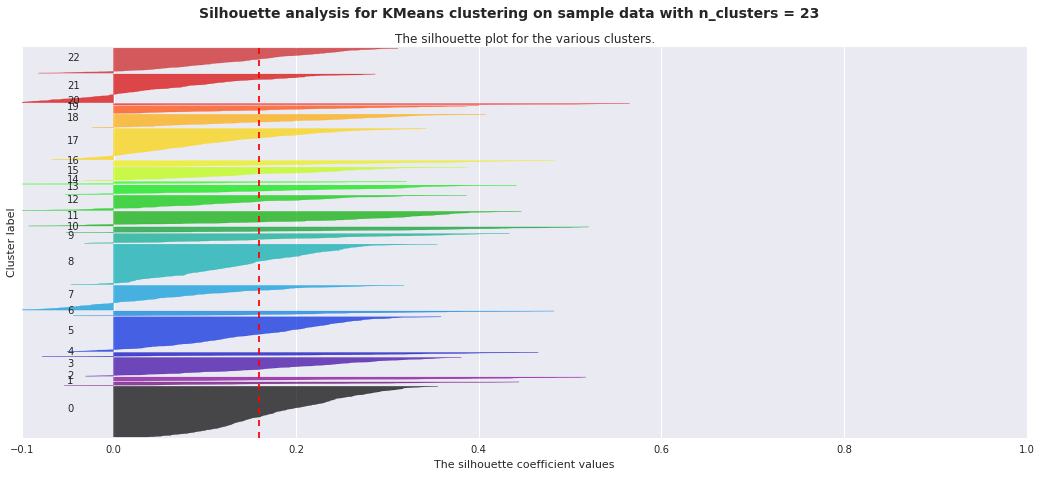

For n_clusters = 24 The average silhouette_score is : 0.160375868294


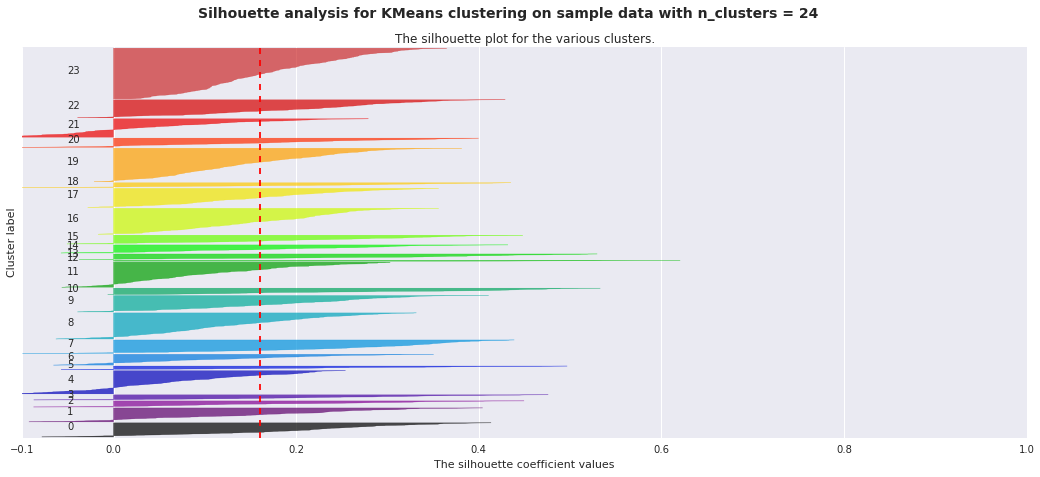

For n_clusters = 25 The average silhouette_score is : 0.155919753857


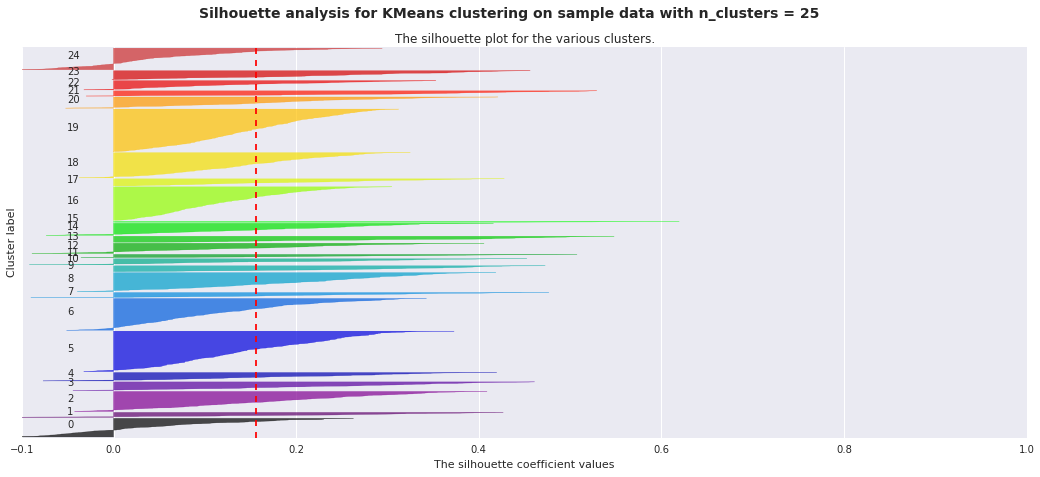

For n_clusters = 30 The average silhouette_score is : 0.150879935726


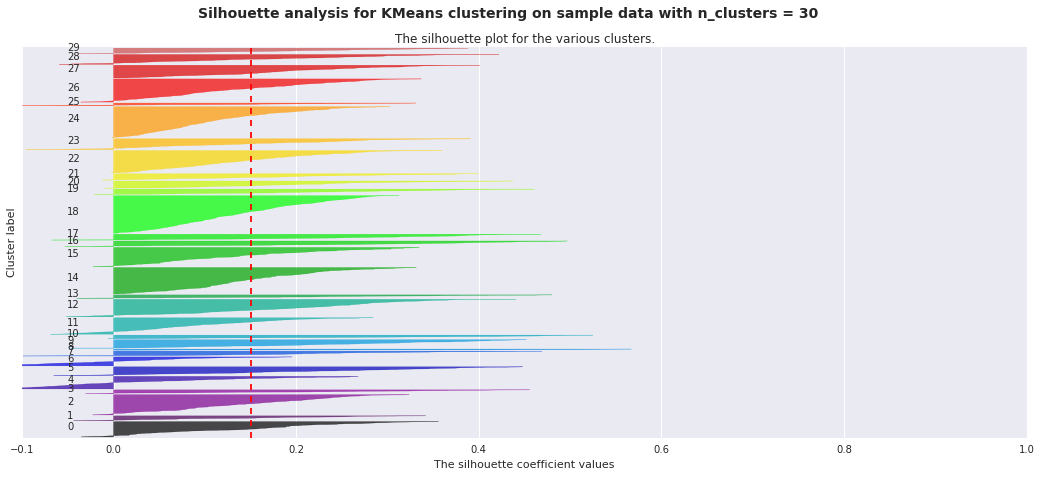

For n_clusters = 40 The average silhouette_score is : 0.143702942723


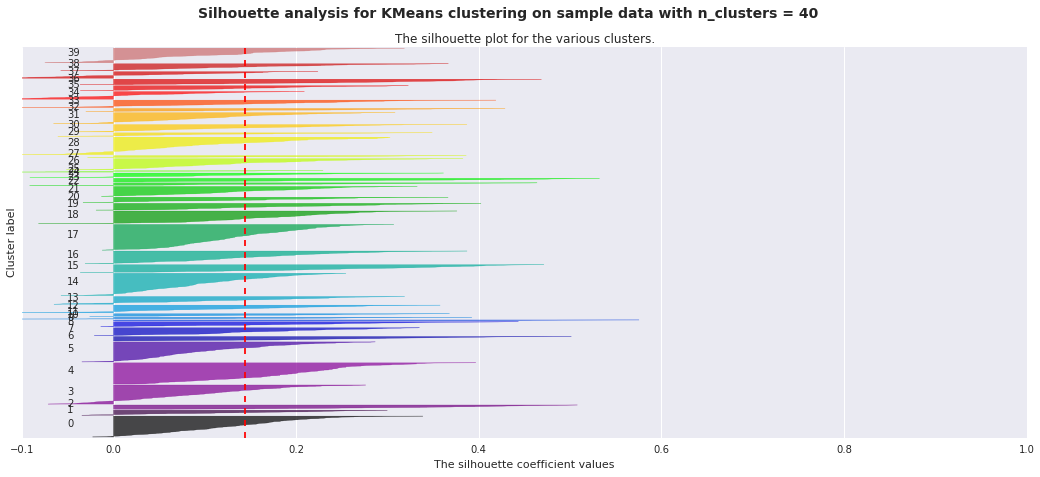

For n_clusters = 50 The average silhouette_score is : 0.139129822766


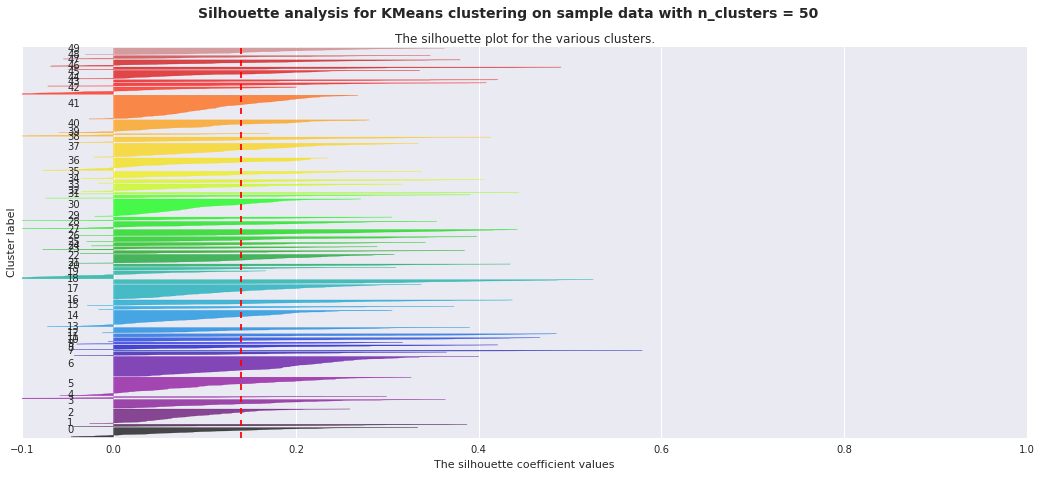

For n_clusters = 75 The average silhouette_score is : 0.129846274667


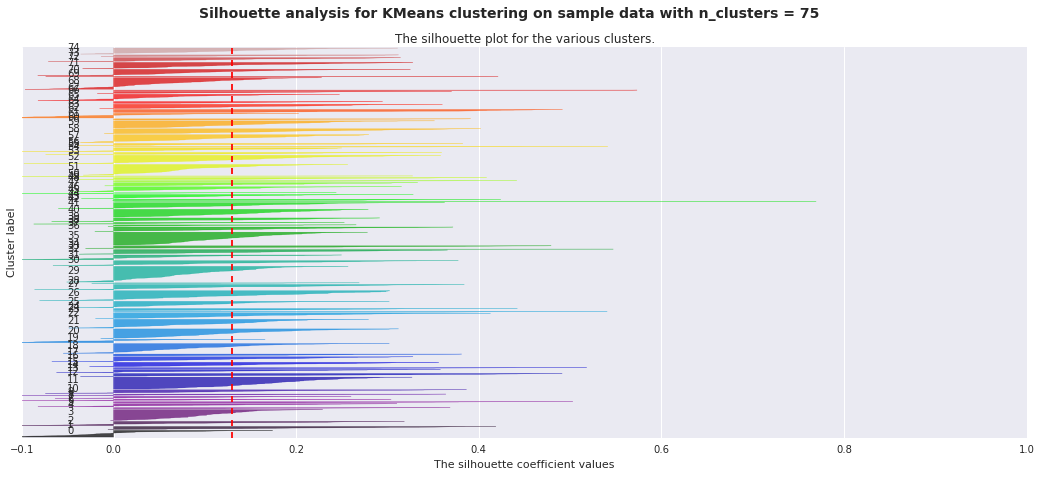

For n_clusters = 100 The average silhouette_score is : 0.125787166545


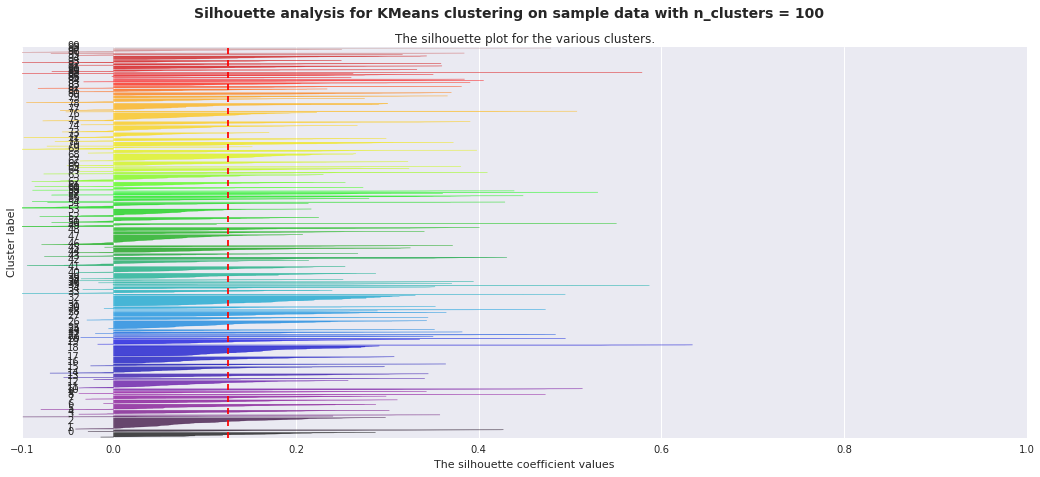

For n_clusters = 125 The average silhouette_score is : 0.123616418901


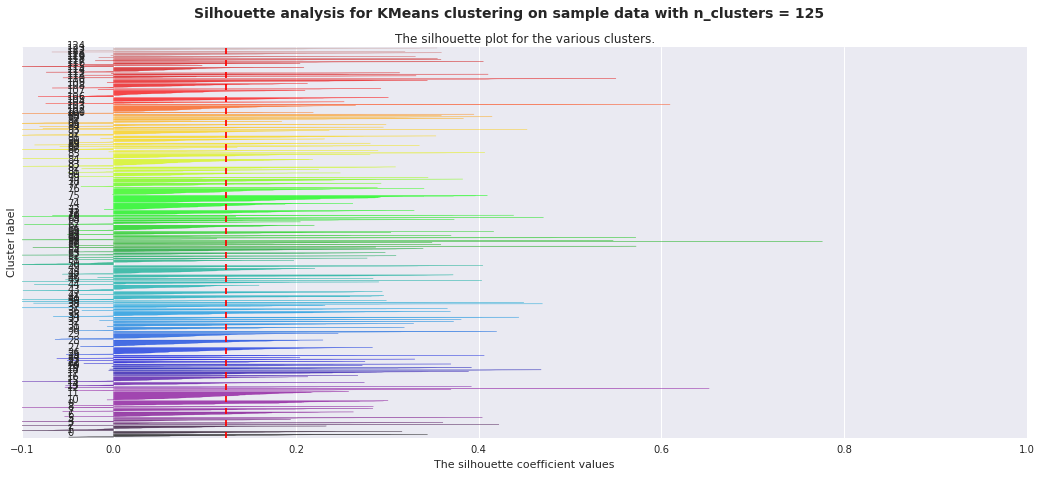

For n_clusters = 150 The average silhouette_score is : 0.124487118093


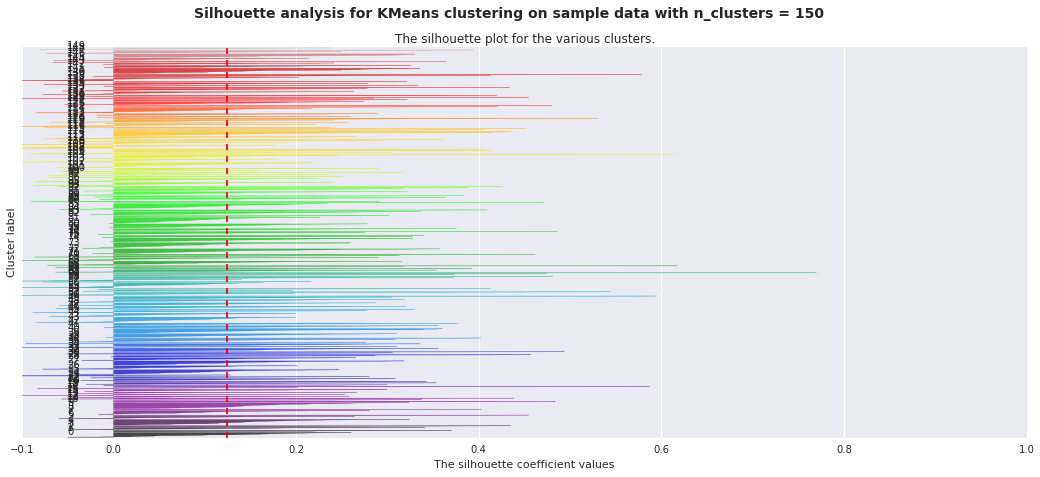

For n_clusters = 200 The average silhouette_score is : 0.120773501663


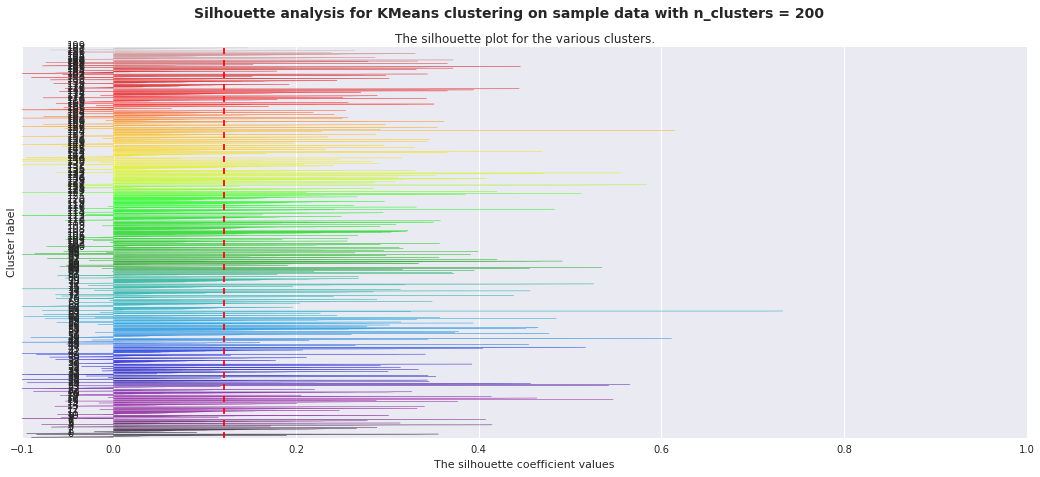

In [22]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


#print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = np.array(training_data.collect())

range_n_clusters = [3,4,5,10,15,20,21,22,23,24,25,30,40,50,75,100,125,150,200]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    
    
    

    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

<div class="alert alert-success">
Looking at the silhouette scores we have seen that between 15 and 20 it increases. So at the end we have chosen to have 20 clusters. As we have mentioned before, now the cluster that rapresents the background pixels is not more visible.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 19
<div class="alert alert-info">

a) Plot the centroids of the best model with a smart color selection.  

b) Plot the result of the clustering algorithm by a color map of voxels.  

c) Comment about your figures.  
</div>

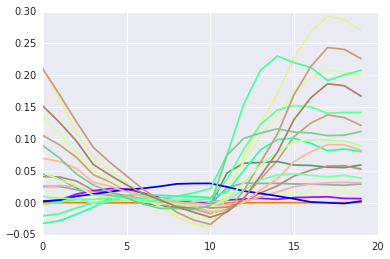

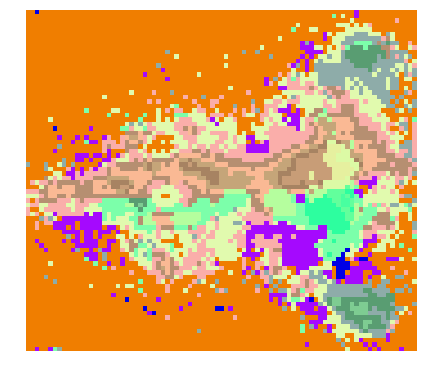

In [31]:
bestModel = KMeans(20).fit(training_data.collect())
newClrs = optimize_color(bestModel.cluster_centers_)
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(np.array(bestModel.cluster_centers_).T);
# predict the nearest cluster id for each voxel in Series
labels = data.map(lambda x: bestModel.predict(x))

# collect data to the driver
imgLabels = labels.toarray().reshape(2, 76, 87)

# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0, :, :])
draw_image(brainmap)

<div class="alert alert-success">
Looking at the plot, it seems the there is are same some big clusters and some very small ones. This difference between big and small clusters is more evident than before. Looking at this image, we can see that also the filtered voxels are colored and this fact affects the readibility of the content. Below we have put the mask as suggested to better visualize the content.
</div>

### g. Improve the visualization by adding similarity
These maps are slightly odd because pixels that did not survive our threshold still end up colored as something. A useful trick is masking pixels based on how well they match the cluster they belong to. We can compute this using the `similarity` method of `KMeansModel`.

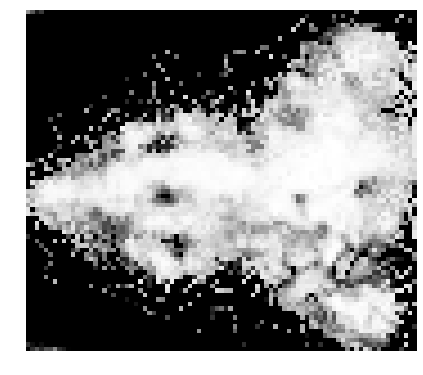

In [26]:
from scipy.spatial.distance import cdist
sim = data.map(lambda x: similarity(bestModel.cluster_centers_, x))

imgSim = sim.toarray()

# draw the mask
draw_image(imgSim[0,:,:], cmap='gray', clim=(0,1))

And, it can be used as a linear mask on the colorization output

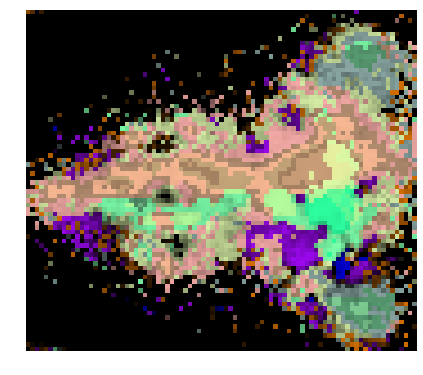

In [32]:
brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[0,:,:])
draw_image(brainmap)

<div class="alert alert-success">
Now the content is more readbale because we have masked the filtered voxels. It's pretty evident that there is a green label for a very small number of pixels. In addition it seems that in the central part of the image there is a region of similar voxels blue labelled. However it's very difficult to note a specific behaviour; in fact it's not simple to think how a fish brain activity could be, so the intiution does't help us in this case.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 20

<div class="alert alert-info">

Since in the usecase we build and test the model from the same data, it can lead to overfitting problems. To avoid that, we can divide the data into training set and testing set. Note that each neuron occurs only one time in the data. So, we can not divide the data by dividing the neurons. Instead, we can divide the states of neurons into two different sets. Let's try with this approach and show the result.

</div>

In [10]:
from pyspark.mllib.clustering import KMeans
ks = sc.broadcast([21])
    
def buildModels_2(data):
    # declare the collection of models
    models = [] 
    # build model for each K and append to models
    for k in ks.value:    
        models.append(KMeans.train(data, k)) 
    return models

In [39]:
def showLabels(md,data,newClrs):
    # predict the nearest cluster id for each voxel in Series
    sim = data.map(lambda x: similarity(md.cluster_centers, x))

    imgSim = sim.toarray()
    
    labels = data.map(lambda x: md.predict(x))
    # collect data to the driver
    imgLabels = labels.toarray().reshape(2, 76, 87)


    brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[0,:,:])
    plt.imshow(brainmap, interpolation='nearest', aspect='equal')


def computeModelAndVisualization(threshold,indices_train,indices_test):
    sns.set_style("darkgrid", {'axes.grid' : True})
    print ("Training samples: ",indices_train)
    print ("Test samples: ",indices_test)
    
    data1 = data.map(lambda x: np.array([j for i, j in enumerate(x) if i in indices_train]))
    data2 = data.map(lambda x: np.array([j for i, j in enumerate(x) if i in indices_test]))
    training_data1 = (data1.tordd().map(lambda x: np.array(x[1]))
                     .filter(lambda x: x.std() > threshold)
                    )
    
    #model1 = buildModels_2(training_data1)[0]
    model1 = KMeans(20).fit(training_data.collect())
    plt.figure(figsize=(16,10))
    newClrs = optimize_color(model1.cluster_centers_)
    plt.gca().set_color_cycle(newClrs.colors)
    plt.plot(np.array(model1.cluster_centers_).T);
    plt.title("New centroids")

    oFig1 = plt.figure(figsize=(20,13))

    i = 0
    sns.set_style("whitegrid", {'axes.grid' : False})
    oFig1.add_subplot(2,2,1)
    showLabels(model1,data1,newClrs)
    plt.title("Labels on the training data")
    oFig1.add_subplot(2,2,2)
    showLabels(model1,data2,newClrs)
    plt.title("Labels on the test data")
    plt.show()


    

Training samples:  [16  9  8 11  3 18 17 14 13 10]
Test samples:  [ 4 12 15 19  2  5  7  6  1  0]


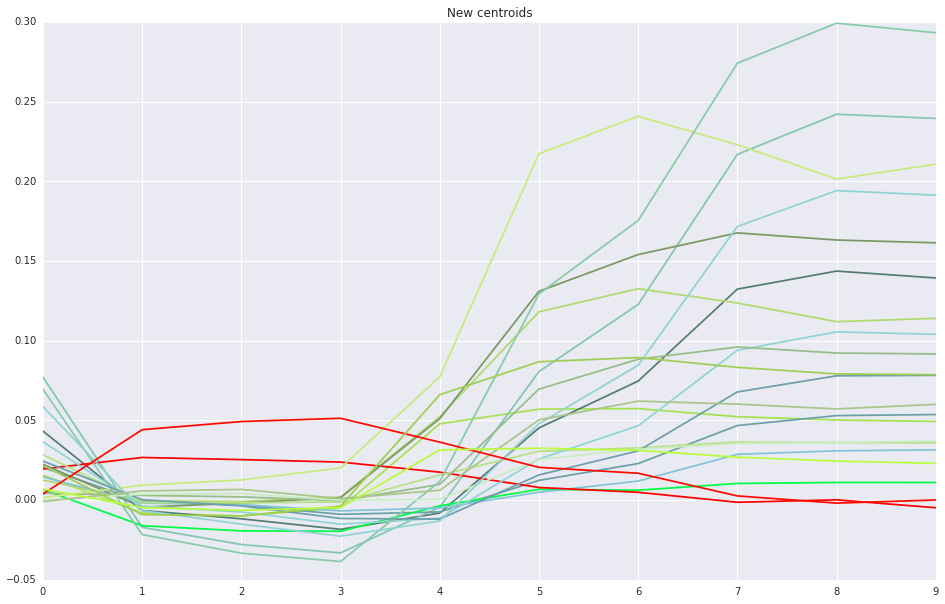

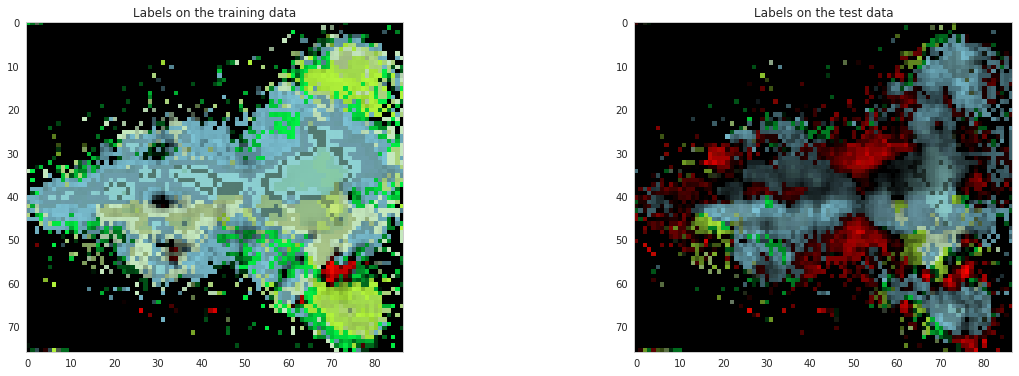

In [40]:
threshold = 0.0135
indices = np.arange(20)
np.random.shuffle(indices)
indices_train = indices[:10]
indices_test = indices[10:]


computeModelAndVisualization(threshold,indices_train,indices_test)


<div class="alert alert-success">
In the case in which we chose randomly the training sample indices, the quality of our predicition could be good or bad and the overfitting risk big or small depending on the same randomness. In fact we are talkink about time series, so to random subdive them doesn't seem a good idea. Suppose the case in which we randomly select the first 10 time sampels as training; it is probably the worst choiche because we don't know if these rapresent the same brain activity of the second one. This is also caused by the fact that we don't have informations about which brain activity is rapresented by the images; we don't know also the interval between two time samples.
<br>
<br>
So it's very important to reason about the nature of our data because the random selection of the training samples is not always a good choiche as in this case. However there are cases in which this is the best choice, as in the recommendation music notebook. It also depends on the number of data that we have; having a high number of samples should be usually good to take random samples, considering the hyphotesis that a big number of data usually means a good rapresentations of all different possibilities of the considered world. However in this case we are not lucky and the number of data is really low (only 20 time samples) so it's foundamental to pay attention to how to select the training samples.
<br>
<br>
To show what we have said we'll try to select the samples with more sense. Below we'll divide into odd and even indices samples, that seems the best choice not knowing about which brain activity the images are rapresenting.
</div>

Training samples:  [ 0  2  4  6  8 10 12 14 16 18]
Test samples:  [ 1  3  5  7  9 11 13 15 17 19]


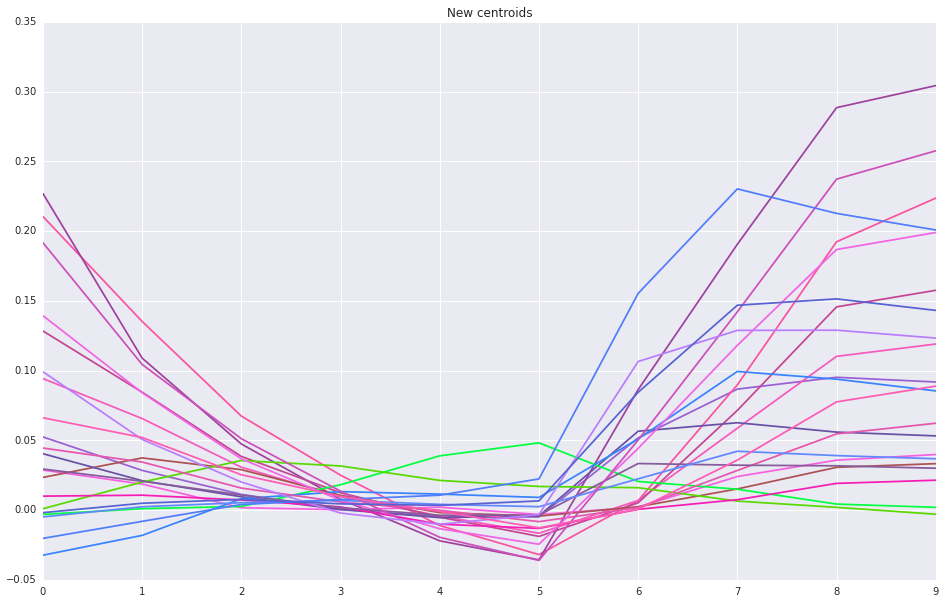

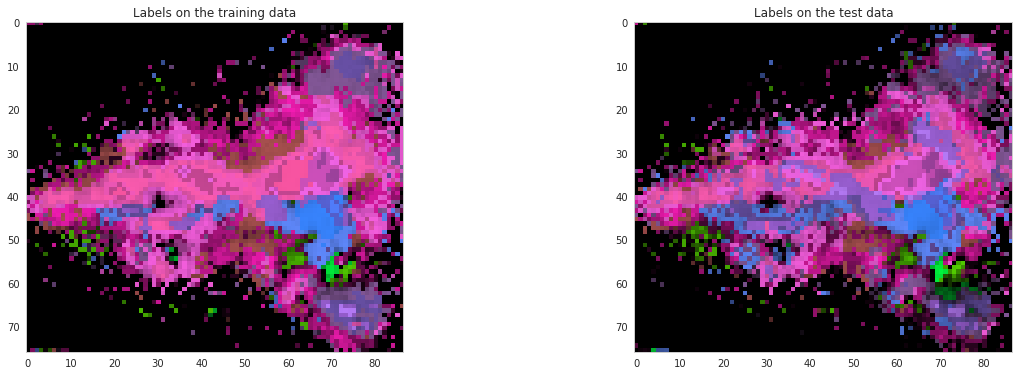

In [42]:
threshold = 0.0135
indices = np.arange(20)
indices_train = indices[::2]
indices_test = indices[1::2]
computeModelAndVisualization(threshold,indices_train,indices_test)

<div class="alert alert-success">
Dividing the training and test data into odd and even samples the result is really similar as expected.
<br>
In conlusion let's try to see what happens if we subdive the samples taking the first 10 as training data and the second 10 as test data.
</div>

Training samples:  [0 1 2 3 4 5 6 7 8 9]
Test samples:  [10 11 12 13 14 15 16 17 18 19]


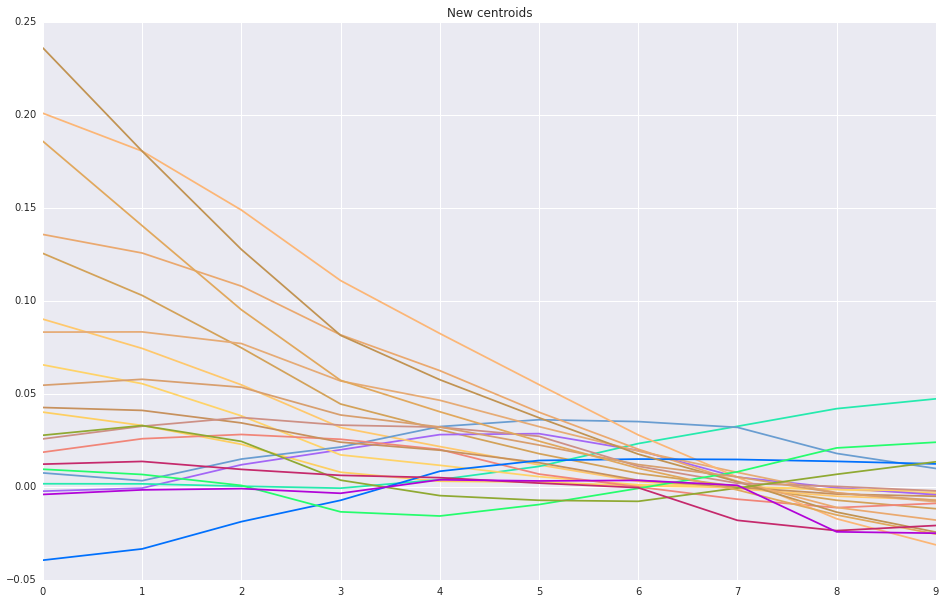

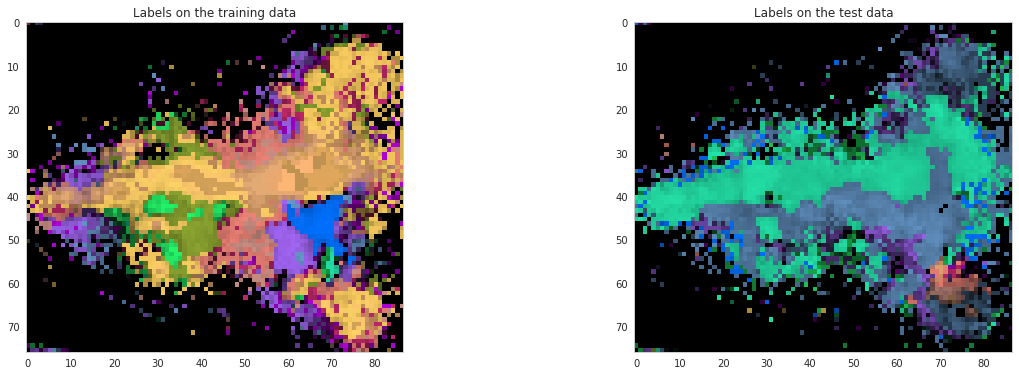

In [45]:
indices_train = indices[0:10]
indices_test = indices[10:]
computeModelAndVisualization(threshold,indices_train,indices_test)

<div class="alert alert-success">
As expected this is clearly the worst choiche as you can see looking at the total difference between the colors. The first 10 time samples probably rapresent a different brain activity respect to the second 10.
<br>
In conclusion we can say that we have to try to have all possible brain patterns in our training samples in order to better generalize the brain behaviour. Not having informations about what the images are rapresenting, the best way to do this is to divide into even and odd indices. 
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 21

<div class="alert alert-info">

Is using K-Means the best choice for a clustering algorithm? Comment the choice and suggest alternatives. For example, look at [Mixture Models](https://en.wikipedia.org/wiki/Mixture_model) and, if you have time, propose an alternative clustering technique. 

</div>

<div class="label label-danger">NOTE</div> Mixture models will be covered in the ASI course in greater detail.

In [171]:
from sklearn.mixture import GMM

In [37]:
from operator import add
from scipy.spatial.distance import cdist


def model_error_1_GMM(data, model):
    centers = model.means_
    return data.map(lambda x: squared_euclidean_distance(x, centers[np.argmin(cdist(centers, np.array([x])))])).reduce(add)
def model_error_2_GMM(data, model):
    bCenters = sc.broadcast(model.means_)
    return 1. / data.map(lambda x: similarity(bCenters.value, x)).reduce(add)
def model_error_3_GMM(data, model):
    bCenters = sc.broadcast(model.means_)
    centers = bCenters.value
    return data.map(lambda x: dissimilarity_DTW(centers[np.argmin(cdist(centers, np.array([x])))], x)).reduce(add)



In [40]:
def testAndPlotTheResultGMM(data, models):
    # compute the error metrics for the different resulting clusterings
    
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray([model_error_1_GMM(data, model) for model in models])
    
    # error of models when using similarity
    errors_2 = np.asarray([model_error_2_GMM(data, model) for model in models])
    
    # error of models when using dissimilarity_DTW
    errors_3 = np.asarray([model_error_3_GMM(data, model) for model in models])
    
    # plot the errors with each value of K
    plt.figure(figsize=(10, 6))
    plt.plot(
        ks, errors_1 / errors_1.sum(), 'k-o',
        ks, errors_2 / errors_2.sum(), 'b:v',
        ks, errors_3 / errors_3.sum(), 'r:v' )
    plt.legend(["model error 1", "model error 2","model error 3"])
    plt.xlabel('clusters number')
    plt.ylabel('error')
    plt.show()

In [174]:
X = np.array(training_data.collect())

In [33]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


#print(__doc__)

def GaussianMixtureSilhuette(filtered_data,training_data,range_n_clusters = [5, 10, 15, 20, 30, 50, 100, 200]):
    # Generating the sample data from make_blobs
    # This particular setting has one distinct cluster and 3 clusters placed close
    # together.
    X = np.array(training_data.collect())
    filtered_data = filtered_data.collect()
    


    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.


        gmm = GMM(n_clusters)
        gmm.fit(X)
        cluster_labels_ = np.array([gmm.predict(x) for x in X])
        cluster_labels= cluster_labels_.flatten()
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        plt.show()

For n_clusters = 5 The average silhouette_score is : 0.384153234618


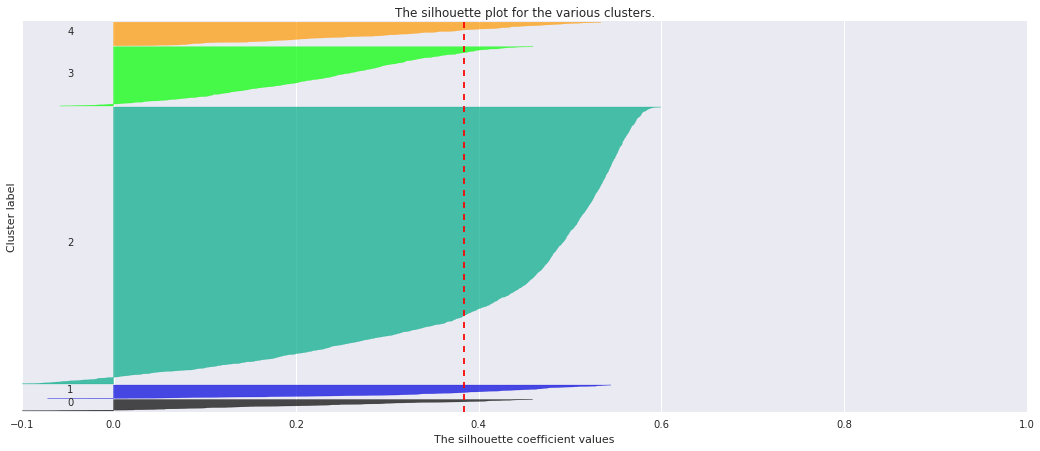

For n_clusters = 10 The average silhouette_score is : 0.257384044173


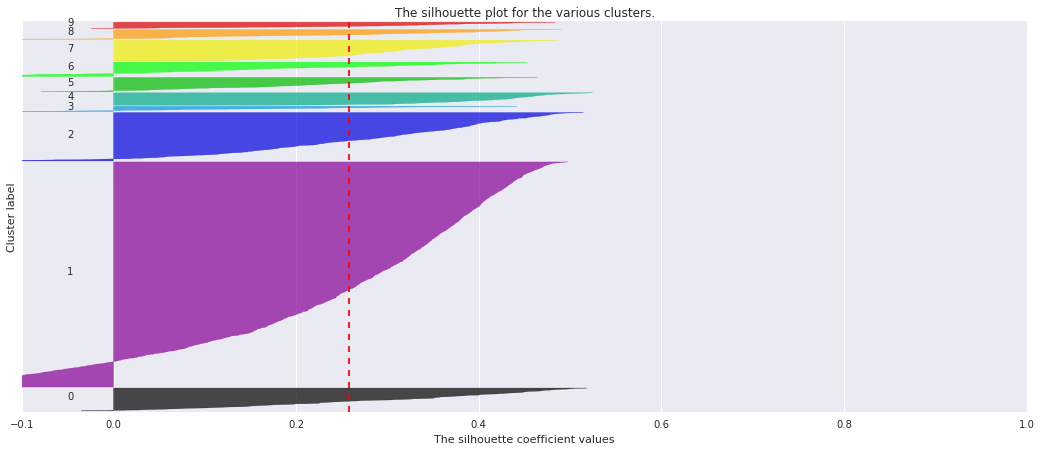

For n_clusters = 15 The average silhouette_score is : 0.130306002975


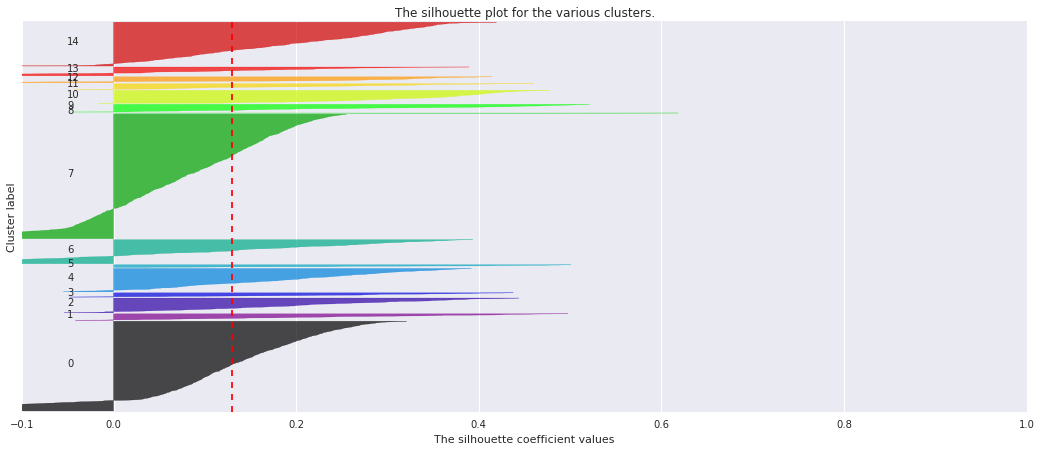

For n_clusters = 20 The average silhouette_score is : 0.181450770915


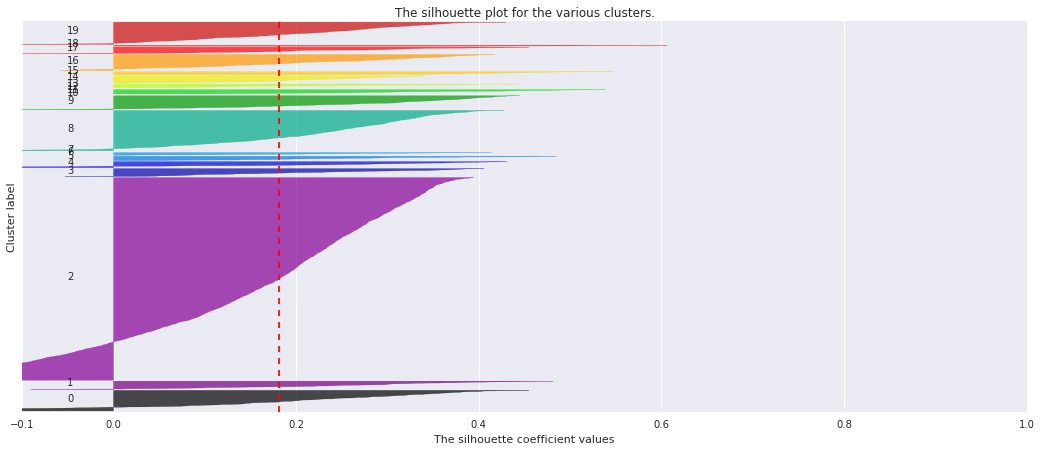

For n_clusters = 30 The average silhouette_score is : 0.086670749077


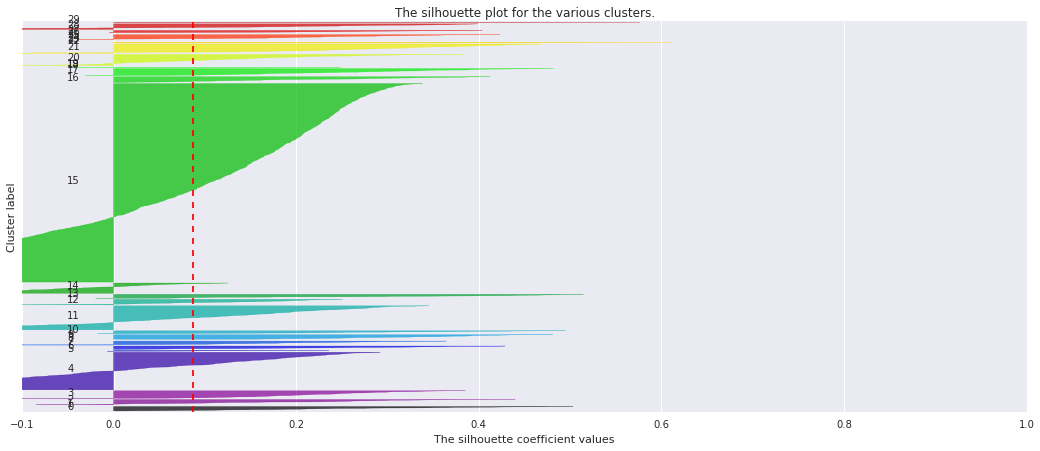

For n_clusters = 50 The average silhouette_score is : 0.22314146386


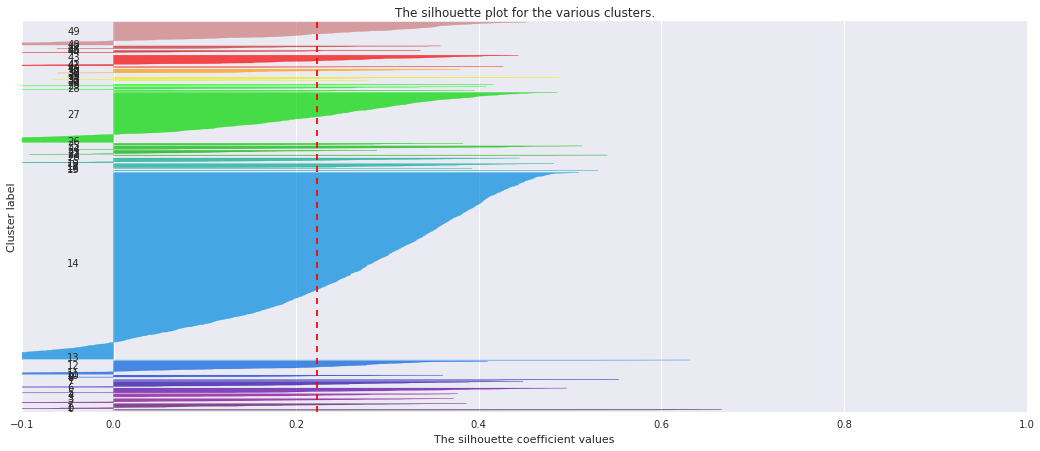

For n_clusters = 100 The average silhouette_score is : 0.0911415213599


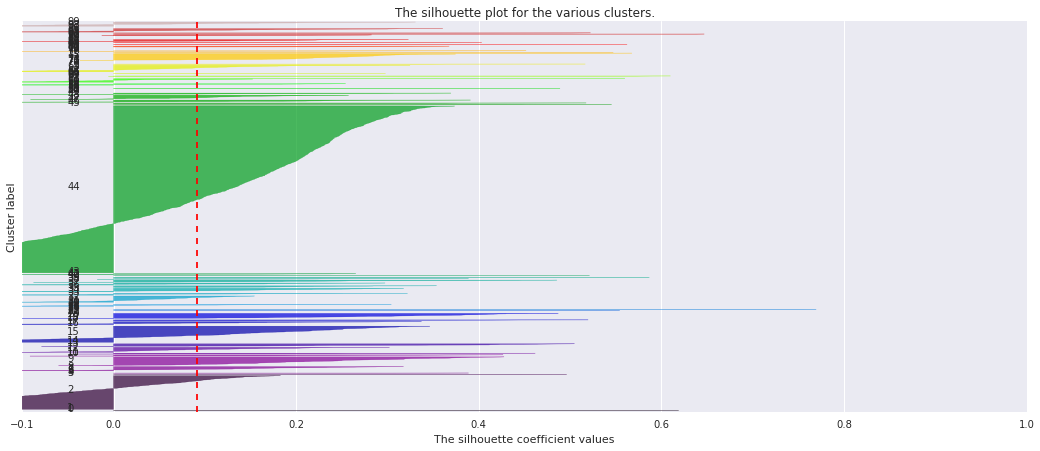

For n_clusters = 200 The average silhouette_score is : 0.0295882475714


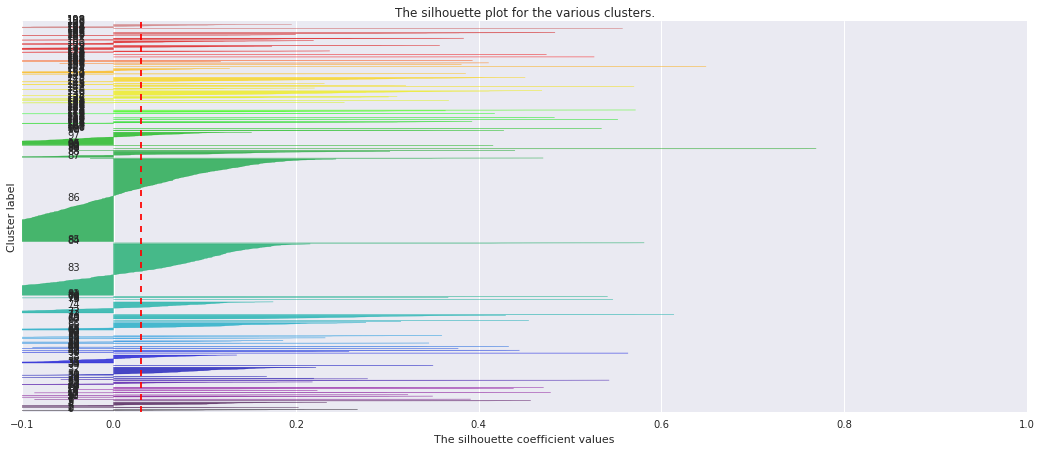

In [34]:
filtered_data = data.tordd().map(lambda x: np.array(x[1]))
training_data = filtered_data.filter(lambda x: x.std() > threshold)

GaussianMixtureSilhuette(filtered_data,training_data,range_n_clusters = [5, 10, 15, 20, 30, 50, 100, 200])

<div class="alert alert-success">
Also using the gaussian mixture model, we didn't get a rally good silhouette. What we can do is to plot the labels as before, to see if the results are similar to the ones that we got using the KMeans.
</div>

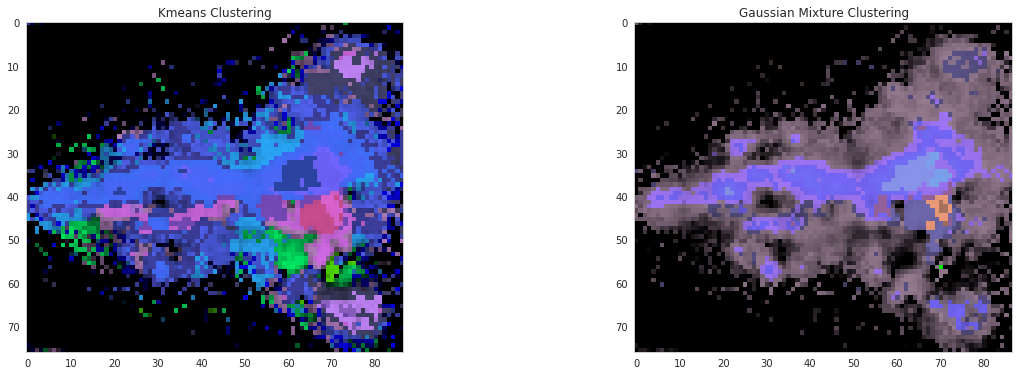

In [83]:
sns.set_style("whitegrid", {'axes.grid' : False})
oFig1 = plt.figure(figsize=(20,13))
titles = ['Kmeans Clustering','Gaussian Mixture Clustering']


bestModel = KMeans(20).fit(training_data.collect())

# predict the nearest cluster id for each voxel in Series
labels = data.map(lambda x: bestModel.predict(x))
newClrs = optimize_color(bestModel.cluster_centers_)
plt.gca().set_color_cycle(newClrs.colors)
# collect data to the driver
imgLabels = labels.toarray().reshape(2, 76, 87)

sim = data.map(lambda x: similarity(bestModel.cluster_centers_, x))

imgSim = sim.toarray()

# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0, :, :],mask=imgSim[0,:,:])
oFig1.add_subplot(2,2,1)
plt.imshow(brainmap, interpolation='nearest', aspect='equal')
plt.title(titles[0])


bestModelGMM = GMM(20)
bestModelGMM.fit(training_data.collect())

# predict the nearest cluster id for each voxel in Series
labels = data.map(lambda x: bestModelGMM.predict(x))
newClrs = optimize_color(bestModelGMM.means_)
plt.gca().set_color_cycle(newClrs.colors)

# collect data to the driver
imgLabels = labels.toarray().reshape(2, 76, 87)
sim = data.map(lambda x: similarity(bestModelGMM.means_, x))

imgSim = sim.toarray()
# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0, :, :],mask=imgSim[0,:,:])
oFig1.add_subplot(2,2,2)
plt.imshow(brainmap, interpolation='nearest', aspect='equal')
plt.title(titles[1])
plt.show()


<div class="alert alert-success">
Actually the reults yhat we have obtained using GMM are a little bit different to the ones that we obtained through KMeans. The zones indentified respectively with the same colors sometimes coincide sometimes not.
Below we'll try to compare the two different error plots.
</div>

KMeans error


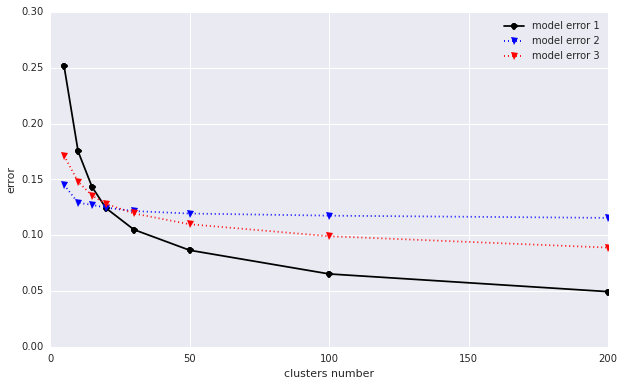

GMM error


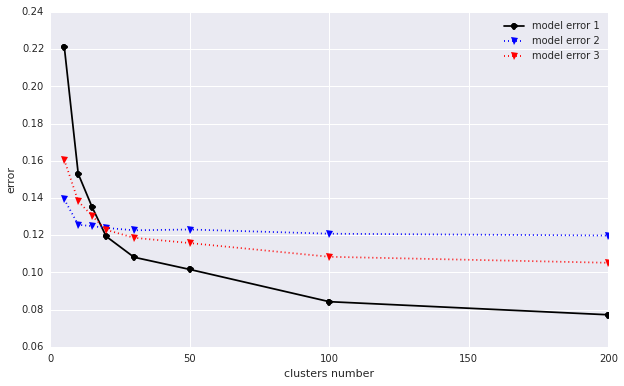

In [42]:
modelsGMM = [GMM(k).fit(X) for k in ks]
ks = [5, 10, 15, 20, 30, 50, 100, 200]
print("KMeans error")
testAndPlotTheResult(training_data,models)
print("GMM error")
testAndPlotTheResultGMM(training_data, modelsGMM)

<div class="alert alert-success">
We can note that when we use the GMM model the highest error is around 0.22 while using the KMeans is around 0.25 (considering the model error 1). However the lowest error using GMM model is higher than the lowest one using the KMeans. So we can say that changing the number of clusters affects more the KMeans model than the GMM one.
<br>
However, using the GMM, we didn't get a significant improvement respect to the KMeans.
</div>

# 4. Summary
We studied Thunder and its important methods to work with images, such as `Image`, `Series` and how to apply them to a use case. In the use case, we used the K-Means algorithm to cluster the neurons without prior knowledge of what a good choice of K could be. Subsequently, we introduced some techniques for improving the initially obtained results, such as removing noise and considering similarity.

# References
Some of the examples in this notebook are inspired from the [documentation of Thunder](http://docs.thunder-project.org/).

## IMPROVE FILTERING AND USE MORE DATA

In [9]:
import matplotlib.pyplot as plt
!pip install scikit-image
from skimage import data
from skimage import filters
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk

    100% |████████████████████████████████| 33.8MB 45kB/s 
    100% |████████████████████████████████| 5.7MB 238kB/s 
    100% |████████████████████████████████| 47.9MB 32kB/s 
    100% |████████████████████████████████| 1.3MB 693kB/s 
  Found existing installation: scipy 0.16.1
    DEPRECATION: Uninstalling a distutils installed project (scipy) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.
    Uninstalling scipy-0.16.1:
      Successfully uninstalled scipy-0.16.1
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


<div class="alert alert-success">
For the moment we have filtered the data looking at the standard deviation and setting a threshold; however we want to be sure to consider only the image region describing the brainfish. Our first idea was to apply a gradient based filtering to detect the borders and then to preserv only the voxels inside the external borders; so we imported the library `skimage`; playing a little bit with this library we discovered that the best way to consider only the brainfish voxels was to use a threshold as you can see below.
<br>
To perform this operation will use a different dataset; actually we retrieved all brainfish images. So now we have 2 layers of 76x86 pixels. The time series is composed by 240 different instants, rather than only 20.
</div>

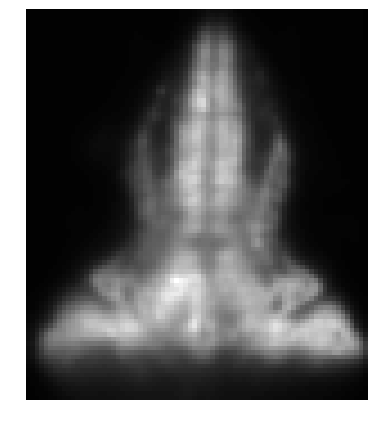

In [68]:
all_images = td.images.frombinary('fish-long').tospark(engine=sc)
draw_image(all_images.first()[0])

<div class="alert alert-success">
As you can see the images are rotated respect to the previous ones.
</div>

Layer 0 possible thresholdings


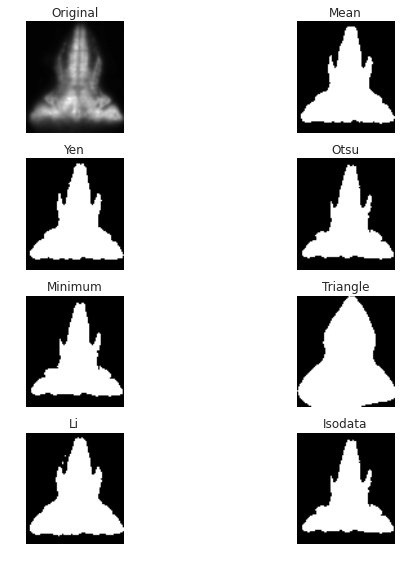

Layer 1 possible thresholdings


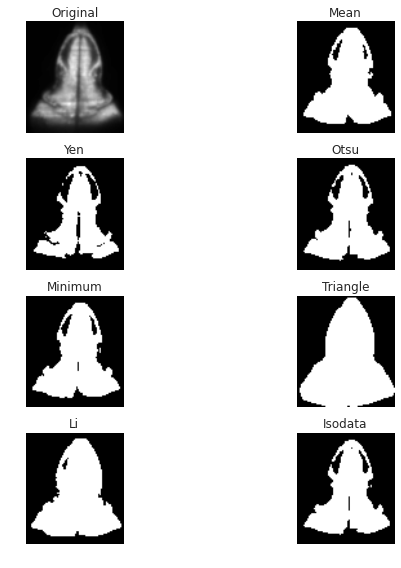

In [69]:
img1 = all_images.first()
img1_layer0 = img1[0].astype(int)
print("Layer 0 possible thresholdings")
fig, ax = filters.try_all_threshold(img1_layer0, figsize=(10, 8), verbose=False)
plt.show()
img1_layer1 = img1[1].astype(int)
print("Layer 1 possible thresholdings")
fig, ax = filters.try_all_threshold(img1_layer1, figsize=(10, 8), verbose=False)
plt.show()

<div class="alert alert-success">
We have seen the result of all different thresholding types. At the end we have chosen to use the mean threshold because this method seems clearly identify the brainfish area for both layers. Below we'll compute for each image the binary one, and summing them we'll separate the foreground (the brainfish)  and the background (the noise).
</div>

In [70]:
binary_0 = np.array([[False for j in range(76)] for i in range(87)])
binary_1 = np.array([[False for j in range(76)] for i in range(87)])

In [71]:
for i in range(20):
    img_layer_0 = takeElement(all_images,i)[0].astype(int)
    thresh = filters.threshold_mean(img_layer_0)
    bin_0 = img_layer_0 > thresh
    binary_0 += bin_0
    img_layer_1 = takeElement(all_images,i)[1].astype(int)
    thresh = filters.threshold_mean(img_layer_1)
    bin_1 = img_layer_1 > thresh
    binary_1 += bin_1

Layer 0


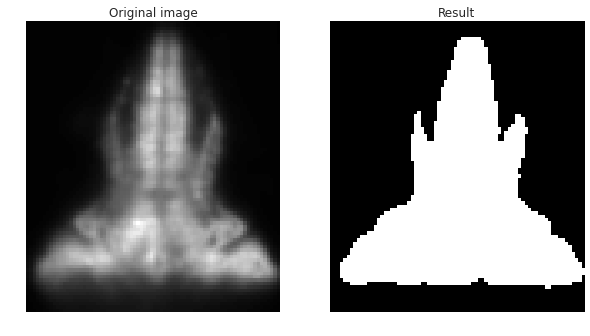

Layer 1


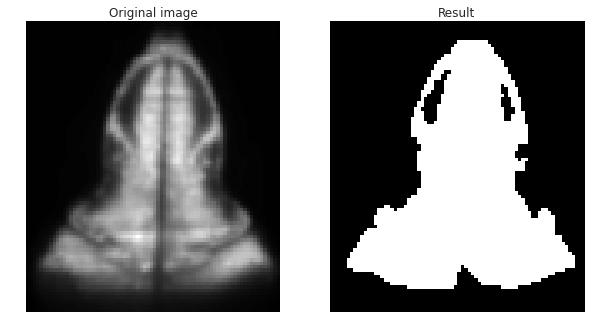

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))
ax = axes.ravel()
print("Layer 0")
ax[0].imshow(img1_layer0,interpolation='nearest',aspect='equal', cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary_0,interpolation='nearest',aspect='equal', cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')
    

plt.show()

binary_1 = img1_layer1 > thresh

fig, axes = plt.subplots(ncols=2, figsize=(10, 6))
ax = axes.ravel()
print("Layer 1")
ax[0].imshow(img1_layer1,interpolation='nearest',aspect='equal', cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary_1,interpolation='nearest',aspect='equal', cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')
    

plt.show()

<div class="alert alert-success">
Loooking at the images the filtering process seems work better than the standard deviation filtering because all pixels voxels outside the brainfish are completely suppressed. 
</div>

In [10]:
binary_images  = []
for i in range(87):
    arr_j = []
    for j in range(76):
        arr_j.append([binary_0[i][j],binary_1[i][j]])
    binary_images.append(arr_j)

In [82]:
images_binary = td.images.fromarray([binary_images], labels=None, npartitions=None, engine=sc)
data_rdd = all_images.toseries().map(lambda x: x.astype(int)).normalize().tordd().map(lambda x: np.array(x[1])).cache()
data_binary_rdd = images_binary.toseries().tordd().map(lambda x: np.array(x[1])).cache()
data_local = data_rdd.collect()
data_binary_local = data_binary_rdd.collect()

In [109]:
threshold = 0.01
data_local_filtered_std = [x for i,x in enumerate(data_local) if  x.std()>threshold]
data_local_filtered_th = [x for i,x in enumerate(data_local) if  data_binary_local[i]]
data_local_filtered = [x for i,x in enumerate(data_local) if data_binary_local[i] and x.std()>threshold]
print("Number of remaining voxels using standard deviation:",len(data_local_filtered_std))
print("Number of remaining voxels using thresholding:",len(data_local_filtered_th))
print("Number of remaining voxels using both methods:",len(data_local_filtered))

Number of remaining voxels using standard deviation: 7748
Number of remaining voxels using thresholding: 5216
Number of remaining voxels using both methods: 3047


<div class="alert alert-success">
To filter the voxels, we have combined both the standard deviation criteria and the thresholding criteria. However we set the min stadard deviation (to preserver the poxels) with a lower value respt to before. In fact using the thresholding filter we are already sure to look at brianfish zones. 
<br>
Now we are ready to retrain the model.
</div>

In [110]:
data_filtered = sc.parallelize(data_local_filtered)

In [115]:
def buildModels2(data):
    # declare the collection of models
    bData = sc.broadcast(data.collect())
    
    models = ks_parallelized.map(lambda k: KMeans(k).fit(bData.value))

    return models.collect()
ks_parallelized = sc.parallelize([5, 10, 15, 20, 30, 50, 100, 200])
models = buildModels2(data_filtered)


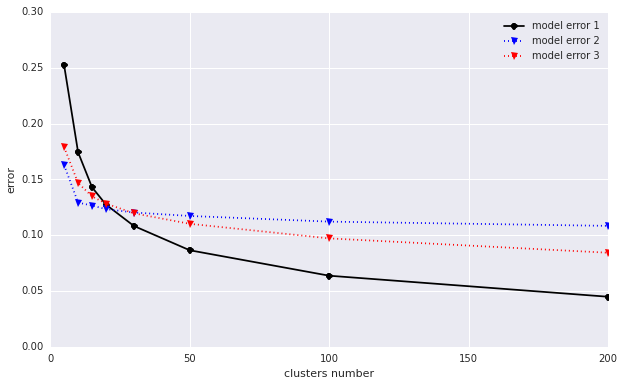

In [116]:
sns.set_style("darkgrid", {'axes.grid' : True})
ks = [5, 10, 15, 20, 30, 50, 100, 200]
testAndPlotTheResult(data_filtered, models)

<div class="alert alert-success">
Looking at the error plot, now the 'elbow'is more evident; expecially looking at the similarity error estimation (the blue one).
<br>
However this is not enough, because computing the silhouette (below), it's evident that the clusters are not well separated.
</div>

For n_clusters = 5 The average silhouette_score is : 0.410862469611


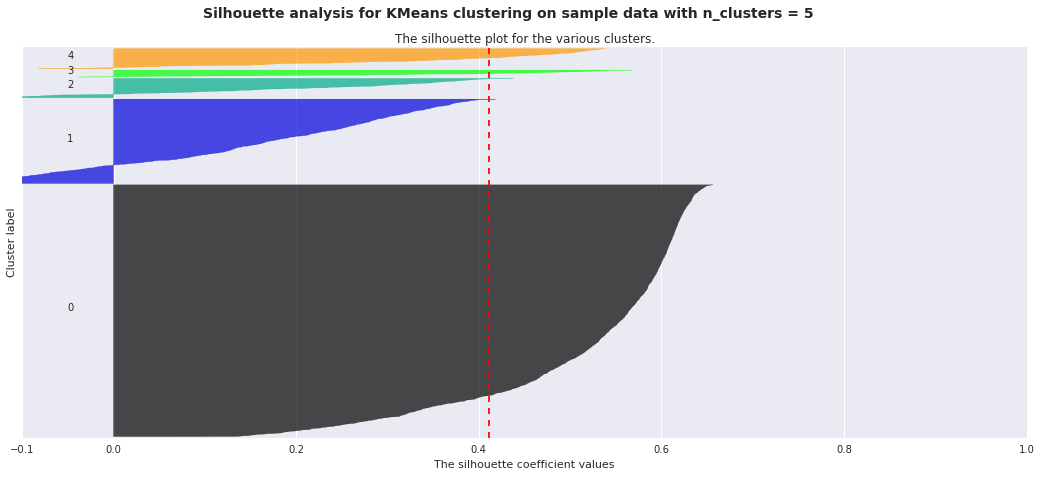

For n_clusters = 10 The average silhouette_score is : 0.219554646601


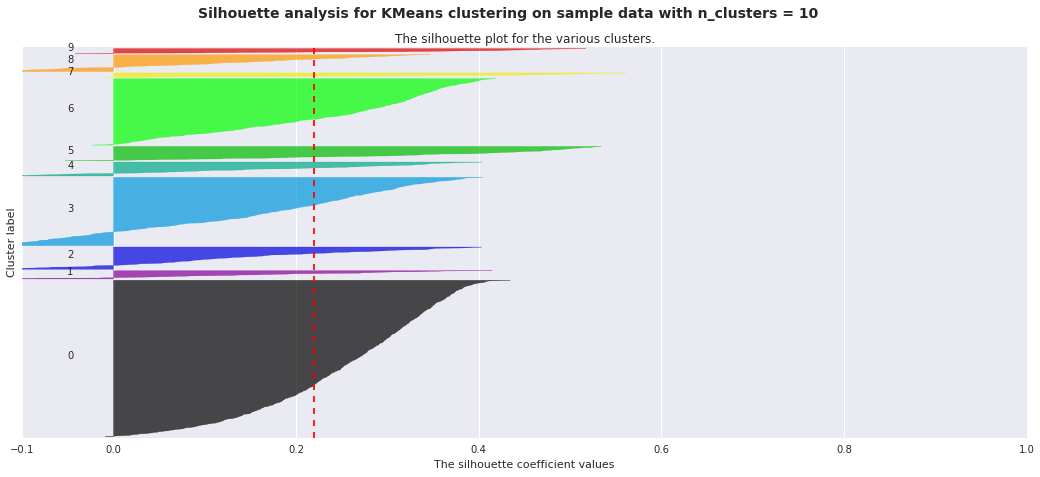

For n_clusters = 15 The average silhouette_score is : 0.180422101154


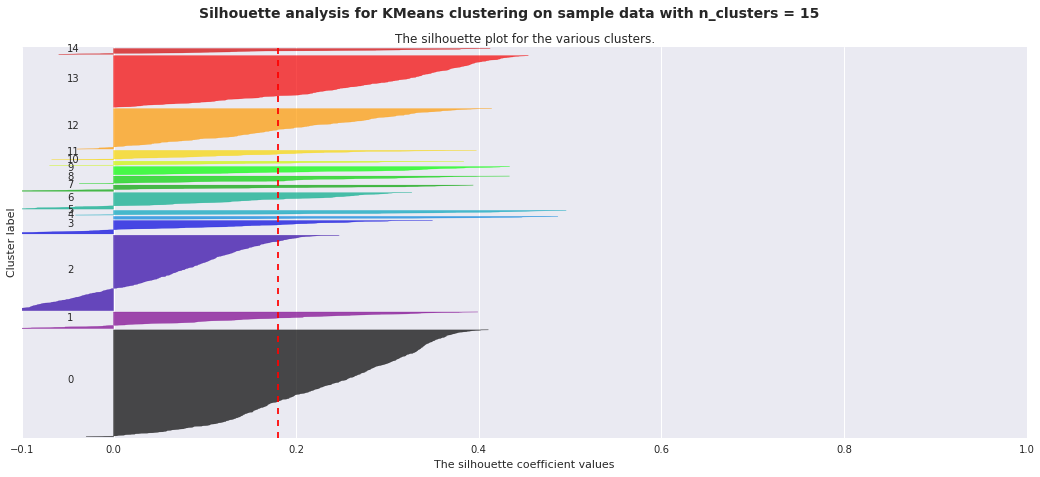

For n_clusters = 20 The average silhouette_score is : 0.170405470821


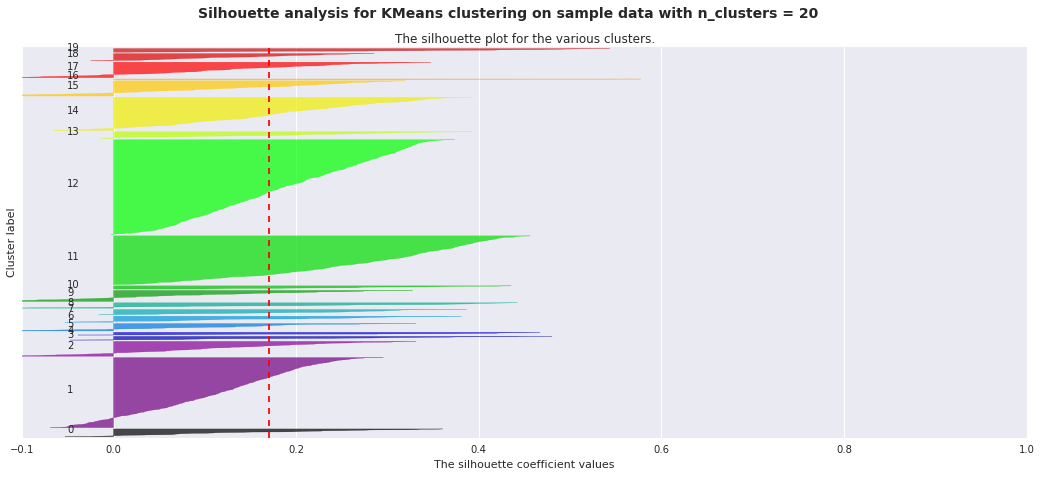

For n_clusters = 30 The average silhouette_score is : 0.137542983786


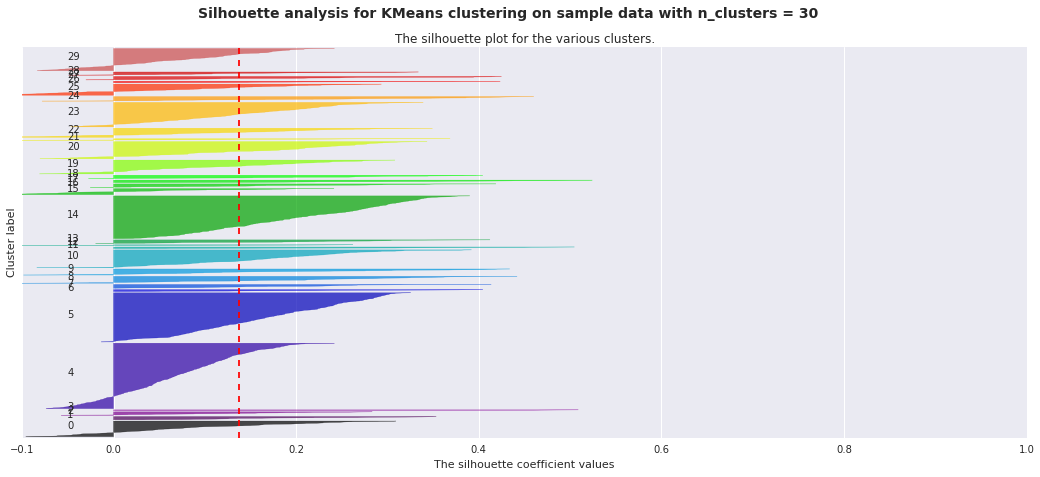

For n_clusters = 50 The average silhouette_score is : 0.129088794925


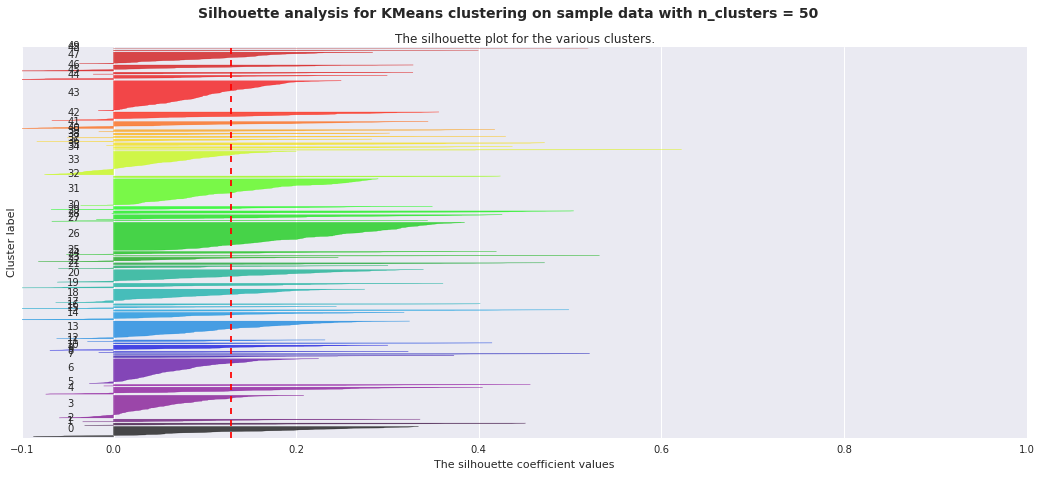

For n_clusters = 100 The average silhouette_score is : 0.114211050902


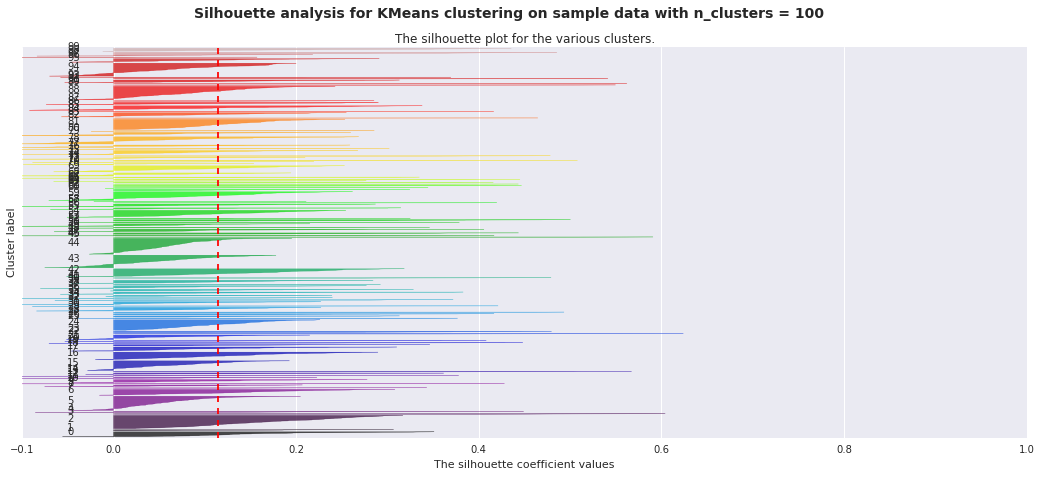

For n_clusters = 200 The average silhouette_score is : 0.118569326404


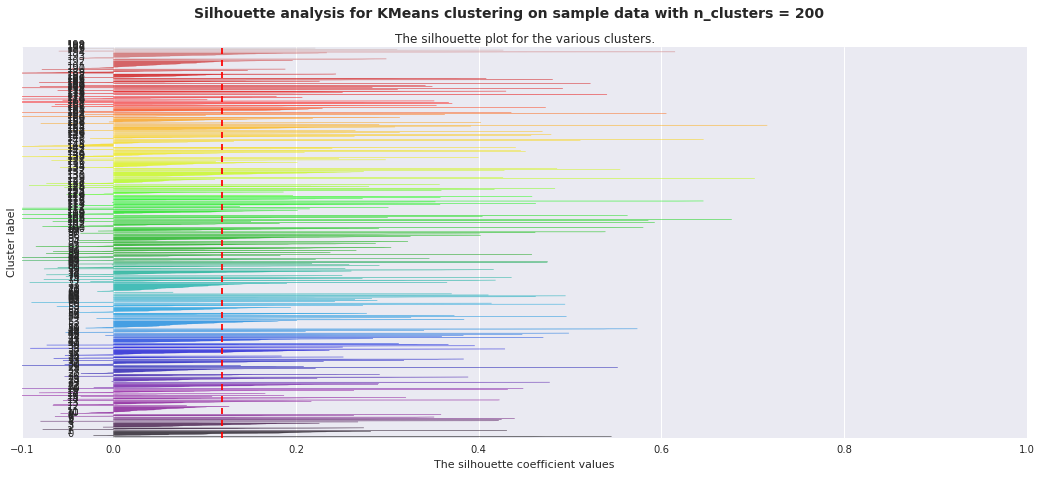

In [117]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


#print(__doc__)


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = np.array(data_filtered.collect())

range_n_clusters = [5, 10, 15, 20, 30, 50, 100, 200]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    
    

    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

<div class="alert alert-success">
Actually we didn't obtained a improvement.
Below we'll plot which the new centroids and the new label.
</div>

In [150]:
def showLabels1(md,data,newClrs):
    # predict the nearest cluster id for each voxel in Series
    sim = data.map(lambda x: similarity(md.cluster_centers_, x))

    imgSim = sim.toarray()
    
    labels = data.map(lambda x: md.predict(x))
    # collect data to the driver
    imgLabels = labels.toarray().reshape(2, 87, 76)


    brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[0,:,:])
    
    #brainmap
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.imshow(brainmap, interpolation='nearest', aspect='equal')
    


def ModelandVisualization2(model1,data1):

    #model1 = buildModels_2(training_data1)[0]
    sns.set_style("darkgrid", {'axes.grid' : True})
    plt.figure(figsize=(16,10))
    newClrs = optimize_color(model1.cluster_centers_)
    plt.gca().set_color_cycle(newClrs.colors)
    plt.plot(np.array(model1.cluster_centers_).T);
    plt.title("New centroids")
    plt.show()
    i = 0
    plt.figure(figsize=(14,8))
    sns.set_style("whitegrid", {'axes.grid' : False})
    showLabels1(model1,data1,newClrs)
    plt.title("KMeans with 240 TimeSeries")
    plt.show()

In [123]:
#training_data = data.tordd().map(lambda x: np.array(x[1])).cache()
#training_data_filtered = training_data.filter(lambda x: x.std() > 0)

In [129]:
model1 = KMeans(20).fit(data_filtered.collect())
data1 = all_images.toseries().map(lambda x: x.astype(int)).normalize()

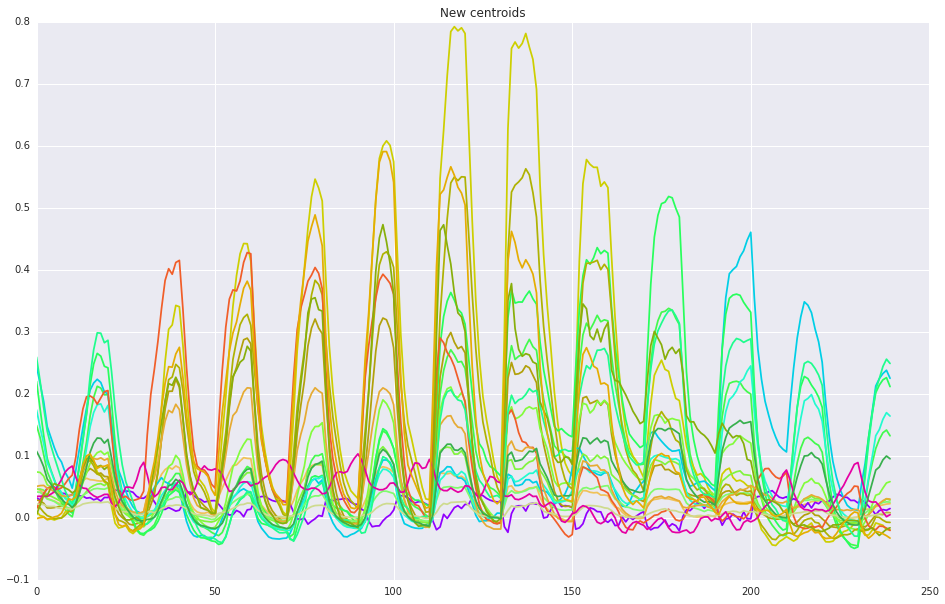

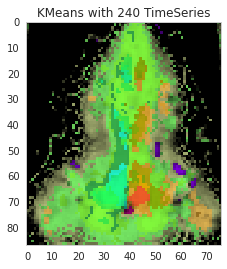

In [151]:
ModelandVisualization2(model1,data1)

<div class="alert alert-success">
We can conclude that also using 240 images and trying to optimize the filtering process this is the clusterization.
<br>
Then we want to try a different metric to compute the KMeans model. In particular we'll try to use the
<strong>dissimilarity_DTW</strong> rather than the euclidean distance.
</div>

# NEW MODEL USING DISSIMILARITY DTW

<div class="alert alert-success">
We'll use the KMeans model definition that we used in the previous notebook, not using the euclidean distance but the dissimilarity DWT. We'll use only the basic 20 time series because we have not time to perform the computation for all time series. Also the DTWDistance function is an optimization that allows faster computation.
</div>

In [13]:
from math import sqrt
def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return sqrt(LB_sum)
import random


def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]

        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]

    return centroids
def DTWDistance1(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [10]:
image_data = td.images.fromexample('fish', engine=sc)
binary_0 = np.array([[False for j in range(87)] for i in range(76)])
binary_1 = np.array([[False for j in range(87)] for i in range(76)])
for i in range(20):
    img_layer_0 = takeElement(image_data,i)[0]
    thresh = filters.threshold_mean(img_layer_0)
    bin_0 = img_layer_0 > thresh
    binary_0 += bin_0
    img_layer_1 = takeElement(image_data,i)[1]
    thresh = filters.threshold_mean(img_layer_1)
    bin_1 = img_layer_1 > thresh
    binary_1 += bin_1

binary_images  = []
for i in range(76):
    arr_j = []
    for j in range(87):
        arr_j.append([binary_0[i][j],binary_1[i][j]])
    binary_images.append(arr_j)

images_binary = td.images.fromarray([binary_images], labels=None, npartitions=None, engine=sc)
data_rdd = image_data.toseries().normalize().tordd().map(lambda x: np.array(x[1])).cache()
data_binary_rdd = images_binary.toseries().tordd().map(lambda x: np.array(x[1])).cache()
data_local = data_rdd.collect()
data_binary_local = data_binary_rdd.collect()


In [11]:
threshold = 0.01
data_local_filtered_std = [x for i,x in enumerate(data_local) if  x.std()>threshold]
data_local_filtered_th = [x for i,x in enumerate(data_local) if  data_binary_local[i]]
data_local_filtered = [x for i,x in enumerate(data_local) if data_binary_local[i] and x.std()>threshold]
data_filtered = sc.parallelize(data_local_filtered)

<div class="alert alert-success">
In the cells above we have filtered the data considering both the standard deviation and the thresholding filtering. Now we'll compute the new mdoel.
</div>

In [20]:
ks = [5,10,20,25]
models_ = [k_means_clust(list(X),k,10) for k in ks]

In [21]:
def model_error_1_a_2(data, centroids):
    centers = centroids
    return data.map(lambda x: squared_euclidean_distance(x, centers[np.argmin(cdist(centers, np.array([x])))])).reduce(add)

def model_error_2_2(data, centroids):
    bCenters = sc.broadcast(centroids)
    return 1. / data.map(lambda x: similarity(bCenters.value, x)).reduce(add)
def model_error_3_2(data, centroids):
    bCenters = sc.broadcast(centroids)
    centers = bCenters.value
    return data.map(lambda x: dissimilarity_DTW(centers[np.argmin(cdist(centers, np.array([x])))], x)).reduce(add)

In [22]:
def testAndPlotTheResult2(data, models):
    # compute the error metrics for the different resulting clusterings
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray([model_error_1_a_2(data, model) for model in models])
    # error of models when using similarity
    errors_2 = np.asarray([model_error_2_2(data, model) for model in models])
    # error of models when using dissimilarity_DTW
    errors_3 = np.asarray([model_error_3_2(data, model) for model in models])

    # plot the errors with each value of K
    plt.figure(figsize=(10, 6))
    plt.plot(
        ks, errors_1 / errors_1.sum(), 'k-o',
        ks, errors_2 / errors_2.sum(), 'b:v',
        ks, errors_3 / errors_3.sum(), 'r:v' )
    plt.legend(["model error 1", "model error 2","model error 3"])
    plt.xlabel('clusters number')
    plt.ylabel('error')
    plt.show()

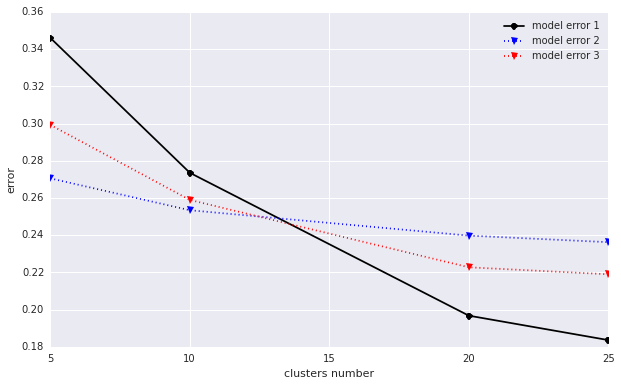

In [25]:
testAndPlotTheResult2(data_filtered, models_)

<div class="alert alert-success">
Plotting the new model errors, we didn't imporve the result. However it seems that the different error metrics has a more similar trend respect before. The fact that we didn't get big improvements could be also caused by the fact that we are only considering 20 time instants and not all dataset. If we had more, this would be the next step. Actually we have red on more than one font that DTWDistance is a good criteria, however it performs better when we have more long time series.
</div>

<div class="alert alert-success">
In conclusion we tried the last approach using an agglomerative clustering rather than the KMeans. We have used as metric distance the correlation.
</div>

For n_clusters = 5 The average silhouette_score is : 0.400256497702


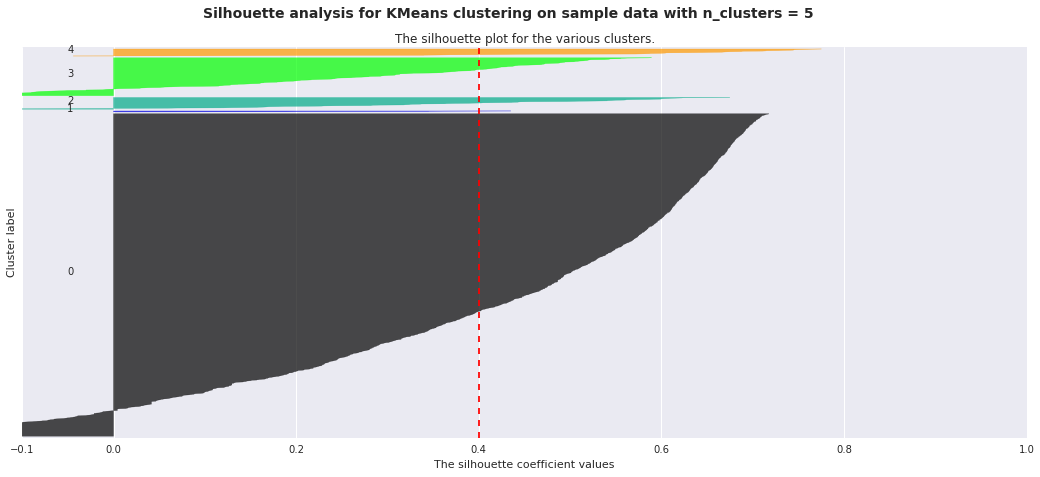

For n_clusters = 10 The average silhouette_score is : 0.356619561039


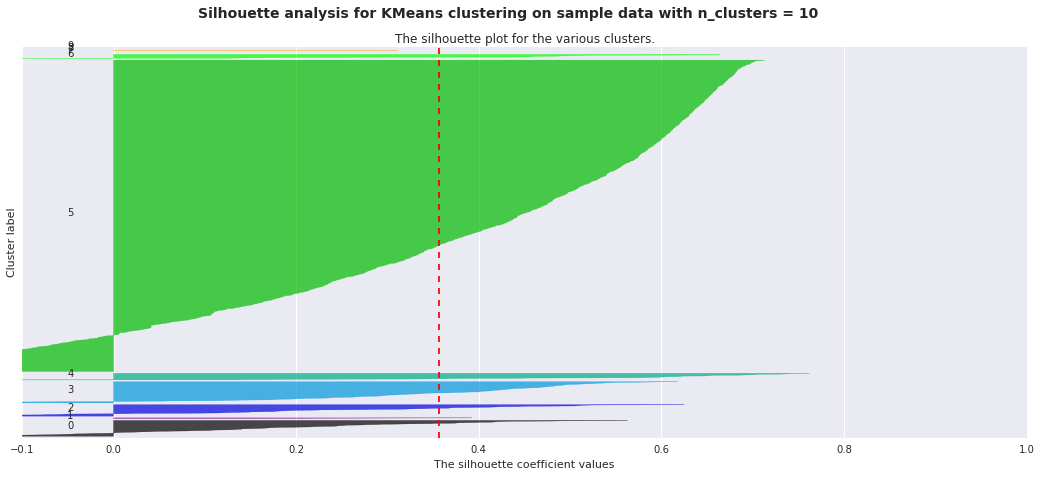

For n_clusters = 15 The average silhouette_score is : 0.32672264022


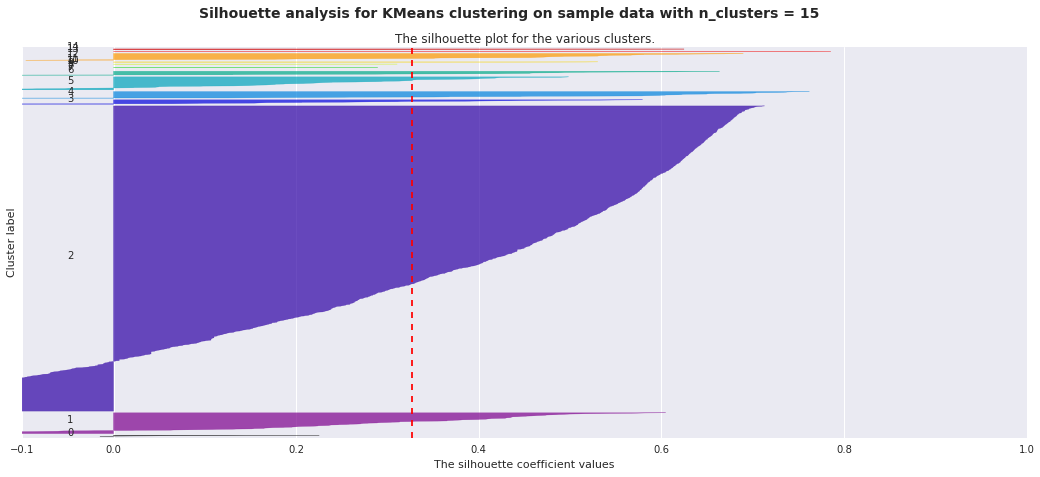

For n_clusters = 20 The average silhouette_score is : 0.266206779996


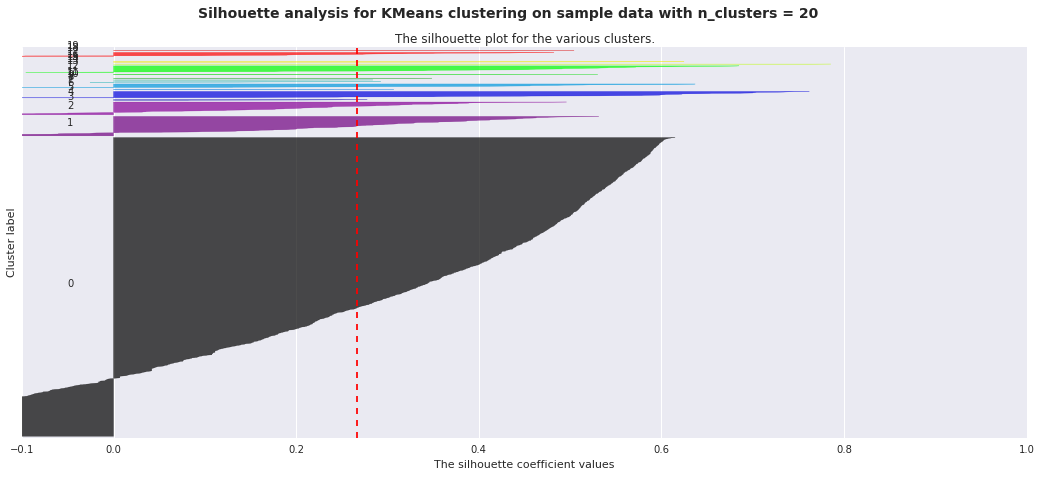

For n_clusters = 30 The average silhouette_score is : 0.246759449102


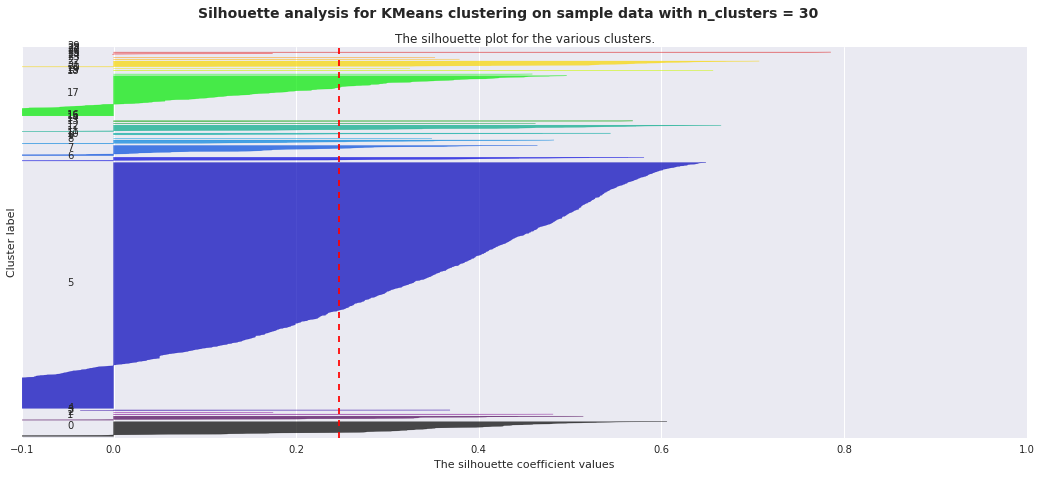

For n_clusters = 50 The average silhouette_score is : 0.185528152558


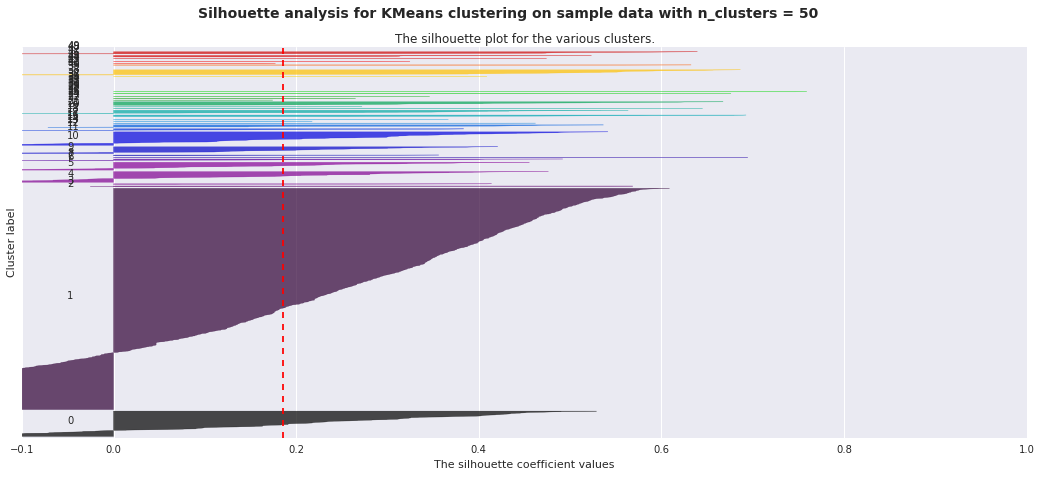

For n_clusters = 100 The average silhouette_score is : 0.278805942238


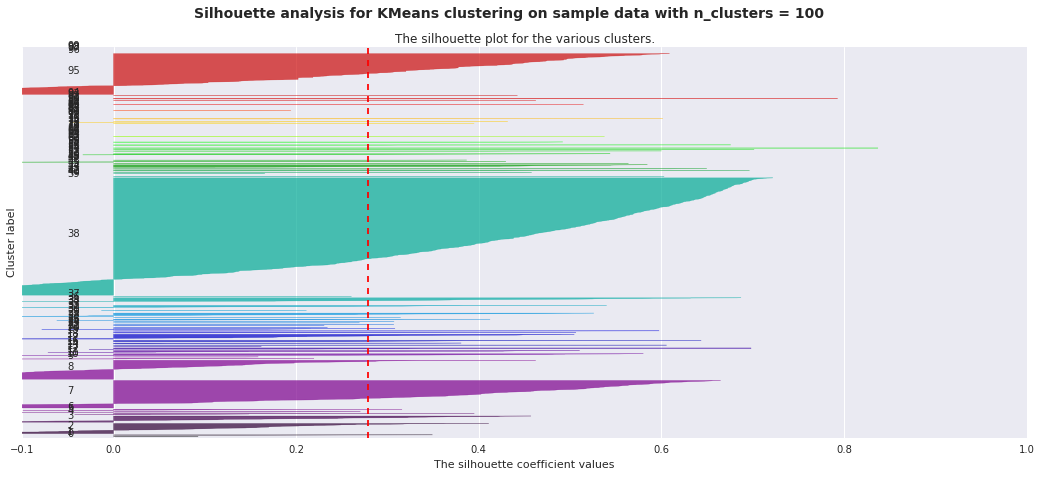

For n_clusters = 200 The average silhouette_score is : 0.246725985915


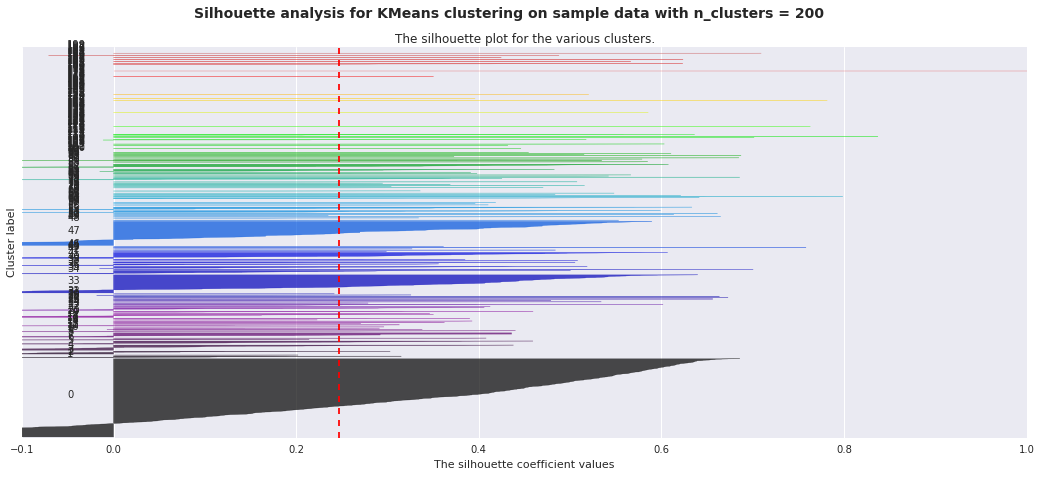

In [64]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
X = np.array(data_local_filtered)
range_n_clusters = [5, 10, 15, 20, 30, 50, 100, 200]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    
    

    clusterer = AgglomerativeClustering(n_clusters=n_clusters,linkage='average', affinity='correlation')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels,metric="correlation")
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels,metric="correlation")

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

<div class="alert alert-success">
Above there is the silhouette plot using this new approach. This time,looking at the silhouette, the best idea seems to use a small number of clusters (as 5).
</div>

<div class="alert alert-success">
What we can conclude at the end of this Notebook is that we have tried many different approaches but the quality of the results is not really improved. Actually the big issue of this Notebbok is that is not so easy to evaluate the results; in fact the domain (the brain images) is not so easy and to identify specific behaviour also more. However it was interesting to play with thunder and to try to reason about the meaning of our results.
</div>